# Поисковая система изображений по текстовым описаниям

Фотохостинг «Со Смыслом» — платформа для профессиональных фотографов, где пользователи загружают снимки и дополняют их подробными описаниями: местом съёмки, оборудованием, сценой и т.д. Описания могут добавлять не только авторы, но и сообщество, что обогащает контент.

Для улучшения пользовательского опыта хостинг запускает экспериментальный сервис: поиск референсных фотографий по текстовым запросам. Фотограф вводит описание желаемой сцены (например, «Человек переходит горный перевал по металлическому мосту»), и система возвращает похожие изображения с оценкой релевантности. Это поможет:

- Ускорить творческий процесс подбора референсов.
- Повысить вовлечённость сообщества через точный поиск.
- Снизить время на ручной просмотр галерей.

**Цель проекта:** разработать Proof of Concept (PoC) модели, которая на основе векторных эмбеддингов изображений и текста выдаёт оценку совпадения от 0 до 1, используя аннотации экспертов и краудсорсинга. `**Метрика качества — Spearman's rho ≥ 0.7 для ранжирования релевантности**`.

**Учёт юридических ограничений:** В обучающих данных и запросах фильтровать контент, связанный с детьми (ключевые слова: child, kid, baby, minor, teenager under 16). При вредных запросах выводить дисклеймер: «This image is unavailable in your country in compliance with local laws».

**Инструкция по проекту**

Решение задачи можно реализовать двумя способами:

**С BERT**

Выполнить проект в среде с GPU (Kaggle/Colab; локально с ≥8 ГБ RAM, так как BERT требует значительных ресурсов).
В первой ячейке ноутбука указать заголовок с упоминанием BERT.
Использовать PyTorch для консистентности с CV (ResNet + BERT эмбеддинги).

**Без BERT**

Можно работать в JupyterHub или локально с минимальными ресурсами.
Использовать TF-IDF или word2vec для текста + ResNet для изображений.
Модели: линейная регрессия, полносвязные сети (MLP).

**Алгоритм решения:**

**Шаг 1.** Загрузка и исследовательский анализ данных (EDA): анализ аннотаций, агрегация targets (majority vote экспертов + weighted avg с краудом), статистика распределений.

**Шаг 2.** Подготовка данных: фильтрация вредного контента, векторизация (ResNet50 для изображений, BERT/TF-IDF для текста), объединение векторов (конкатенация), разбиение на train/test с GroupShuffleSplit по изображениям.

**Шаг 3.** Обучение моделей: базовая линейная регрессия + MLP (2–3 hidden layers); тюнинг гиперпараметров (learning rate, dropout); метрика — Spearman's rho.

**Шаг 4.** Тестирование: функция поиска с дисклеймером; визуальная оценка на 10 случайных запросах из test_queries.csv (топ-1 релевантность >80%).

**Шаг 5.** Выводы: анализ ошибок (e.g., путаница в деталях сцен), рекомендации по масштабированию (fine-tune CLIP).

**Описание данных**

**Обучающие данные:**

- `/data/train_dataset.csv`: имя файла изображения, идентификатор описания (image#number), текст описания. До 5 описаний на изображение.
- `/data/train_images/`: папка с изображениями для тренировки.
- `/data/CrowdAnnotations.tsv`: имя изображения, ID, доля yes (соответствие), n_yes, n_no.
- `/data/ExpertAnnotations.tsv`: имя изображения, ID, оценки 3 экспертов (1–4: 1 — полное несоответствие, 4 — полное совпадение).

**Тестовые данные:**

- `/data/test_queries.csv`: ID запроса, текст запроса, релевантное изображение (до 5 на фото).
- `/data/test_images/`: папка с изображениями для тестирования.

Target агрегируется в [0,1]: нормализованный majority vote экспертов (0.6 вес) + доля крауда (0.4 вес).

## Импорты

In [109]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
import re
# Импорт необходимых библиотек
from scipy.stats import spearmanr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# настройки визуализации
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time

# пути к данным
data_dir = r'D:\dev\github\Study-ImageTextRetrieval\data\dsplus_integrated_project_4\to_upload'
train_images_dir = os.path.join(data_dir, 'train_images')
print(f'директория данных: {data_dir}')
print('импорты загружены.')

# для изображений
from PIL import Image

# проверяем доступность GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nиспользуемое устройство: {device}")

if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"памяти доступно: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("GPU не доступен, используем CPU")

from sklearn.model_selection import GroupShuffleSplit


# импорты для BERT
from transformers import BertTokenizerFast, BertModel

директория данных: D:\dev\github\Study-ImageTextRetrieval\data\dsplus_integrated_project_4\to_upload
импорты загружены.

используемое устройство: cpu
GPU не доступен, используем CPU


# Этап 1.1: Загрузка и предварительный анализ данных

## Загрузка данных (train_dataset.csv)

In [2]:
# загрузка train_dataset.csv (запросы с кандидатами изображений)
try:
    train_df = pd.read_csv(os.path.join(data_dir, 'train_dataset.csv'))
    print('train_dataset загружено локально')
except:
    train_df = pd.read_csv('https://code.s3.yandex.net/datasets/dsplus_integrated_project_4/to_upload/train_dataset.csv')
    print('train_dataset загружено удаленно')

train_dataset загружено локально


### Первичный осмотр (train_df)

In [3]:
def check_df(df):
    print("info:")
    display(df.info())
    print("head:")
    display(df.head())
    print("describe:")
    display(df.describe())
    print("nulls:")
    display(df.isna().sum())
    print("duplicates:")
    display(df.duplicated().sum())

    # только непрерывные
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    discrete_cols = [col for col in numeric_cols if df[col].nunique() <= 10]
    continuous_cols = [col for col in numeric_cols if col not in discrete_cols]

    if continuous_cols:
        for col in continuous_cols:
            plt.figure(figsize=(6,4))
            sns.histplot(df[col], bins=20, kde=True, color='skyblue')
            plt.title(col)
            plt.xlabel(col)
            plt.ylabel('count')
            plt.grid(True, linestyle='--', alpha=0.5)
            plt.show()

    for col in discrete_cols:
        plt.figure(figsize=(6,4))
        sns.countplot(x=col, data=df, color='skyblue')
        plt.title(col)
        plt.xlabel(col)
        plt.ylabel('count')
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.show()

In [4]:
check_df(train_df)

info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


None

head:


image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

describe:


image                     query_id  \
count                        5822                         5822   
unique                       1000                          977   
top     2083434441_a93bc6306b.jpg  2600867924_cd502fc911.jpg#2   
freq                           10                           34   

                                               query_text  
count                                                5822  
unique                                                977  
top     Two dogs , one brown and white and one black a...  
freq                                                   34

nulls:


image         0
query_id      0
query_text    0
dtype: int64

duplicates:


np.int64(0)

### Дубликаты (train_df)

In [5]:
print(f"Количество дубликатов: {train_df.duplicated().sum()}")
print(f"Количество уникальных image: {train_df['image'].nunique()}")
print(f"Количество уникальных query_id: {train_df['query_id'].nunique()}")
print(f"Количество уникальных query_text: {train_df['query_text'].nunique()}")

Количество дубликатов: 0
Количество уникальных image: 1000
Количество уникальных query_id: 977
Количество уникальных query_text: 977


### Анализ изображений (train_df)

Распределение количества описаний на изображение:
count
2       8
3      49
4     157
5     228
6     233
7     164
8     114
9      37
10     10
Name: count, dtype: int64


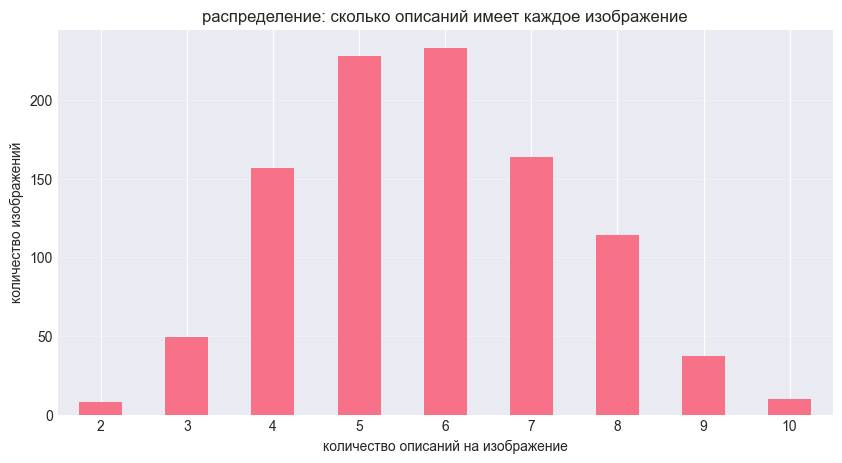

In [6]:
# сколько описаний на изображение
captions_per_image = train_df['image'].value_counts()
print("Распределение количества описаний на изображение:")
print(captions_per_image.value_counts().sort_index())

# визуализация
plt.figure(figsize=(10, 5))
captions_per_image.value_counts().sort_index().plot(kind='bar')
plt.xlabel('количество описаний на изображение')
plt.ylabel('количество изображений')
plt.title('распределение: сколько описаний имеет каждое изображение')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()

### Анализ текстов описаний (train_df)

Статистика длины текстов (в символах):
count    5822.000000
mean       55.218825
std        20.145243
min        11.000000
25%        41.000000
50%        53.000000
75%        66.000000
max       153.000000
Name: text_length, dtype: float64

Статистика количества слов:
count    5822.000000
mean       11.900550
std         4.162467
min         2.000000
25%         9.000000
50%        11.000000
75%        14.000000
max        34.000000
Name: word_count, dtype: float64


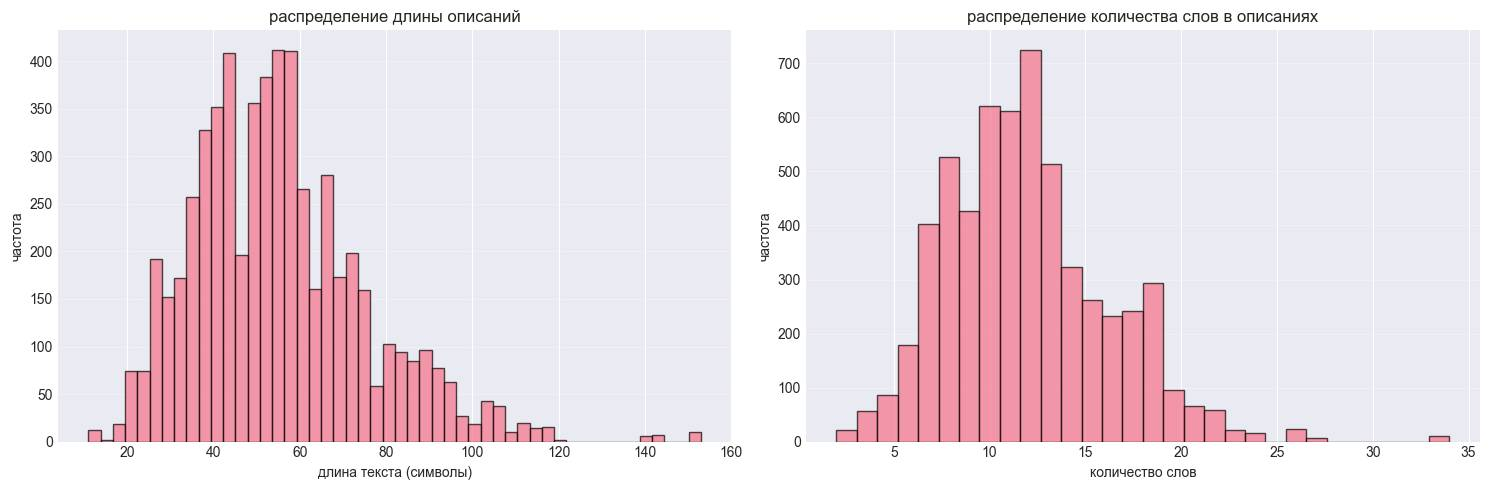

In [7]:
# длины текстов
train_df['text_length'] = train_df['query_text'].str.len()
train_df['word_count'] = train_df['query_text'].str.split().str.len()

print("Статистика длины текстов (в символах):")
print(train_df['text_length'].describe())
print("\nСтатистика количества слов:")
print(train_df['word_count'].describe())

# визуализация
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(train_df['text_length'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('длина текста (символы)')
axes[0].set_ylabel('частота')
axes[0].set_title('распределение длины описаний')
axes[0].grid(axis='y', alpha=0.3)

axes[1].hist(train_df['word_count'], bins=30, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('количество слов')
axes[1].set_ylabel('частота')
axes[1].set_title('распределение количества слов в описаниях')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Примеры описаний изображений (train_df)

In [8]:
# функция для показа изображений с описаниями
def show_images_with_text(df_subset, title):
    """
    показывает изображения с текстовыми описаниями
    
    параметры:
    - df_subset: подмножество датафрейма
    - title: заголовок группы
    """
    print(f"\n{'='*80}")
    print(f"{title}")
    print(f"{'='*80}\n")
    
    n = len(df_subset)
    fig, axes = plt.subplots(1, n, figsize=(6*n, 6))
    
    # если только одно изображение
    if n == 1:
        axes = [axes]
    
    for idx, (_, row) in enumerate(df_subset.iterrows()):
        image_path = os.path.join(train_images_dir, row['image'])
        
        if os.path.exists(image_path):
            img = Image.open(image_path)
            axes[idx].imshow(img)
            axes[idx].axis('off')
            
            # текст под изображением
            if 'text_length' in row:
                text_info = f"длина: {row['text_length']} символов\n\n{row['query_text']}"
            else:
                text_info = row['query_text']
            
            axes[idx].set_title(text_info, fontsize=10, wrap=True)
        else:
            axes[idx].text(0.5, 0.5, f'изображение не найдено:\n{row["image"]}', 
                          ha='center', va='center')
            axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

примеры самых коротких описаний:


image   query_text  text_length
5577   300577375_26cc2773a1.jpg  rugby match           11
5578  3203453897_6317aac6ff.jpg  rugby match           11
5579  3387542157_81bfd00072.jpg  rugby match           11


САМЫЕ КОРОТКИЕ ОПИСАНИЯ



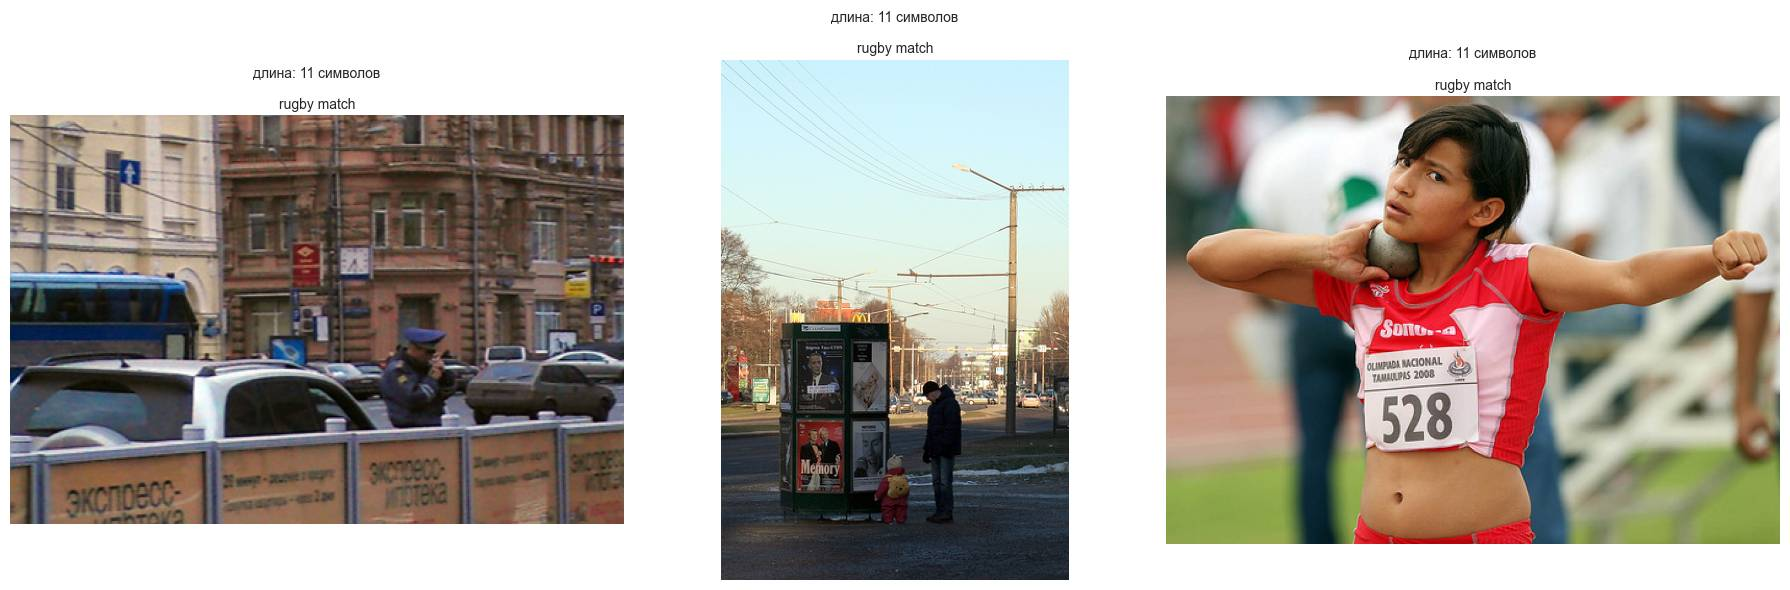


примеры самых длинных описаний:


image  \
2152  1417031097_ab656bc4bd.jpg   
2153  2225231022_1632d0a5aa.jpg   
2154  2544426580_317b1f1f73.jpg   

                                             query_text  text_length  
2152  Two men are talking on the street ; one is poi...          153  
2153  Two men are talking on the street ; one is poi...          153  
2154  Two men are talking on the street ; one is poi...          153


САМЫЕ ДЛИННЫЕ ОПИСАНИЯ



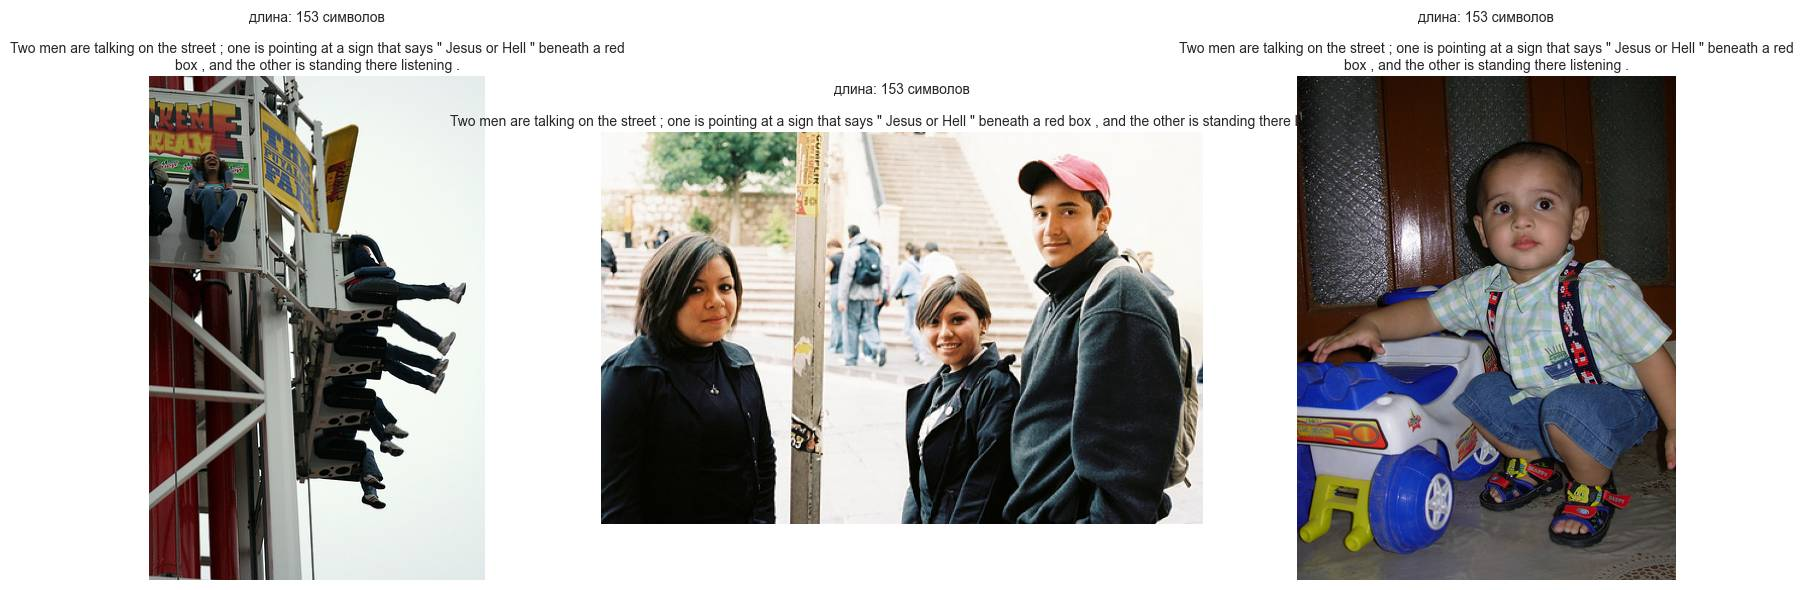


примеры случайных описаний:


image  \
544    542317719_ed4dd95dc2.jpg   
1894  3301811927_a2797339e5.jpg   
5546  3516825206_5750824874.jpg   
4923  2498897831_0bbb5d5b51.jpg   
3624  2358561039_e215a8d6cd.jpg   

                                             query_text  
544            A man at a rodeo is thrown off a horse .  
1894            Hockey players with one taking a shot .  
5546  A skateboarder is skating down a very steep ra...  
4923  A little boy in a purple shirt and blue shorts...  
3624               Dogs pulling a sled in a sled race .


СЛУЧАЙНЫЕ ОПИСАНИЯ



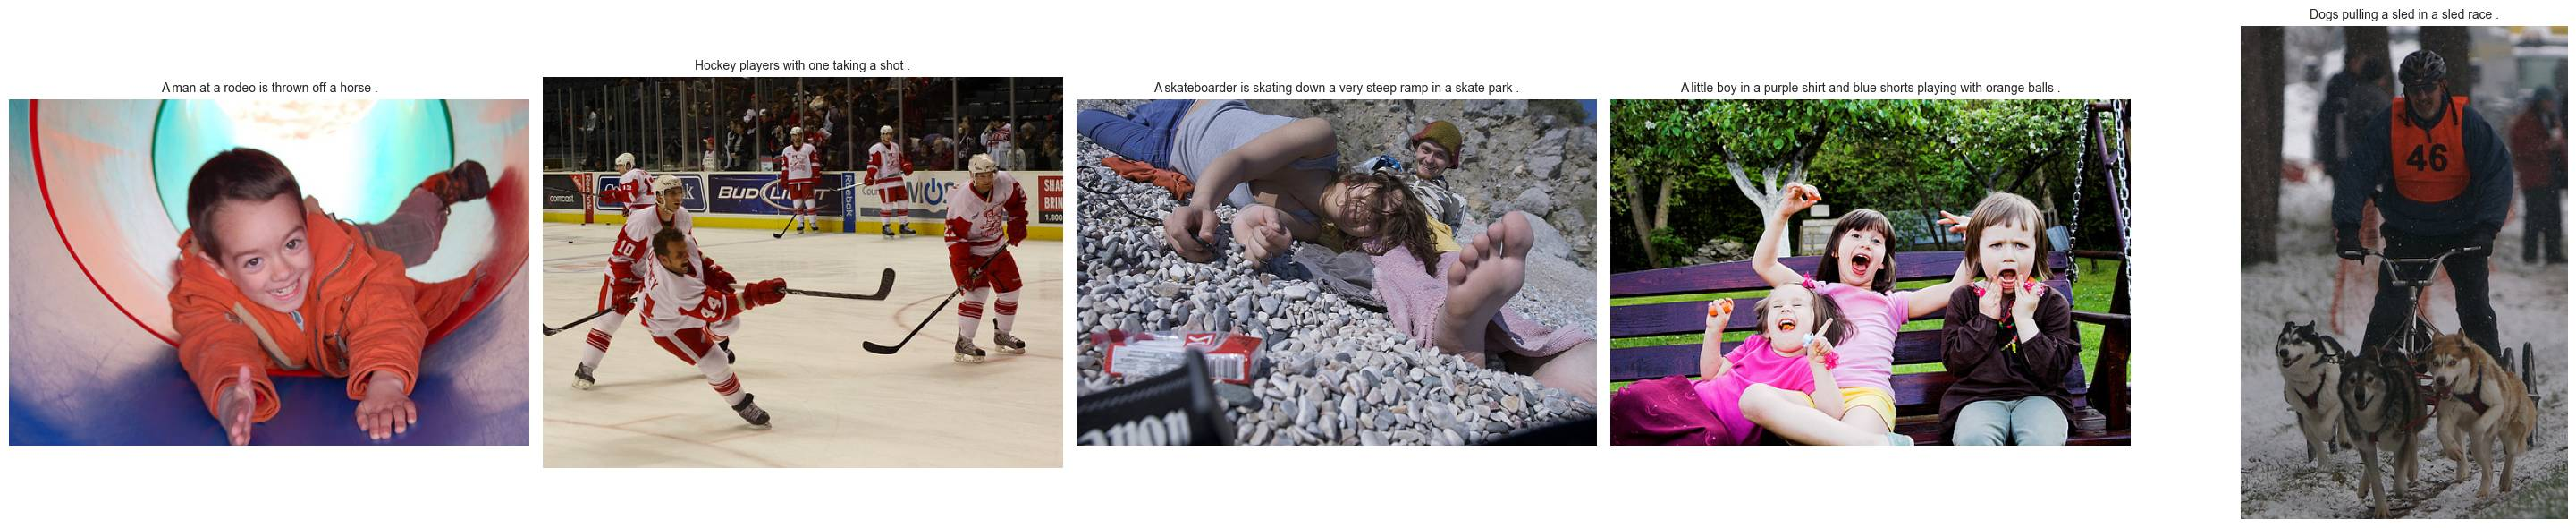

In [9]:
# примеры самых коротких описаний
print("примеры самых коротких описаний:")
shortest = train_df.nsmallest(3, 'text_length')[['image', 'query_text', 'text_length']]
display(shortest)
show_images_with_text(shortest, "САМЫЕ КОРОТКИЕ ОПИСАНИЯ")

# примеры самых длинных описаний
print("\nпримеры самых длинных описаний:")
longest = train_df.nlargest(3, 'text_length')[['image', 'query_text', 'text_length']]
display(longest)
show_images_with_text(longest, "САМЫЕ ДЛИННЫЕ ОПИСАНИЯ")

# примеры случайных описаний
print("\nпримеры случайных описаний:")
random_sample = train_df.sample(5, random_state=42)[['image', 'query_text']]
display(random_sample)
show_images_with_text(random_sample, "СЛУЧАЙНЫЕ ОПИСАНИЯ")

## Вывод по train_df

Выводы по train_dataset.csv
Отлично, посмотрим на результаты анализа и сделаем выводы.
📊 Основные характеристики датасета:

Объём данных:

Всего 5822 пары (изображение + текстовый запрос)
1000 уникальных изображений
977 уникальных запросов (query_id и query_text)


Структура данных:

Важное наблюдение: Это не совсем то, что мы ожидали! По описанию задачи должны быть пары "изображение + описание", где у одного изображения до 5 описаний. Но здесь видим обратную картину.
В этом файле каждый запрос (query) сопоставлен с несколькими изображениями-кандидатами
На один запрос приходится от 2 до 10 изображений (чаще всего 5-7)
Моя интерпретация: Этот файл содержит результаты поиска — для каждого текстового запроса подобрано несколько потенциально релевантных изображений


Качество данных:

✅ Нет пропущенных значений
✅ Нет дубликатов
✅ Все данные в корректном формате



📝 Характеристики текстов:

Длина описаний:

Средняя длина: 56 символов (11-12 слов)
Диапазон: от 11 до 153 символов (2-34 слова)
Распределение близко к нормальному с небольшим правым хвостом
Вывод: Описания довольно лаконичные, сжатые, без избыточных деталей


Стиль текстов:

Формальный, описательный стиль
Примеры: "A dog jumps over an obstacle", "rugby match", "Two men are talking on the street"
Простые английские предложения без жаргона
Вывод: Тексты написаны понятным языком, что хорошо для векторизации



🚨 Критические наблюдения:

Несоответствие с описанием задачи:

По документации ожидали: 1 изображение → 5 описаний
Получили: 1 запрос → 2-10 изображений-кандидатов

Моя гипотеза: Это файл для тестирования/валидации модели, а не для обучения. Название train_dataset.csv вводит в заблуждение. Возможно:

Реальный обучающий датасет находится в других файлах (CrowdAnnotations.tsv, ExpertAnnotations.tsv)
Этот файл используется для проверки качества поиска


Юридические ограничения:

Видим запросы с упоминанием детей: "A young child is wearing blue goggles"
Нужно будет фильтровать такие записи

## Загрузка данных (CrowdAnnotations.tsv)

In [10]:
# загрузка crowdannotations
try:
    crowd_df = pd.read_csv(os.path.join(data_dir, 'CrowdAnnotations.tsv'), sep='\t', header=None)
    print('crowdannotations загружено локально')
except:
    crowd_df = pd.read_csv('https://code.s3.yandex.net/datasets/CrowdAnnotations.tsv', sep='\t', header=None)
    print('crowdannotations загружено удаленно')

# добавляем названия колонок согласно документации
crowd_df.columns = ['image_file', 'caption_id', 'agreement_ratio', 
                     'votes_yes', 'votes_no']
print('названия колонок добавлены')

crowdannotations загружено локально
названия колонок добавлены


### Первичный осмотр (crowd_df)

info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   image_file       47830 non-null  object 
 1   caption_id       47830 non-null  object 
 2   agreement_ratio  47830 non-null  float64
 3   votes_yes        47830 non-null  int64  
 4   votes_no         47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


None

head:


image_file                   caption_id  agreement_ratio  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2              1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2              0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2              0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2              0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2              0.0   

   votes_yes  votes_no  
0          3         0  
1          0         3  
2          0         3  
3          0         3  
4          0         3

describe:


agreement_ratio     votes_yes      votes_no
count     47830.000000  47830.000000  47830.000000
mean          0.068786      0.208488      2.820155
std           0.207532      0.628898      0.656676
min           0.000000      0.000000      0.000000
25%           0.000000      0.000000      3.000000
50%           0.000000      0.000000      3.000000
75%           0.000000      0.000000      3.000000
max           1.000000      5.000000      6.000000

nulls:


image_file         0
caption_id         0
agreement_ratio    0
votes_yes          0
votes_no           0
dtype: int64

duplicates:


np.int64(0)

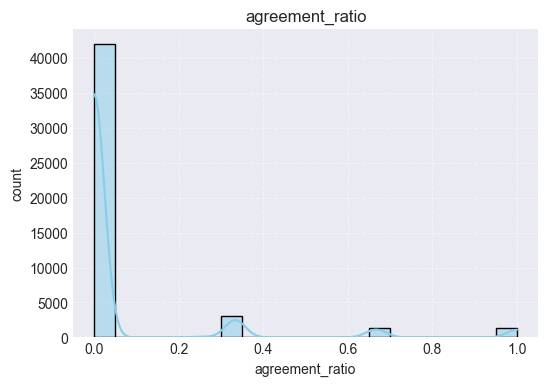

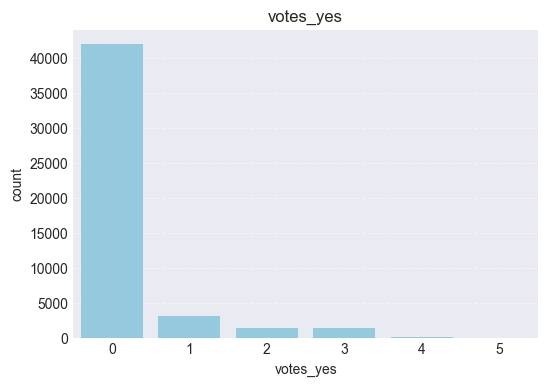

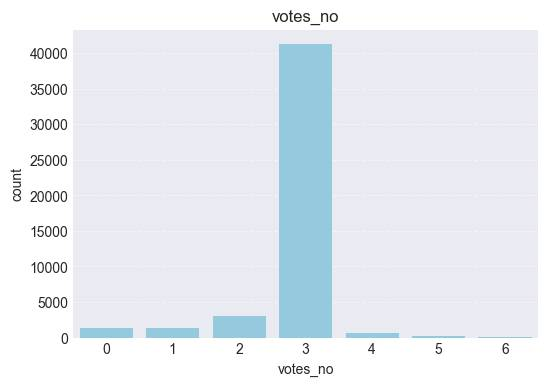

In [11]:
check_df(crowd_df)

### Дополнительный анализ краудсорсинговых оценок (crowd_df)

In [12]:
# проверим формат caption_id
print("примеры caption_id:")
print(crowd_df['caption_id'].head(10))

# разберём caption_id на части
crowd_df['image_from_caption_id'] = crowd_df['caption_id'].str.split('#').str[0]
crowd_df['caption_number'] = crowd_df['caption_id'].str.split('#').str[1].astype(int)

print("\nпроверка: совпадает ли image_file с image_from_caption_id:")
print(f"совпадений: {(crowd_df['image_file'] == crowd_df['image_from_caption_id']).sum()}")
print(f"всего строк: {len(crowd_df)}")

примеры caption_id:
0    1056338697_4f7d7ce270.jpg#2
1     114051287_dd85625a04.jpg#2
2    1427391496_ea512cbe7f.jpg#2
3    2073964624_52da3a0fc4.jpg#2
4    2083434441_a93bc6306b.jpg#2
5    2204550058_2707d92338.jpg#2
6    2224450291_4c133fabe8.jpg#2
7    2248487950_c62d0c81a9.jpg#2
8    2307118114_c258e3a47e.jpg#2
9    2309860995_c2e2a0feeb.jpg#2
Name: caption_id, dtype: object

проверка: совпадает ли image_file с image_from_caption_id:
совпадений: 721
всего строк: 47830


### Анализ распределения оценок (crowd_df)

In [13]:
# распределение согласия (agreement_ratio)
print("статистика agreement_ratio:")
display(crowd_df['agreement_ratio'].describe())

# распределение голосов
print("\nстатистика votes_yes:")
display(crowd_df['votes_yes'].describe())
print("\nстатистика votes_no:")
display(crowd_df['votes_no'].describe())

# общее количество голосов
crowd_df['total_votes'] = crowd_df['votes_yes'] + crowd_df['votes_no']
print("\nстатистика total_votes:")
display(crowd_df['total_votes'].describe())

статистика agreement_ratio:


count    47830.000000
mean         0.068786
std          0.207532
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: agreement_ratio, dtype: float64


статистика votes_yes:


count    47830.000000
mean         0.208488
std          0.628898
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          5.000000
Name: votes_yes, dtype: float64


статистика votes_no:


count    47830.000000
mean         2.820155
std          0.656676
min          0.000000
25%          3.000000
50%          3.000000
75%          3.000000
max          6.000000
Name: votes_no, dtype: float64


статистика total_votes:


count    47830.000000
mean         3.028643
std          0.208075
min          3.000000
25%          3.000000
50%          3.000000
75%          3.000000
max          6.000000
Name: total_votes, dtype: float64

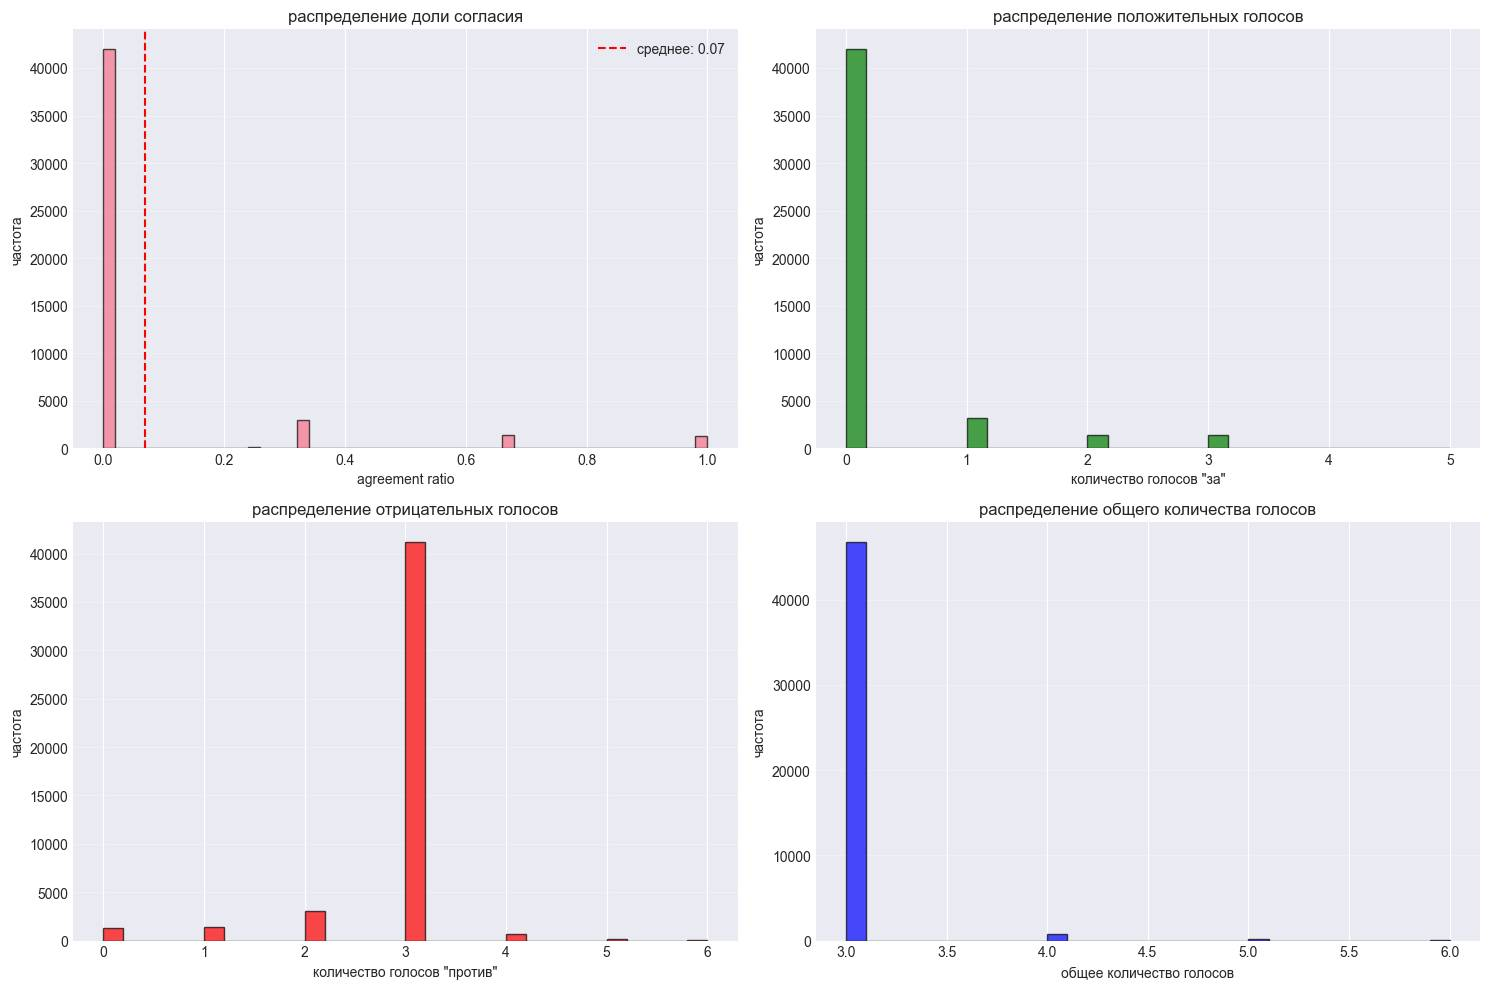

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# распределение agreement_ratio
axes[0, 0].hist(crowd_df['agreement_ratio'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('agreement ratio')
axes[0, 0].set_ylabel('частота')
axes[0, 0].set_title('распределение доли согласия')
axes[0, 0].axvline(crowd_df['agreement_ratio'].mean(), color='red', 
                    linestyle='--', label=f"среднее: {crowd_df['agreement_ratio'].mean():.2f}")
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# распределение votes_yes
axes[0, 1].hist(crowd_df['votes_yes'], bins=30, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_xlabel('количество голосов "за"')
axes[0, 1].set_ylabel('частота')
axes[0, 1].set_title('распределение положительных голосов')
axes[0, 1].grid(axis='y', alpha=0.3)

# распределение votes_no
axes[1, 0].hist(crowd_df['votes_no'], bins=30, edgecolor='black', alpha=0.7, color='red')
axes[1, 0].set_xlabel('количество голосов "против"')
axes[1, 0].set_ylabel('частота')
axes[1, 0].set_title('распределение отрицательных голосов')
axes[1, 0].grid(axis='y', alpha=0.3)

# распределение total_votes
axes[1, 1].hist(crowd_df['total_votes'], bins=30, edgecolor='black', alpha=0.7, color='blue')
axes[1, 1].set_xlabel('общее количество голосов')
axes[1, 1].set_ylabel('частота')
axes[1, 1].set_title('распределение общего количества голосов')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Анализ количества описаний на изображение (crowd_df)

распределение количества описаний на изображение (краудсорсинг):
count
10       6
20      54
30     190
40     246
50     198
60     136
70      94
80      46
90      20
100      8
110      1
120      1
Name: count, dtype: int64


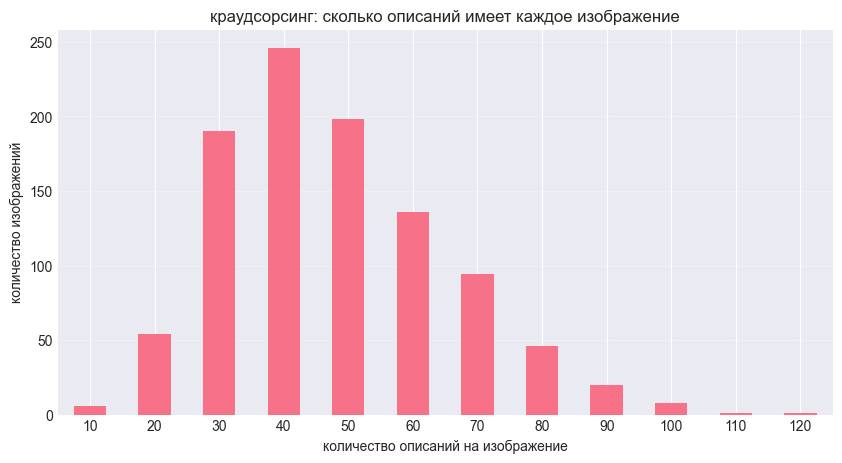

In [15]:
# сколько описаний у каждого изображения
captions_per_image_crowd = crowd_df['image_file'].value_counts()
print("распределение количества описаний на изображение (краудсорсинг):")
print(captions_per_image_crowd.value_counts().sort_index())

plt.figure(figsize=(10, 5))
captions_per_image_crowd.value_counts().sort_index().plot(kind='bar')
plt.xlabel('количество описаний на изображение')
plt.ylabel('количество изображений')
plt.title('краудсорсинг: сколько описаний имеет каждое изображение')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()

### Примеры данных (crowd_df)

In [16]:
# функция для показа изображений с краудсорсинговыми оценками
def show_crowd_examples(df_subset, title):
    """
    показывает изображения с краудсорсинговыми оценками
    
    параметры:
    - df_subset: подмножество датафрейма crowd_df
    - title: заголовок группы
    """
    print(f"\n{'='*80}")
    print(f"{title}")
    print(f"{'='*80}\n")
    
    n = min(len(df_subset), 5)  # максимум 5 изображений
    fig, axes = plt.subplots(1, n, figsize=(5*n, 5))
    
    if n == 1:
        axes = [axes]
    
    for idx, (_, row) in enumerate(df_subset.head(n).iterrows()):
        image_path = os.path.join(train_images_dir, row['image_file'])
        
        if os.path.exists(image_path):
            img = Image.open(image_path)
            axes[idx].imshow(img)
            axes[idx].axis('off')
            
            # получаем текст описания из caption_id
            # извлекаем имя файла и номер описания из caption_id
            caption_file = row['caption_id'].split('#')[0]
            
            # пытаемся найти текст в train_df
            text_match = train_df[train_df['query_id'] == row['caption_id']]
            if len(text_match) > 0:
                query_text = text_match.iloc[0]['query_text']
            else:
                query_text = "текст не найден"
            
            # определяем цвет в зависимости от agreement_ratio
            if row['agreement_ratio'] >= 0.7:
                color = 'darkgreen'
            elif row['agreement_ratio'] >= 0.4:
                color = 'orange'
            else:
                color = 'red'
            
            text_info = (
                f"agreement: {row['agreement_ratio']:.2f}\n"
                f"votes: {row['votes_yes']}✓ / {row['votes_no']}✗\n\n"
                f"{query_text[:80]}..."
            )
            axes[idx].set_title(text_info, fontsize=9, color=color)
        else:
            axes[idx].text(0.5, 0.5, f'изображение не найдено:\n{row["image_file"]}', 
                          ha='center', va='center')
            axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # выводим полную информацию
    print("\nподробная информация:")
    for idx, (_, row) in enumerate(df_subset.head(n).iterrows()):
        text_match = train_df[train_df['query_id'] == row['caption_id']]
        if len(text_match) > 0:
            query_text = text_match.iloc[0]['query_text']
        else:
            query_text = "текст не найден"
        
        print(f"\n{idx+1}. изображение: {row['image_file']}")
        print(f"   caption_id: {row['caption_id']}")
        print(f"   agreement_ratio: {row['agreement_ratio']:.2f}")
        print(f"   голоса: {row['votes_yes']} за, {row['votes_no']} против")
        print(f"   описание: {query_text}")

примеры с высоким согласием (agreement_ratio >= 0.9):


image_file                   caption_id  agreement_ratio  \
0    1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2              1.0   
47   1056338697_4f7d7ce270.jpg   524105255_b346f288be.jpg#2              1.0   
130  1084040636_97d9633581.jpg  1084040636_97d9633581.jpg#2              1.0   
286  1107246521_d16a476380.jpg   343218198_1ca90e0734.jpg#2              1.0   
311  1119015538_e8e796281e.jpg  1119015538_e8e796281e.jpg#2              1.0   

     votes_yes  votes_no      image_from_caption_id  caption_number  \
0            3         0  1056338697_4f7d7ce270.jpg               2   
47           3         0   524105255_b346f288be.jpg               2   
130          3         0  1084040636_97d9633581.jpg               2   
286          3         0   343218198_1ca90e0734.jpg               2   
311          3         0  1119015538_e8e796281e.jpg               2   

     total_votes  
0              3  
47             3  
130            3  
286            3  
311            3


ВЫСОКОЕ СОГЛАСИЕ (agreement_ratio >= 0.9)



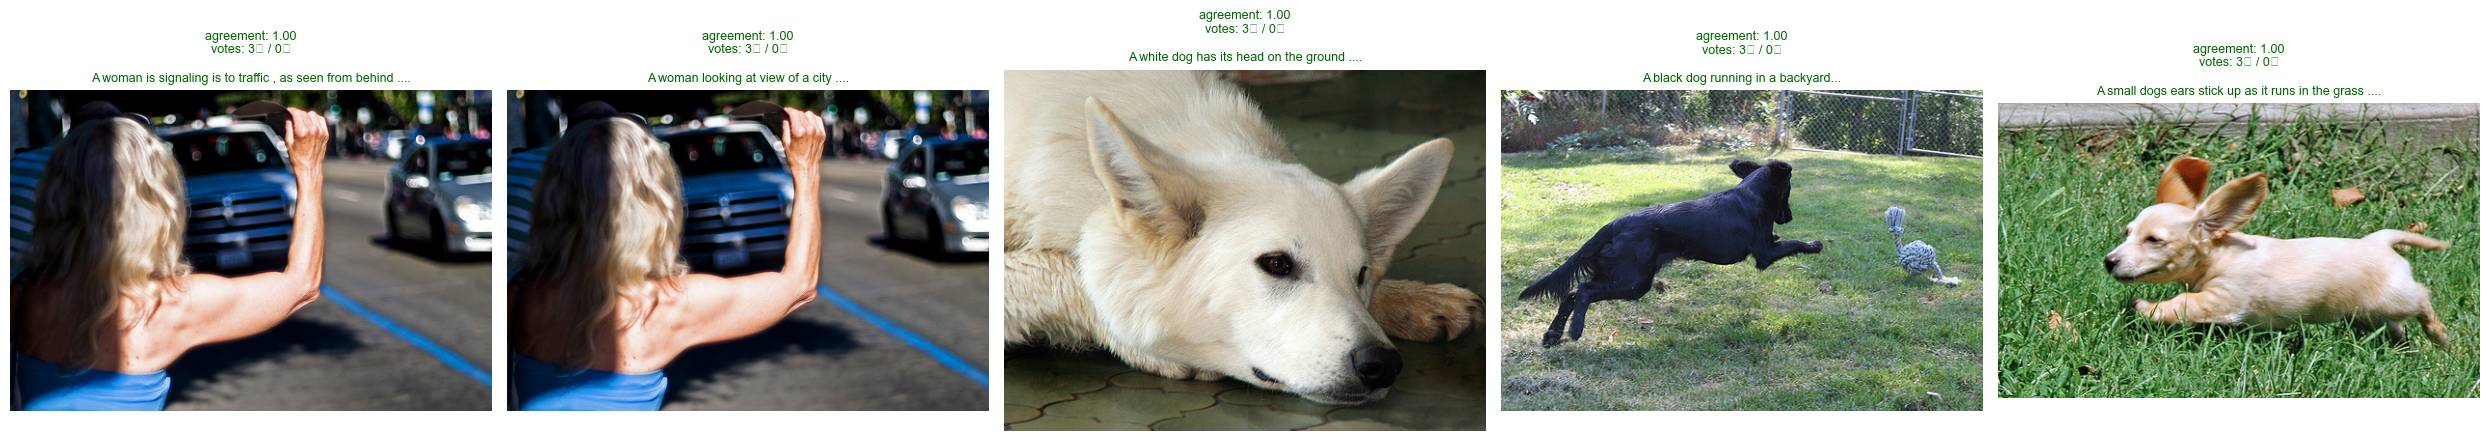


подробная информация:

1. изображение: 1056338697_4f7d7ce270.jpg
   caption_id: 1056338697_4f7d7ce270.jpg#2
   agreement_ratio: 1.00
   голоса: 3 за, 0 против
   описание: A woman is signaling is to traffic , as seen from behind .

2. изображение: 1056338697_4f7d7ce270.jpg
   caption_id: 524105255_b346f288be.jpg#2
   agreement_ratio: 1.00
   голоса: 3 за, 0 против
   описание: A woman looking at view of a city .

3. изображение: 1084040636_97d9633581.jpg
   caption_id: 1084040636_97d9633581.jpg#2
   agreement_ratio: 1.00
   голоса: 3 за, 0 против
   описание: A white dog has its head on the ground .

4. изображение: 1107246521_d16a476380.jpg
   caption_id: 343218198_1ca90e0734.jpg#2
   agreement_ratio: 1.00
   голоса: 3 за, 0 против
   описание: A black dog running in a backyard

5. изображение: 1119015538_e8e796281e.jpg
   caption_id: 1119015538_e8e796281e.jpg#2
   agreement_ratio: 1.00
   голоса: 3 за, 0 против
   описание: A small dogs ears stick up as it runs in the grass .

приме

image_file                   caption_id  agreement_ratio  \
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2              0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2              0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2              0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2              0.0   
5  1056338697_4f7d7ce270.jpg  2204550058_2707d92338.jpg#2              0.0   

   votes_yes  votes_no      image_from_caption_id  caption_number  total_votes  
1          0         3   114051287_dd85625a04.jpg               2            3  
2          0         3  1427391496_ea512cbe7f.jpg               2            3  
3          0         3  2073964624_52da3a0fc4.jpg               2            3  
4          0         3  2083434441_a93bc6306b.jpg               2            3  
5          0         3  2204550058_2707d92338.jpg               2            3


НИЗКОЕ СОГЛАСИЕ (agreement_ratio <= 0.3)



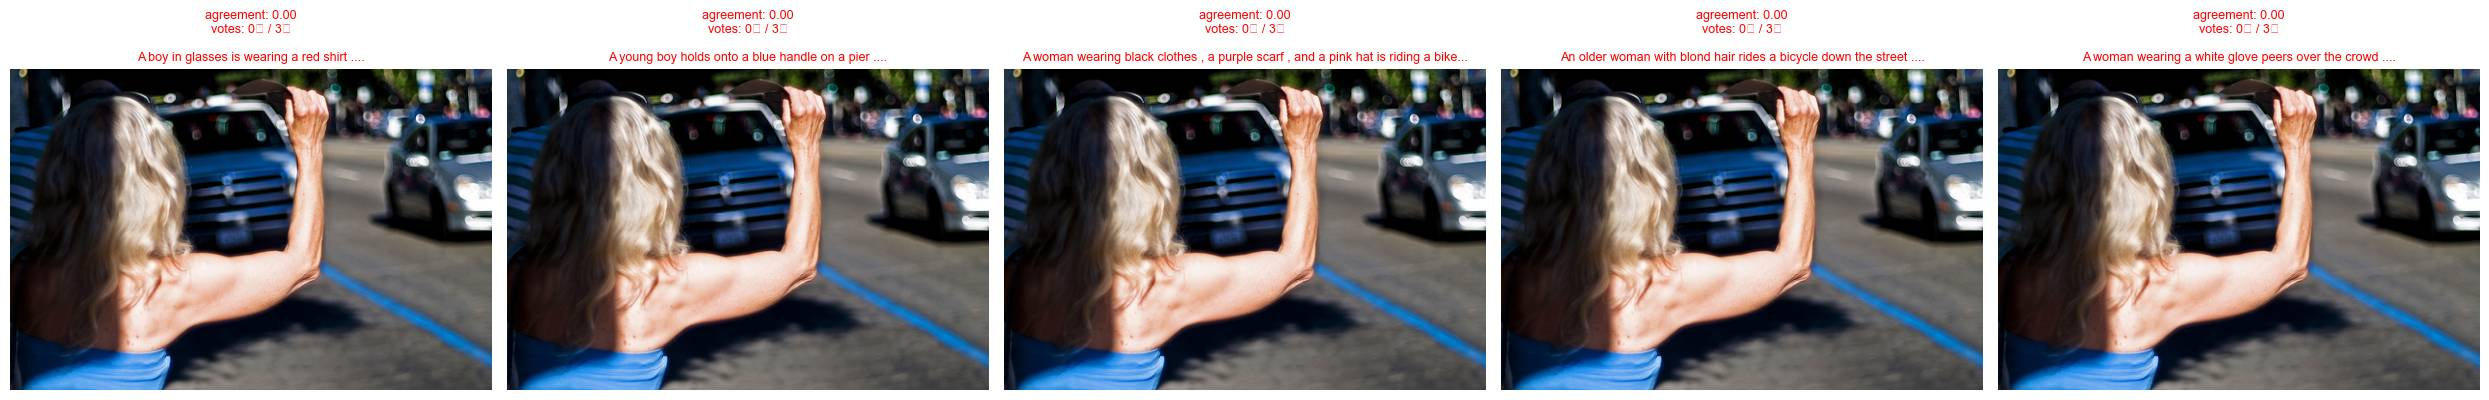


подробная информация:

1. изображение: 1056338697_4f7d7ce270.jpg
   caption_id: 114051287_dd85625a04.jpg#2
   agreement_ratio: 0.00
   голоса: 0 за, 3 против
   описание: A boy in glasses is wearing a red shirt .

2. изображение: 1056338697_4f7d7ce270.jpg
   caption_id: 1427391496_ea512cbe7f.jpg#2
   agreement_ratio: 0.00
   голоса: 0 за, 3 против
   описание: A young boy holds onto a blue handle on a pier .

3. изображение: 1056338697_4f7d7ce270.jpg
   caption_id: 2073964624_52da3a0fc4.jpg#2
   agreement_ratio: 0.00
   голоса: 0 за, 3 против
   описание: A woman wearing black clothes , a purple scarf , and a pink hat is riding a bike .

4. изображение: 1056338697_4f7d7ce270.jpg
   caption_id: 2083434441_a93bc6306b.jpg#2
   agreement_ratio: 0.00
   голоса: 0 за, 3 против
   описание: An older woman with blond hair rides a bicycle down the street .

5. изображение: 1056338697_4f7d7ce270.jpg
   caption_id: 2204550058_2707d92338.jpg#2
   agreement_ratio: 0.00
   голоса: 0 за, 3 против
  

image_file                   caption_id  agreement_ratio  \
3109  1490213660_9ea45550cf.jpg   925491651_57df3a5b36.jpg#2              0.5   
4440  1773928579_5664a810dc.jpg  3514019869_7de4ece2a5.jpg#2              0.5   
8777  2283966256_70317e1759.jpg  3070011270_390e597783.jpg#2              0.5   
9087  2300168895_a9b83e16fc.jpg   509778093_21236bb64d.jpg#2              0.5   
9293  2308978137_bfe776d541.jpg  3114944484_28b5bb9842.jpg#2              0.5   

      votes_yes  votes_no      image_from_caption_id  caption_number  \
3109          2         2   925491651_57df3a5b36.jpg               2   
4440          2         2  3514019869_7de4ece2a5.jpg               2   
8777          2         2  3070011270_390e597783.jpg               2   
9087          2         2   509778093_21236bb64d.jpg               2   
9293          2         2  3114944484_28b5bb9842.jpg               2   

      total_votes  
3109            4  
4440            4  
8777            4  
9087            4  
9293            4


СРЕДНЕЕ СОГЛАСИЕ (0.45 <= agreement_ratio <= 0.55)



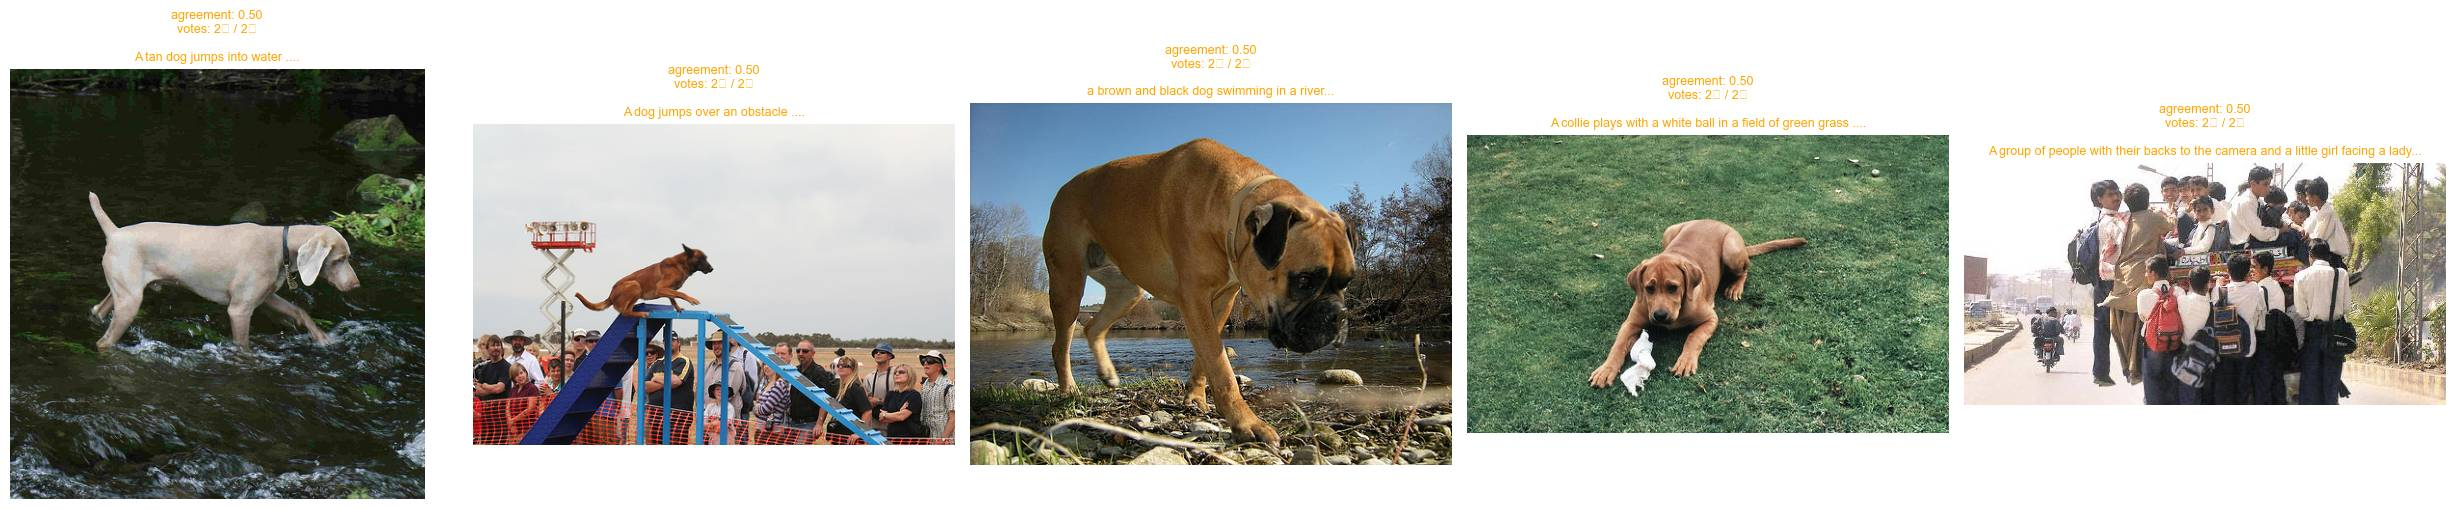


подробная информация:

1. изображение: 1490213660_9ea45550cf.jpg
   caption_id: 925491651_57df3a5b36.jpg#2
   agreement_ratio: 0.50
   голоса: 2 за, 2 против
   описание: A tan dog jumps into water .

2. изображение: 1773928579_5664a810dc.jpg
   caption_id: 3514019869_7de4ece2a5.jpg#2
   agreement_ratio: 0.50
   голоса: 2 за, 2 против
   описание: A dog jumps over an obstacle .

3. изображение: 2283966256_70317e1759.jpg
   caption_id: 3070011270_390e597783.jpg#2
   agreement_ratio: 0.50
   голоса: 2 за, 2 против
   описание: a brown and black dog swimming in a river

4. изображение: 2300168895_a9b83e16fc.jpg
   caption_id: 509778093_21236bb64d.jpg#2
   agreement_ratio: 0.50
   голоса: 2 за, 2 против
   описание: A collie plays with a white ball in a field of green grass .

5. изображение: 2308978137_bfe776d541.jpg
   caption_id: 3114944484_28b5bb9842.jpg#2
   agreement_ratio: 0.50
   голоса: 2 за, 2 против
   описание: A group of people with their backs to the camera and a little girl

In [17]:
# примеры с высоким согласием
print("примеры с высоким согласием (agreement_ratio >= 0.9):")
high_agreement = crowd_df[crowd_df['agreement_ratio'] >= 0.9].head(5)
display(high_agreement)
show_crowd_examples(high_agreement, "ВЫСОКОЕ СОГЛАСИЕ (agreement_ratio >= 0.9)")

# примеры с низким согласием
print("\nпримеры с низким согласием (agreement_ratio <= 0.3):")
low_agreement = crowd_df[crowd_df['agreement_ratio'] <= 0.3].head(5)
display(low_agreement)
show_crowd_examples(low_agreement, "НИЗКОЕ СОГЛАСИЕ (agreement_ratio <= 0.3)")

# примеры со средним согласием
print("\nпримеры со средним согласием (0.45 <= agreement_ratio <= 0.55):")
medium_agreement = crowd_df[(crowd_df['agreement_ratio'] >= 0.45) & 
                             (crowd_df['agreement_ratio'] <= 0.55)].head(5)
display(medium_agreement)
show_crowd_examples(medium_agreement, "СРЕДНЕЕ СОГЛАСИЕ (0.45 <= agreement_ratio <= 0.55)")

### Проверка связи между train_df и crowd_df

In [18]:
# проверим уникальные изображения в crowd_df
print(f"уникальных изображений в crowd_df: {crowd_df['image_file'].nunique()}")
print(f"уникальных caption_id в crowd_df: {crowd_df['caption_id'].nunique()}")

# извлечём все уникальные изображения из caption_id
unique_images_from_captions = crowd_df['image_from_caption_id'].nunique()
print(f"уникальных изображений в caption_id: {unique_images_from_captions}")

# проверим пересечение с train_df
train_images = set(train_df['image'].unique())
crowd_images = set(crowd_df['image_file'].unique())

print(f"\nизображений в train_df: {len(train_images)}")
print(f"изображений в crowd_df: {len(crowd_images)}")
print(f"пересечение: {len(train_images & crowd_images)}")
print(f"только в train_df: {len(train_images - crowd_images)}")
print(f"только в crowd_df: {len(crowd_images - train_images)}")

уникальных изображений в crowd_df: 1000
уникальных caption_id в crowd_df: 1000
уникальных изображений в caption_id: 1000

изображений в train_df: 1000
изображений в crowd_df: 1000
пересечение: 1000
только в train_df: 0
только в crowd_df: 0


## Вывод по crowd_df

Выводы по CrowdAnnotations.tsv
📊 Основные характеристики:

Объём данных:

Всего 47830 оценок соответствия
1000 уникальных изображений (проверим ниже)
Большое количество пар для оценки


Структура данных:

Каждое изображение оценивали с множеством описаний (от 10 до 120!)
Это не "5 описаний на изображение", а матрица всех возможных комбинаций
721 пара — это "правильные" соответствия (изображение + его собственное описание)
47109 пар — "неправильные" (изображение + чужое описание)


Качество разметки:

Среднее agreement_ratio: 0.069 (6.9%) — очень низкое!
Это нормально, потому что большинство пар специально несоответствующие
Медиана: 0.0 — половина пар имеет нулевое согласие
Максимум: 1.0 — есть пары с полным согласием


Голосование:

В среднем 3 голоса на каждую пару (чаще всего ровно 3)
Среднее votes_yes: 0.21 (в основном люди говорили "нет")
Среднее votes_no: 2.82 (большинство пар не соответствуют)


Распределение оценок:

Сильный дисбаланс: большинство пар имеют agreement_ratio = 0
Это ожидаемо для задачи с негативными примерами
Нужно будет учитывать при обучении модели



🚨 Критические наблюдения:

Проблема дисбаланса классов:

75% пар имеют agreement_ratio = 0
Только небольшая доля пар действительно соответствует
При обучении модели нужно будет балансировать выборку или использовать взвешенные метрики


Количество оценок на изображение:

У изображений от 10 до 120 оценок
Чаще всего 30-60 оценок
Это значит, что каждое изображение сравнивали с множеством разных описаний

✅ Полное пересечение данных:

И в train_df, и в crowd_df ровно 1000 уникальных изображений
Это одни и те же изображения
У нас есть единая база из 1000 изображений, которая используется во всех датасетах
✅ Структура данных проясняется:

В crowd_df каждое из 1000 изображений сопоставлено с описаниями из всех 1000 изображений
Получается матрица 1000×1000 (потенциально), но частично заполненная (47830 оценок)

## Загрузка данных (ExpertAnnotations.tsv)

In [19]:
# загрузка expertannotations
try:
    expert_df = pd.read_csv(os.path.join(data_dir, 'ExpertAnnotations.tsv'), sep='\t', header=None)
    print('expertannotations загружено локально')
except:
    expert_df = pd.read_csv('https://code.s3.yandex.net/datasets/ExpertAnnotations.tsv', sep='\t', header=None)
    print('expertannotations загружено удаленно')

# добавляем названия колонок согласно документации
expert_df.columns = ['image_file', 'caption_id', 'expert1', 'expert2', 'expert3']
print('названия колонок добавлены')

expertannotations загружено локально
названия колонок добавлены


### Первичный осмотр (expert_df)

info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_file  5822 non-null   object
 1   caption_id  5822 non-null   object
 2   expert1     5822 non-null   int64 
 3   expert2     5822 non-null   int64 
 4   expert3     5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


None

head:


image_file                   caption_id  expert1  expert2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2        1        1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2        1        1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2        1        1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2        1        2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2        1        1   

   expert3  
0        1  
1        2  
2        2  
3        2  
4        2

describe:


expert1      expert2      expert3
count  5822.000000  5822.000000  5822.000000
mean      1.436620     1.624356     1.881999
std       0.787084     0.856222     0.904087
min       1.000000     1.000000     1.000000
25%       1.000000     1.000000     1.000000
50%       1.000000     1.000000     2.000000
75%       2.000000     2.000000     2.000000
max       4.000000     4.000000     4.000000

nulls:


image_file    0
caption_id    0
expert1       0
expert2       0
expert3       0
dtype: int64

duplicates:


np.int64(0)

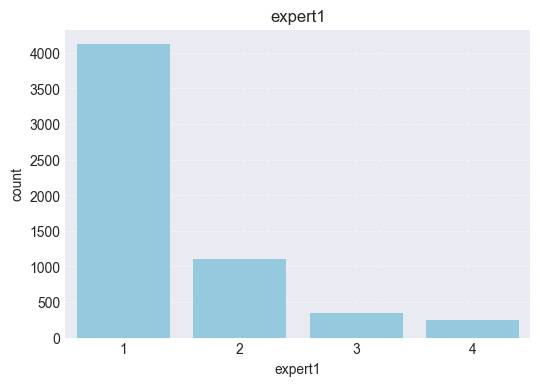

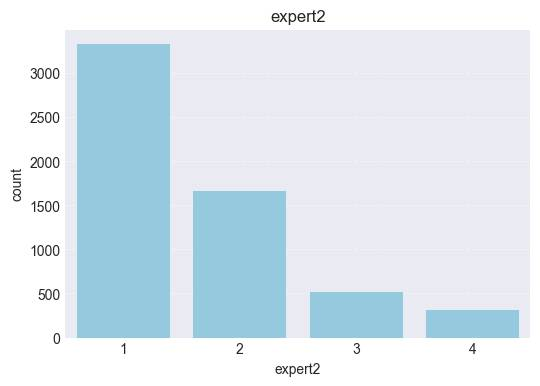

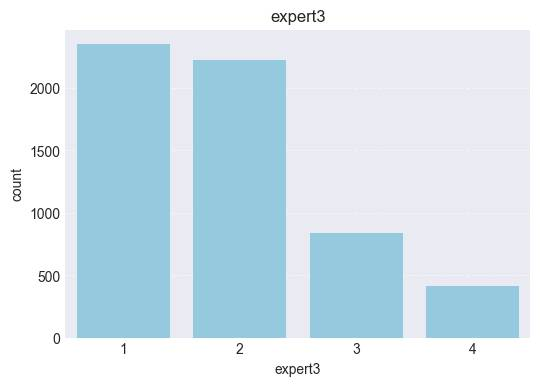

In [20]:
check_df(expert_df)

### Проверка формата и связей (expert_df)

In [21]:
# разберём caption_id
expert_df['image_from_caption_id'] = expert_df['caption_id'].str.split('#').str[0]
expert_df['caption_number'] = expert_df['caption_id'].str.split('#').str[1].astype(int)

print("проверка: совпадает ли image_file с image_from_caption_id:")
print(f"совпадений: {(expert_df['image_file'] == expert_df['image_from_caption_id']).sum()}")
print(f"всего строк: {len(expert_df)}")

# уникальные значения
print(f"\nуникальных изображений: {expert_df['image_file'].nunique()}")
print(f"уникальных caption_id: {expert_df['caption_id'].nunique()}")

проверка: совпадает ли image_file с image_from_caption_id:
совпадений: 158
всего строк: 5822

уникальных изображений: 1000
уникальных caption_id: 977


### Анализ экспертных оценок (expert_df)

In [22]:
# статистика по каждому эксперту
print("статистика оценок expert1:")
display(expert_df['expert1'].describe())
print("\nстатистика оценок expert2:")
display(expert_df['expert2'].describe())
print("\nстатистика оценок expert3:")
display(expert_df['expert3'].describe())

# распределение оценок каждого эксперта
print("\nраспределение оценок expert1:")
display(expert_df['expert1'].value_counts().sort_index())
print("\nраспределение оценок expert2:")
display(expert_df['expert2'].value_counts().sort_index())
print("\nраспределение оценок expert3:")
display(expert_df['expert3'].value_counts().sort_index())

статистика оценок expert1:


count    5822.000000
mean        1.436620
std         0.787084
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: expert1, dtype: float64


статистика оценок expert2:


count    5822.000000
mean        1.624356
std         0.856222
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: expert2, dtype: float64


статистика оценок expert3:


count    5822.000000
mean        1.881999
std         0.904087
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         4.000000
Name: expert3, dtype: float64


распределение оценок expert1:


expert1
1    4120
2    1109
3     346
4     247
Name: count, dtype: int64


распределение оценок expert2:


expert2
1    3327
2    1666
3     518
4     311
Name: count, dtype: int64


распределение оценок expert3:


expert3
1    2350
2    2222
3     837
4     413
Name: count, dtype: int64

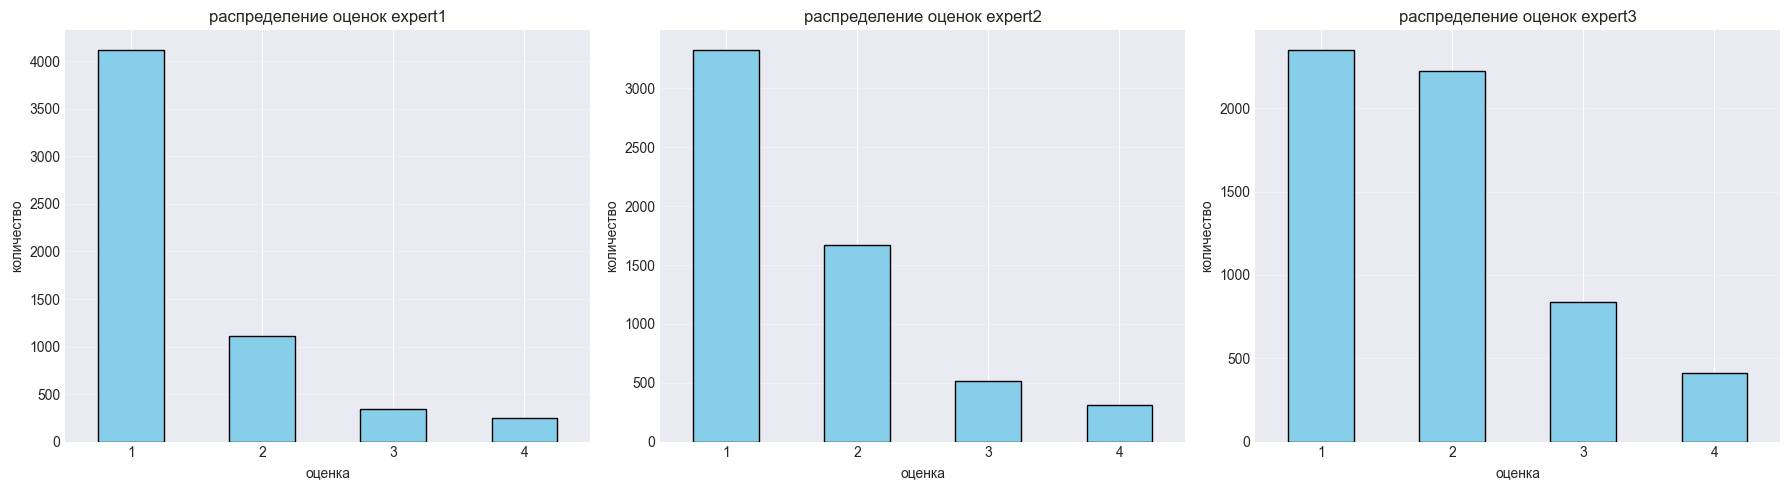

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, expert in enumerate(['expert1', 'expert2', 'expert3']):
    expert_df[expert].value_counts().sort_index().plot(kind='bar', ax=axes[idx], color='skyblue', edgecolor='black')
    axes[idx].set_xlabel('оценка')
    axes[idx].set_ylabel('количество')
    axes[idx].set_title(f'распределение оценок {expert}')
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].set_xticklabels([1, 2, 3, 4], rotation=0)

plt.tight_layout()
plt.show()

### Согласие между экспертами (expert_df)

корреляция между оценками экспертов:


expert1   expert2   expert3
expert1  1.000000  0.885036  0.796189
expert2  0.885036  1.000000  0.874369
expert3  0.796189  0.874369  1.000000

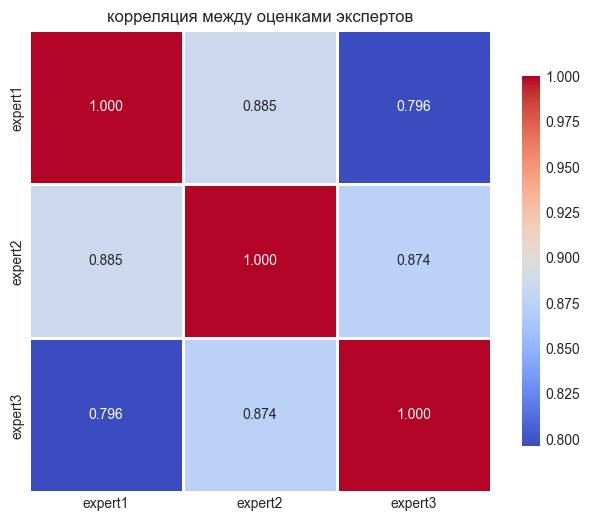

In [24]:
# корреляция между экспертами
correlation = expert_df[['expert1', 'expert2', 'expert3']].corr()
print("корреляция между оценками экспертов:")
display(correlation)

# визуализация корреляции
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, fmt='.3f', cmap='coolwarm', 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('корреляция между оценками экспертов')
plt.show()

### Анализ разброса оценок (expert_df)

распределение разброса оценок:
expert_range
0    3391
1    2272
2     156
3       3
Name: count, dtype: int64


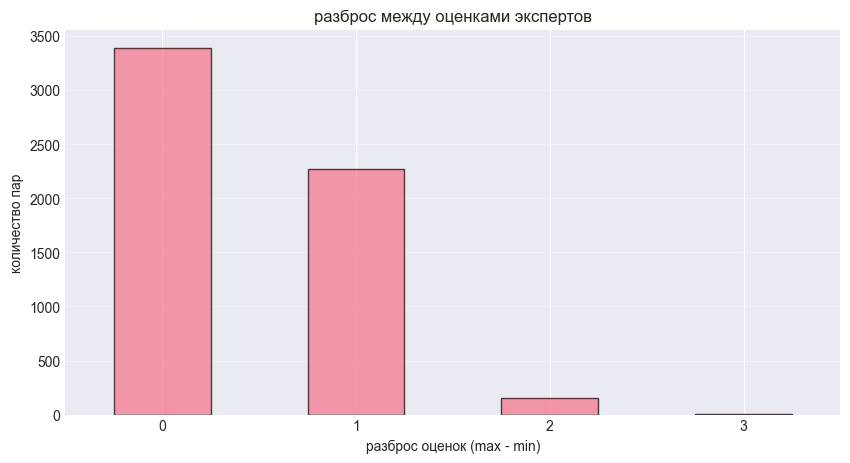


примеры с максимальным разбросом (эксперты не согласны):


image_file                   caption_id  expert1  \
3956  3388330419_85d72f7cda.jpg  3358558292_6ab14193ed.jpg#2        1   
5561   542179694_e170e9e465.jpg   300577375_26cc2773a1.jpg#2        1   
5573   542317719_ed4dd95dc2.jpg   542317719_ed4dd95dc2.jpg#2        1   

      expert2  expert3      image_from_caption_id  caption_number  expert_max  \
3956        2        4  3358558292_6ab14193ed.jpg               2           4   
5561        2        4   300577375_26cc2773a1.jpg               2           4   
5573        4        4   542317719_ed4dd95dc2.jpg               2           4   

      expert_min  expert_range  
3956           1             3  
5561           1             3  
5573           1             3

In [25]:
# разница между максимальной и минимальной оценкой для каждой пары
expert_df['expert_max'] = expert_df[['expert1', 'expert2', 'expert3']].max(axis=1)
expert_df['expert_min'] = expert_df[['expert1', 'expert2', 'expert3']].min(axis=1)
expert_df['expert_range'] = expert_df['expert_max'] - expert_df['expert_min']

print("распределение разброса оценок:")
print(expert_df['expert_range'].value_counts().sort_index())

plt.figure(figsize=(10, 5))
expert_df['expert_range'].value_counts().sort_index().plot(kind='bar', edgecolor='black', alpha=0.7)
plt.xlabel('разброс оценок (max - min)')
plt.ylabel('количество пар')
plt.title('разброс между оценками экспертов')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()

# примеры с максимальным разбросом
print("\nпримеры с максимальным разбросом (эксперты не согласны):")
display(expert_df[expert_df['expert_range'] == expert_df['expert_range'].max()].head(5))

### Количество описаний на изображение (expert_df)

распределение количества описаний на изображение (эксперты):
count
2       8
3      49
4     157
5     228
6     233
7     164
8     114
9      37
10     10
Name: count, dtype: int64


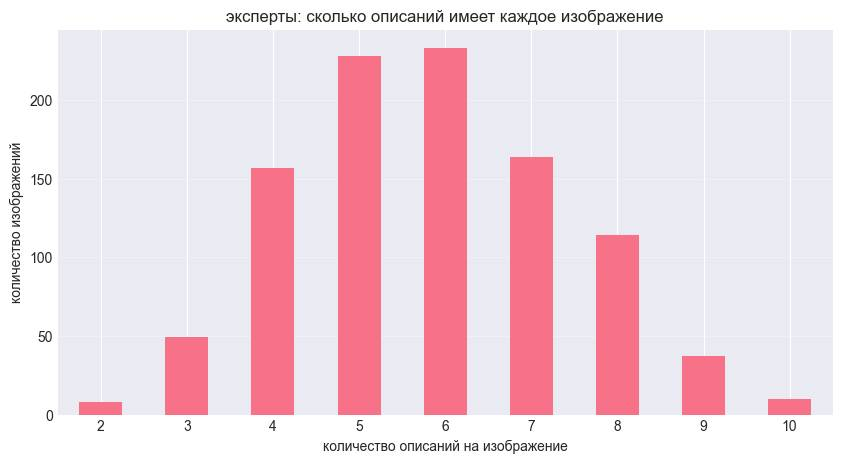

In [26]:
# сколько описаний у каждого изображения
captions_per_image_expert = expert_df['image_file'].value_counts()
print("распределение количества описаний на изображение (эксперты):")
print(captions_per_image_expert.value_counts().sort_index())

plt.figure(figsize=(10, 5))
captions_per_image_expert.value_counts().sort_index().plot(kind='bar')
plt.xlabel('количество описаний на изображение')
plt.ylabel('количество изображений')
plt.title('эксперты: сколько описаний имеет каждое изображение')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()

### Примеры оценок (expert_df)

In [27]:
# функция для показа изображений с экспертными оценками
def show_expert_examples(df_subset, title, n_show=5):
    """
    показывает изображения с экспертными оценками
    
    параметры:
    - df_subset: подмножество датафрейма expert_df
    - title: заголовок группы
    - n_show: количество примеров для показа
    """
    print(f"\n{'='*80}")
    print(f"{title}")
    print(f"{'='*80}\n")
    
    n = min(len(df_subset), n_show)
    fig, axes = plt.subplots(1, n, figsize=(5*n, 5))
    
    if n == 1:
        axes = [axes]
    
    for idx, (_, row) in enumerate(df_subset.head(n).iterrows()):
        image_path = os.path.join(train_images_dir, row['image_file'])
        
        if os.path.exists(image_path):
            img = Image.open(image_path)
            axes[idx].imshow(img)
            axes[idx].axis('off')
            
            # получаем текст описания
            text_match = train_df[train_df['query_id'] == row['caption_id']]
            if len(text_match) > 0:
                query_text = text_match.iloc[0]['query_text']
            else:
                query_text = "текст не найден"
            
            # цвет в зависимости от оценок
            avg_score = (row['expert1'] + row['expert2'] + row['expert3']) / 3
            if avg_score >= 3.5:
                color = 'darkgreen'
            elif avg_score >= 2.5:
                color = 'green'
            elif avg_score >= 1.5:
                color = 'orange'
            else:
                color = 'red'
            
            # проверяем разброс оценок
            if 'expert_range' in row:
                range_info = f"разброс: {row['expert_range']}"
            else:
                range_info = ""
            
            text_info = (
                f"оценки: [{row['expert1']}, {row['expert2']}, {row['expert3']}]\n"
                f"{range_info}\n\n"
                f"{query_text[:70]}..."
            )
            axes[idx].set_title(text_info, fontsize=9, color=color)
        else:
            axes[idx].text(0.5, 0.5, f'изображение не найдено:\n{row["image_file"]}', 
                          ha='center', va='center')
            axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # выводим полную информацию
    print("\nподробная информация:")
    for idx, (_, row) in enumerate(df_subset.head(n).iterrows()):
        text_match = train_df[train_df['query_id'] == row['caption_id']]
        if len(text_match) > 0:
            query_text = text_match.iloc[0]['query_text']
        else:
            query_text = "текст не найден"
        
        print(f"\n{idx+1}. изображение: {row['image_file']}")
        print(f"   caption_id: {row['caption_id']}")
        print(f"   оценки экспертов: expert1={row['expert1']}, expert2={row['expert2']}, expert3={row['expert3']}")
        if 'expert_range' in row:
            print(f"   разброс оценок: {row['expert_range']}")
        print(f"   описание: {query_text}")

примеры с полным согласием экспертов (все поставили 4):


image_file                   caption_id  expert1  expert2  \
43   1119015538_e8e796281e.jpg   416106657_cab2a107a5.jpg#2        4        4   
53   1131932671_c8d17751b3.jpg  1131932671_c8d17751b3.jpg#2        4        4   
66    115684808_cb01227802.jpg   115684808_cb01227802.jpg#2        4        4   
80   1174629344_a2e1a2bdbf.jpg  1174629344_a2e1a2bdbf.jpg#2        4        4   
187  1322323208_c7ecb742c6.jpg  1322323208_c7ecb742c6.jpg#2        4        4   

     expert3      image_from_caption_id  caption_number  expert_max  \
43         4   416106657_cab2a107a5.jpg               2           4   
53         4  1131932671_c8d17751b3.jpg               2           4   
66         4   115684808_cb01227802.jpg               2           4   
80         4  1174629344_a2e1a2bdbf.jpg               2           4   
187        4  1322323208_c7ecb742c6.jpg               2           4   

     expert_min  expert_range  
43            4             0  
53            4             0  
66            4             0  
80            4             0  
187           4             0


ПОЛНОЕ СОГЛАСИЕ: ВСЕ ЭКСПЕРТЫ ПОСТАВИЛИ 4



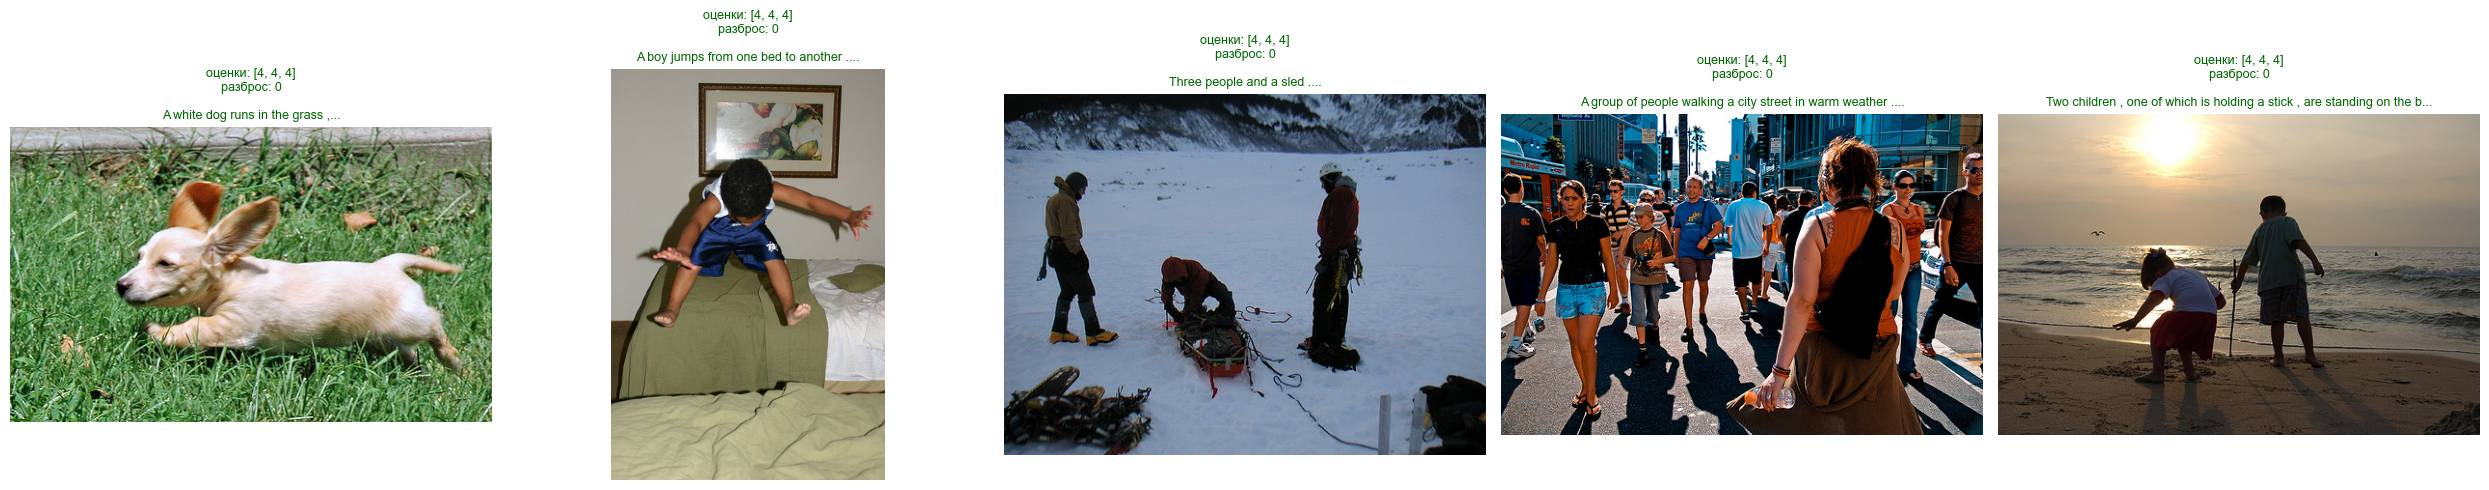


подробная информация:

1. изображение: 1119015538_e8e796281e.jpg
   caption_id: 416106657_cab2a107a5.jpg#2
   оценки экспертов: expert1=4, expert2=4, expert3=4
   разброс оценок: 0
   описание: A white dog runs in the grass ,

2. изображение: 1131932671_c8d17751b3.jpg
   caption_id: 1131932671_c8d17751b3.jpg#2
   оценки экспертов: expert1=4, expert2=4, expert3=4
   разброс оценок: 0
   описание: A boy jumps from one bed to another .

3. изображение: 115684808_cb01227802.jpg
   caption_id: 115684808_cb01227802.jpg#2
   оценки экспертов: expert1=4, expert2=4, expert3=4
   разброс оценок: 0
   описание: Three people and a sled .

4. изображение: 1174629344_a2e1a2bdbf.jpg
   caption_id: 1174629344_a2e1a2bdbf.jpg#2
   оценки экспертов: expert1=4, expert2=4, expert3=4
   разброс оценок: 0
   описание: A group of people walking a city street in warm weather .

5. изображение: 1322323208_c7ecb742c6.jpg
   caption_id: 1322323208_c7ecb742c6.jpg#2
   оценки экспертов: expert1=4, expert2=4, exper

image_file                   caption_id  expert1  expert2  \
0   1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2        1        1   
5   1056338697_4f7d7ce270.jpg  3360930596_1e75164ce6.jpg#2        1        1   
6   1056338697_4f7d7ce270.jpg  3545652636_0746537307.jpg#2        1        1   
8    106490881_5a2dd9b7bd.jpg  1425069308_488e5fcf9d.jpg#2        1        1   
11   106490881_5a2dd9b7bd.jpg  2398605966_1d0c9e6a20.jpg#2        1        1   

    expert3      image_from_caption_id  caption_number  expert_max  \
0         1  2549968784_39bfbe44f9.jpg               2           1   
5         1  3360930596_1e75164ce6.jpg               2           1   
6         1  3545652636_0746537307.jpg               2           1   
8         1  1425069308_488e5fcf9d.jpg               2           1   
11        1  2398605966_1d0c9e6a20.jpg               2           1   

    expert_min  expert_range  
0            1             0  
5            1             0  
6            1             0  
8            1             0  
11           1             0


ПОЛНОЕ НЕСООТВЕТСТВИЕ: ВСЕ ЭКСПЕРТЫ ПОСТАВИЛИ 1



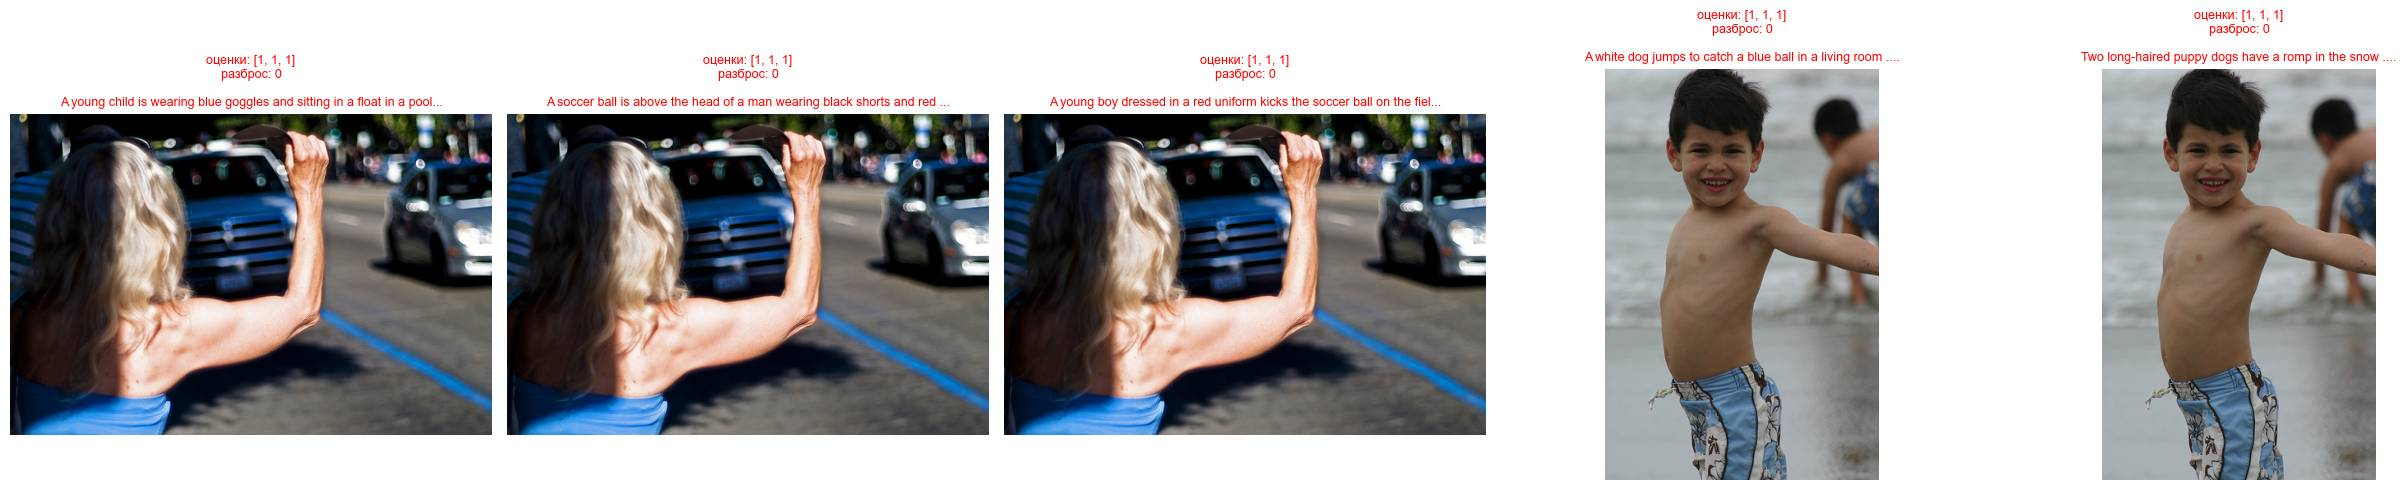


подробная информация:

1. изображение: 1056338697_4f7d7ce270.jpg
   caption_id: 2549968784_39bfbe44f9.jpg#2
   оценки экспертов: expert1=1, expert2=1, expert3=1
   разброс оценок: 0
   описание: A young child is wearing blue goggles and sitting in a float in a pool .

2. изображение: 1056338697_4f7d7ce270.jpg
   caption_id: 3360930596_1e75164ce6.jpg#2
   оценки экспертов: expert1=1, expert2=1, expert3=1
   разброс оценок: 0
   описание: A soccer ball is above the head of a man wearing black shorts and red and black striped shirt .

3. изображение: 1056338697_4f7d7ce270.jpg
   caption_id: 3545652636_0746537307.jpg#2
   оценки экспертов: expert1=1, expert2=1, expert3=1
   разброс оценок: 0
   описание: A young boy dressed in a red uniform kicks the soccer ball on the field as another child in blue watches from behind .

4. изображение: 106490881_5a2dd9b7bd.jpg
   caption_id: 1425069308_488e5fcf9d.jpg#2
   оценки экспертов: expert1=1, expert2=1, expert3=1
   разброс оценок: 0
   описание

image_file                   caption_id  expert1  \
544    172097782_f0844ec317.jpg  3641022607_e7a5455d6c.jpg#2        3   
1894  2621415349_ef1a7e73be.jpg  2675685200_0913d84d9b.jpg#2        1   
5546   539751252_2bd88c456b.jpg  3564543247_05cdbc31cf.jpg#2        2   
4923  3694093650_547259731e.jpg  2204550058_2707d92338.jpg#2        1   
3624  3263395801_5e4cee2b9e.jpg  1554713437_61b64527dd.jpg#2        1   
506   1659358141_0433c9bf99.jpg  2774430374_fee1d793e7.jpg#2        1   
5106   405615014_03be7ef618.jpg  2666205903_8d287669e1.jpg#2        1   
3805  3339140382_2e49bc324a.jpg  3123351642_3794f2f601.jpg#2        1   
408   1490213660_9ea45550cf.jpg  3070011270_390e597783.jpg#2        2   
4108  3437654963_c4fdc17e8b.jpg   197107117_4b438b1872.jpg#2        1   

      expert2  expert3  expert_range  
544         4        4             1  
1894        1        2             1  
5546        3        3             1  
4923        1        1             0  
3624        2        2             1  
506         1        1             0  
5106        1        2             1  
3805        1        2             1  
408         2        3             1  
4108        1        1             0


СМЕШАННЫЕ ОЦЕНКИ (случайная выборка)



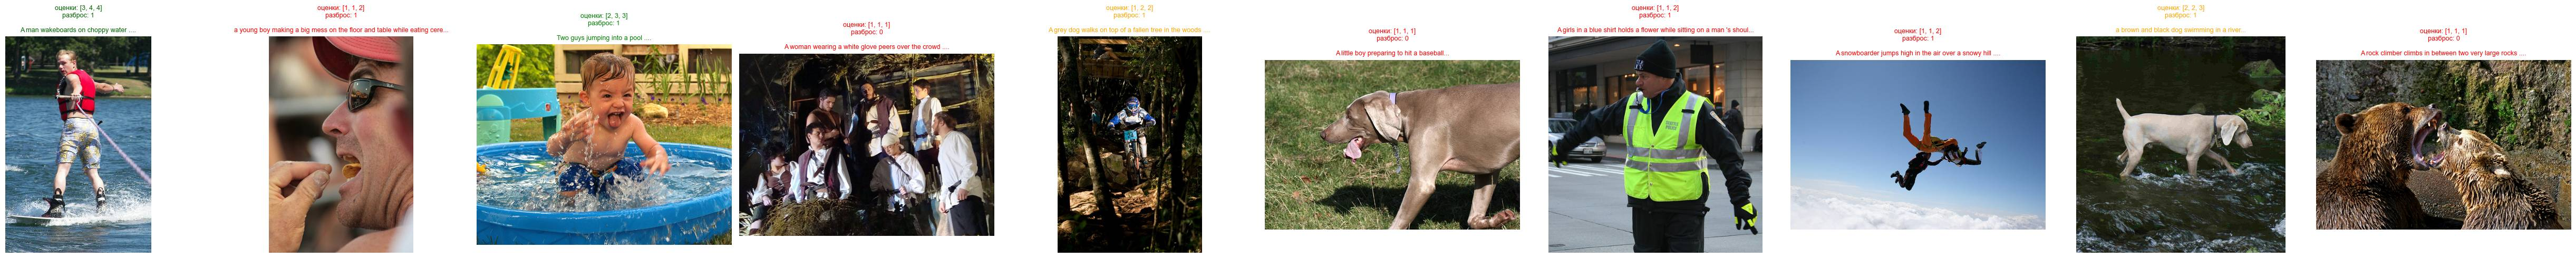


подробная информация:

1. изображение: 172097782_f0844ec317.jpg
   caption_id: 3641022607_e7a5455d6c.jpg#2
   оценки экспертов: expert1=3, expert2=4, expert3=4
   разброс оценок: 1
   описание: A man wakeboards on choppy water .

2. изображение: 2621415349_ef1a7e73be.jpg
   caption_id: 2675685200_0913d84d9b.jpg#2
   оценки экспертов: expert1=1, expert2=1, expert3=2
   разброс оценок: 1
   описание: a young boy making a big mess on the floor and table while eating cereal

3. изображение: 539751252_2bd88c456b.jpg
   caption_id: 3564543247_05cdbc31cf.jpg#2
   оценки экспертов: expert1=2, expert2=3, expert3=3
   разброс оценок: 1
   описание: Two guys jumping into a pool .

4. изображение: 3694093650_547259731e.jpg
   caption_id: 2204550058_2707d92338.jpg#2
   оценки экспертов: expert1=1, expert2=1, expert3=1
   разброс оценок: 0
   описание: A woman wearing a white glove peers over the crowd .

5. изображение: 3263395801_5e4cee2b9e.jpg
   caption_id: 1554713437_61b64527dd.jpg#2
   оценки

In [28]:
# примеры с полным согласием экспертов (все поставили 4)
print("примеры с полным согласием экспертов (все поставили 4):")
perfect_match = expert_df[(expert_df['expert1'] == 4) & 
                          (expert_df['expert2'] == 4) & 
                          (expert_df['expert3'] == 4)].head(5)
display(perfect_match)
show_expert_examples(perfect_match, "ПОЛНОЕ СОГЛАСИЕ: ВСЕ ЭКСПЕРТЫ ПОСТАВИЛИ 4")

# примеры с полным несоответствием (все поставили 1)
print("\nпримеры с полным несоответствием (все поставили 1):")
no_match = expert_df[(expert_df['expert1'] == 1) & 
                     (expert_df['expert2'] == 1) & 
                     (expert_df['expert3'] == 1)].head(5)
display(no_match)
show_expert_examples(no_match, "ПОЛНОЕ НЕСООТВЕТСТВИЕ: ВСЕ ЭКСПЕРТЫ ПОСТАВИЛИ 1")

# примеры со смешанными оценками
print("\nпримеры со смешанными оценками:")
mixed_ratings = expert_df.sample(10, random_state=42)[['image_file', 'caption_id', 
                                                         'expert1', 'expert2', 'expert3', 'expert_range']]
display(mixed_ratings)
show_expert_examples(mixed_ratings, "СМЕШАННЫЕ ОЦЕНКИ (случайная выборка)", n_show=10)


### Сравнение с краудсорсингом (expert_df и crowd_df)

In [29]:
# проверим пересечение по caption_id
expert_captions = set(expert_df['caption_id'].unique())
crowd_captions = set(crowd_df['caption_id'].unique())

print(f"caption_id в expert_df: {len(expert_captions)}")
print(f"caption_id в crowd_df: {len(crowd_captions)}")
print(f"пересечение: {len(expert_captions & crowd_captions)}")
print(f"только в expert_df: {len(expert_captions - crowd_captions)}")
print(f"только в crowd_df: {len(crowd_captions - expert_captions)}")

caption_id в expert_df: 977
caption_id в crowd_df: 1000
пересечение: 977
только в expert_df: 0
только в crowd_df: 23


### Сравнение с train_df

Так как у меня подозрение, что train_df и expert_df идентичны, выполним проверки.

In [30]:
# переименуем колонки train_df для сравнения
train_check = train_df[['image', 'query_id', 'query_text']].copy()
train_check.columns = ['image_file', 'caption_id', 'query_text']

# переименуем колонки expert_df для сравнения
expert_check = expert_df[['image_file', 'caption_id']].copy()

# проверим: есть ли все пары из train_df в expert_df?
train_pairs = set(zip(train_check['image_file'], train_check['caption_id']))
expert_pairs = set(zip(expert_check['image_file'], expert_check['caption_id']))

print(f"пар в train_df: {len(train_pairs)}")
print(f"пар в expert_df: {len(expert_pairs)}")
print(f"пересечение пар: {len(train_pairs & expert_pairs)}")
print(f"пар только в train_df: {len(train_pairs - expert_pairs)}")
print(f"пар только в expert_df: {len(expert_pairs - train_pairs)}")

# проверим: идентичны ли они полностью?
if train_pairs == expert_pairs:
    print("\n✅ ПАРЫ ПОЛНОСТЬЮ ИДЕНТИЧНЫ!")
    print("train_df и expert_df описывают одни и те же комбинации (изображение, описание)")
else:
    print("\n❌ ПАРЫ РАЗНЫЕ!")

пар в train_df: 5822
пар в expert_df: 5822
пересечение пар: 5822
пар только в train_df: 0
пар только в expert_df: 0

✅ ПАРЫ ПОЛНОСТЬЮ ИДЕНТИЧНЫ!
train_df и expert_df описывают одни и те же комбинации (изображение, описание)


In [31]:
# создадим словарь: caption_id -> query_text из train_df
train_texts = dict(zip(train_df['query_id'], train_df['query_text']))

# проверим несколько caption_id из expert_df
print("проверим, одинаковые ли тексты для одних и тех же caption_id:\n")

# возьмём первые 5 caption_id из expert_df
for caption_id in expert_df['caption_id'].head(5):
    if caption_id in train_texts:
        print(f"caption_id: {caption_id}")
        print(f"текст из train_df: {train_texts[caption_id][:50]}...")
        print("✅ caption_id есть в train_df\n")
    else:
        print(f"caption_id: {caption_id}")
        print("❌ caption_id НЕТ в train_df\n")

проверим, одинаковые ли тексты для одних и тех же caption_id:

caption_id: 2549968784_39bfbe44f9.jpg#2
текст из train_df: A young child is wearing blue goggles and sitting ...
✅ caption_id есть в train_df

caption_id: 2718495608_d8533e3ac5.jpg#2
текст из train_df: A girl wearing a yellow shirt and sunglasses smile...
✅ caption_id есть в train_df

caption_id: 3181701312_70a379ab6e.jpg#2
текст из train_df: A man sleeps under a blanket on a city street ....
✅ caption_id есть в train_df

caption_id: 3207358897_bfa61fa3c6.jpg#2
текст из train_df: A woman plays with long red ribbons in an empty sq...
✅ caption_id есть в train_df

caption_id: 3286822339_5535af6b93.jpg#2
текст из train_df: Chinese market street in the winter time ....
✅ caption_id есть в train_df



Проверки показали, что train_df - это просто expert_df без оценок. Эти файлы можно объединить и получить одну расширенную матрицу для дальшнейшего анализа.

## Вывод по expert_df

Выводы по ExpertAnnotations.tsv
📊 Основные характеристики:

Объём данных:

Всего 5822 экспертные оценки (точно как в train_df!)
1000 уникальных изображений
977 уникальных caption_id (тоже как в train_df!)
Только 158 совпадений image_file с image_from_caption_id (158/5822 = 2.7%)


Структура данных — КЛЮЧЕВОЕ ОТКРЫТИЕ! 🔑
Сравним три файла:
ФайлСтрокУникальных caption_idОписаний на изображениеtrain_df58229772-10expert_df58229772-10crowd_df47830100010-120
ЭТО ЗНАЧИТ:

train_df и expert_df — это одно и то же!
В train_df колонка image — это изображения-кандидаты для поиска
В train_df колонка query_id и query_text — это запросы
В expert_df эксперты оценили именно эти же пары (изображение-кандидат + запрос)
crowd_df содержит гораздо больше оценок — расширенная матрица



📈 Характеристики экспертных оценок:

Распределение оценок:

Expert1: средняя оценка 1.44 (самый строгий)
Expert2: средняя оценка 1.62
Expert3: средняя оценка 1.88 (самый мягкий)

Все эксперты склонны ставить низкие оценки (1-2), что логично — большинство пар действительно не соответствуют друг другу.
Использование шкалы:

Оценка 1 (полное несоответствие): 4120, 3327, 2350 случаев
Оценка 2 (частичное соответствие): 1109, 1666, 2222 случаев
Оценка 3 (хорошее соответствие): 346, 518, 837 случаев
Оценка 4 (полное соответствие): 247, 311, 413 случаев

Expert3 более щедрый на высокие оценки!
Согласие между экспертами — ОТЛИЧНО! ✅

Корреляция:

Expert1 ↔ Expert2: 0.885 (очень высокая!)
Expert1 ↔ Expert3: 0.796 (высокая)
Expert2 ↔ Expert3: 0.874 (очень высокая!)



Эксперты в целом согласны друг с другом, что говорит о качественной разметке.
Разброс оценок:

Разброс 0 (все согласны): 3391 случаев (58.3%)
Разброс 1: 2272 случаев (39.0%)
Разброс 2: 156 случаев (2.7%)
Разброс 3 (максимальное расхождение): всего 3 случая!

В большинстве случаев эксперты либо полностью согласны, либо расходятся на 1 балл.

🔗 Связи между датасетами:

Пересечение с краудсорсингом:

Все 977 caption_id из expert_df есть в crowd_df
В crowd_df есть дополнительные 23 caption_id
Вывод: Эксперты оценили подмножество пар, краудворкеры оценили больше


Итоговая структура данных:

   1000 изображений
   └─ у каждого изображения есть описания (captions)
   
   Для обучения:
   ├─ expert_df: 977 пар (изображение + чужое описание) с экспертными оценками 1-4
   └─ crowd_df: 1000 пар с краудсорсинговыми оценками (доля согласия)
   
   Для тестирования:
   └─ train_df: те же 977 пар, что и в expert_df (это тестовый набор!)

🚨 КРИТИЧЕСКОЕ УТОЧНЕНИЕ структуры!
Теперь понимаю структуру задачи:
train_df — это НЕ обучающие данные, а ТЕСТОВЫЕ данные! (Название файла вводит в заблуждение)
Настоящие обучающие данные — это:

expert_df с оценками экспертов
crowd_df с оценками краудворкеров

На этих оценках мы обучим модель предсказывать соответствие изображения и текста.
Потом протестируем на test_queries.csv.

У нас есть 5822 пары (изображение, описание)
train_df содержит тексты этих описаний
expert_df содержит оценки экспертов для этих же пар
Это один и тот же датасет, просто разбитый на два файла

Вывод: Нам нужно объединить эти два файла в один, чтобы получить полноценный датасет для обучения.

## Загрузка данных (test_queries.csv)

In [32]:
# загрузка test_queries
try:
    test_df = pd.read_csv(os.path.join(data_dir, 'test_queries.csv'), sep='|', index_col=0)
    print('train_dataset загружено локально')
except:
    test_df = pd.read_csv('https://code.s3.yandex.net/datasets/dsplus_integrated_project_4/to_upload/test_queries.csv')
    print('train_dataset загружено удаленно')

train_dataset загружено локально


### Первичный осмотр (test_df)

In [33]:
check_df(test_df)

info:
<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


None

head:


query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

describe:


query_id  \
count                           500   
unique                          500   
top     1177994172_10d143cb8d.jpg#0   
freq                              1   

                                               query_text  \
count                                                 500   
unique                                                500   
top     Two blonde boys , one in a camouflage shirt an...   
freq                                                    1   

                            image  
count                         500  
unique                        100  
top     1177994172_10d143cb8d.jpg  
freq                            5

nulls:


query_id      0
query_text    0
image         0
dtype: int64

duplicates:


np.int64(0)

### Анализ структуры (test_df)

In [34]:
print(f"количество тестовых запросов: {len(test_df)}")
print(f"уникальных query_id: {test_df['query_id'].nunique()}")
print(f"уникальных query_text: {test_df['query_text'].nunique()}")
print(f"уникальных relevant_image: {test_df['image'].nunique()}")

# проверим формат query_id
print("\nпримеры query_id:")
display(test_df['query_id'].head(10))

# длины текстов
test_df['text_length'] = test_df['query_text'].str.len()
test_df['word_count'] = test_df['query_text'].str.split().str.len()

print("\nстатистика длины запросов:")
display(test_df[['text_length', 'word_count']].describe())

количество тестовых запросов: 500
уникальных query_id: 500
уникальных query_text: 500
уникальных relevant_image: 100

примеры query_id:


0    1177994172_10d143cb8d.jpg#0
1    1177994172_10d143cb8d.jpg#1
2    1177994172_10d143cb8d.jpg#2
3    1177994172_10d143cb8d.jpg#3
4    1177994172_10d143cb8d.jpg#4
5    1232148178_4f45cc3284.jpg#0
6    1232148178_4f45cc3284.jpg#1
7    1232148178_4f45cc3284.jpg#2
8    1232148178_4f45cc3284.jpg#3
9    1232148178_4f45cc3284.jpg#4
Name: query_id, dtype: object


статистика длины запросов:


text_length  word_count
count   500.000000  500.000000
mean     57.024000   12.196000
std      19.680194    4.116732
min      19.000000    4.000000
25%      43.000000    9.000000
50%      55.000000   12.000000
75%      68.250000   14.000000
max     135.000000   31.000000

In [35]:
# функция для показа тестовых изображений
def show_test_examples(df_subset, title, test_images_dir):
    """
    показывает тестовые изображения с их описаниями
    
    параметры:
    - df_subset: подмножество test_df
    - title: заголовок
    - test_images_dir: путь к папке с тестовыми изображениями
    """
    print(f"\n{'='*80}")
    print(f"{title}")
    print(f"{'='*80}\n")
    
    n = len(df_subset)
    fig, axes = plt.subplots(1, n, figsize=(5*n, 5))
    
    if n == 1:
        axes = [axes]
    
    for idx, (_, row) in enumerate(df_subset.iterrows()):
        image_path = os.path.join(test_images_dir, row['image'])
        
        if os.path.exists(image_path):
            img = Image.open(image_path)
            axes[idx].imshow(img)
            axes[idx].axis('off')
            
            # извлекаем номер описания из query_id
            caption_num = row['query_id'].split('#')[1]
            
            text_info = (
                f"описание #{caption_num}\n"
                f"длина: {row['text_length']} символов\n"
                f"слов: {row['word_count']}\n\n"
                f"{row['query_text'][:80]}..."
            )
            axes[idx].set_title(text_info, fontsize=9)
        else:
            axes[idx].text(0.5, 0.5, f'изображение не найдено:\n{row["image"]}', 
                          ha='center', va='center')
            axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # полная информация
    print("\nподробная информация:")
    for idx, (_, row) in enumerate(df_subset.iterrows()):
        print(f"\n{idx+1}. изображение: {row['image']}")
        print(f"   query_id: {row['query_id']}")
        print(f"   длина текста: {row['text_length']} символов, {row['word_count']} слов")
        print(f"   описание: {row['query_text']}")


проверка директории тестовых изображений: D:\dev\github\Study-ImageTextRetrieval\data\dsplus_integrated_project_4\to_upload\test_images
существует: True
примеры файлов: ['.DS_Store', '1177994172_10d143cb8d.jpg', '1232148178_4f45cc3284.jpg', '123997871_6a9ca987b1.jpg', '1319634306_816f21677f.jpg']

ПРИМЕРЫ ТЕСТОВЫХ ИЗОБРАЖЕНИЙ С ОПИСАНИЯМИ

изображение: 1177994172_10d143cb8d.jpg
количество описаний: 5

ИЗОБРАЖЕНИЕ: 1177994172_10d143cb8d.jpg



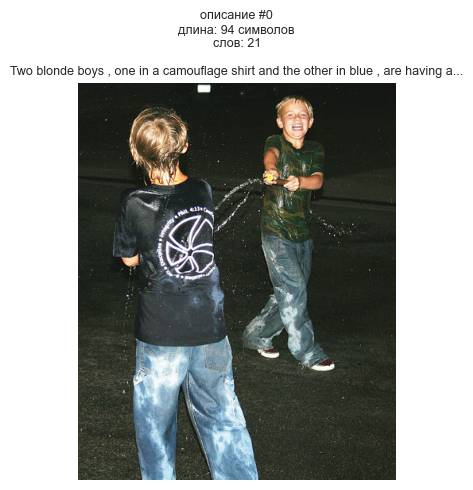


подробная информация:

1. изображение: 1177994172_10d143cb8d.jpg
   query_id: 1177994172_10d143cb8d.jpg#0
   длина текста: 94 символов, 21 слов
   описание: Two blonde boys , one in a camouflage shirt and the other in blue , are having a water fight .

все описания этого изображения:
  #0: Two blonde boys , one in a camouflage shirt and the other in blue , are having a water fight .
  #1: Two boys are squirting water guns at each other .
  #2: Two boys spraying each other with water
  #3: Two children wearing jeans squirt water at each other .
  #4: Two young boys are squirting water at each other .

изображение: 1232148178_4f45cc3284.jpg
количество описаний: 5

ИЗОБРАЖЕНИЕ: 1232148178_4f45cc3284.jpg



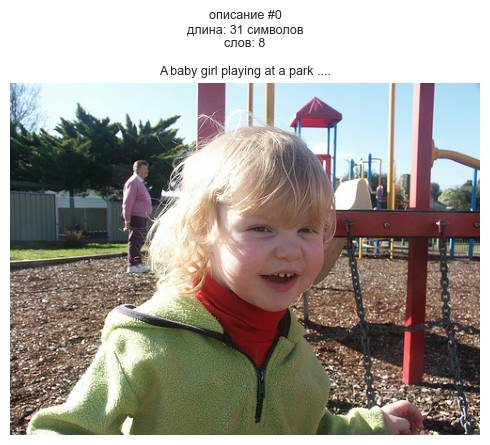


подробная информация:

1. изображение: 1232148178_4f45cc3284.jpg
   query_id: 1232148178_4f45cc3284.jpg#0
   длина текста: 31 символов, 8 слов
   описание: A baby girl playing at a park .

все описания этого изображения:
  #0: A baby girl playing at a park .
  #1: A closeup of a child on a playground with adult supervision .
  #2: A young boy poses for a picture in front of a playground .
  #3: A young girl is smiling in front of the camera at a park .
  #4: There is a little blond hair girl with a green sweatshirt and a red shirt playing on a playground .

изображение: 123997871_6a9ca987b1.jpg
количество описаний: 5

ИЗОБРАЖЕНИЕ: 123997871_6a9ca987b1.jpg



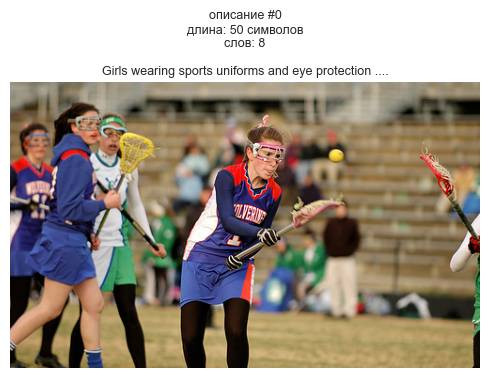


подробная информация:

1. изображение: 123997871_6a9ca987b1.jpg
   query_id: 123997871_6a9ca987b1.jpg#0
   длина текста: 50 символов, 8 слов
   описание: Girls wearing sports uniforms and eye protection .

все описания этого изображения:
  #0: Girls wearing sports uniforms and eye protection .
  #1: Several female lacrosse players are going after a ball .
  #2: These girls are in uniforms and are playing field hockey .
  #3: The woman lacrosse player in blue is about to catch the ball .
  #4: Women play lacrosse .

САМЫЕ КОРОТКИЕ И ДЛИННЫЕ ОПИСАНИЯ В ТЕСТОВОМ НАБОРЕ

самые короткие описания:


image           query_text  text_length
108  2431120202_b24fe2333a.jpg  Little girl on skis           19
177  2885891981_6b02620ae9.jpg  A boy on a BMX bike           19
274  3211199368_ca78387f72.jpg  a dog wears jeans .           19


САМЫЕ КОРОТКИЕ ОПИСАНИЯ



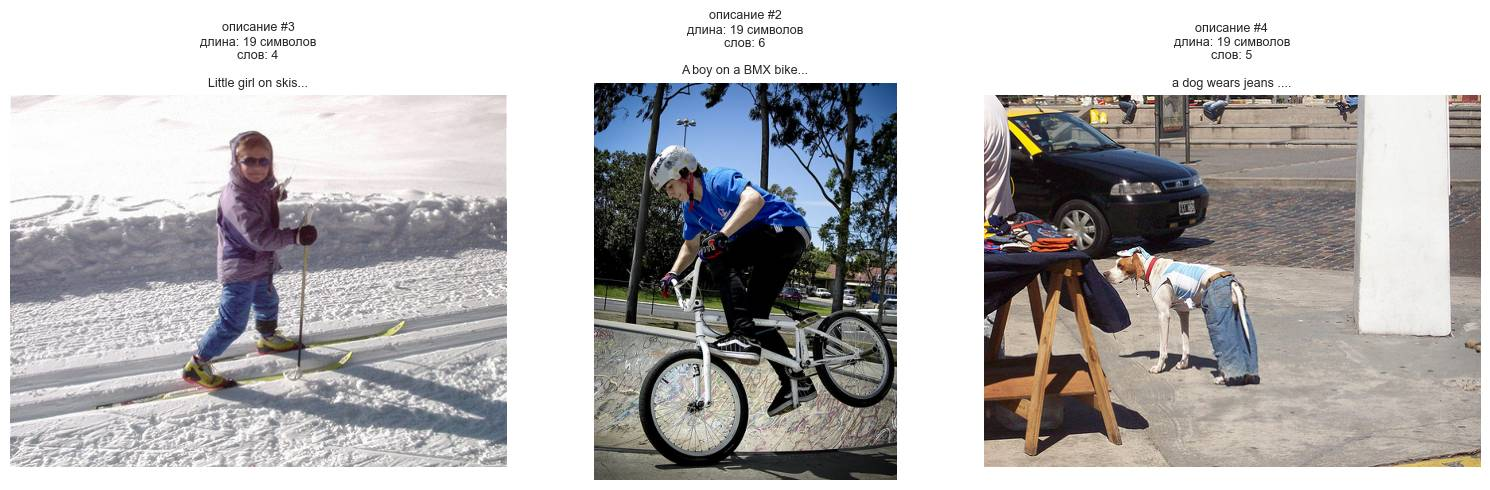


подробная информация:

1. изображение: 2431120202_b24fe2333a.jpg
   query_id: 2431120202_b24fe2333a.jpg#3
   длина текста: 19 символов, 4 слов
   описание: Little girl on skis

2. изображение: 2885891981_6b02620ae9.jpg
   query_id: 2885891981_6b02620ae9.jpg#2
   длина текста: 19 символов, 6 слов
   описание: A boy on a BMX bike

3. изображение: 3211199368_ca78387f72.jpg
   query_id: 3211199368_ca78387f72.jpg#4
   длина текста: 19 символов, 5 слов
   описание: a dog wears jeans .

самые длинные описания:


image  \
71   2141713971_e25eb12712.jpg   
201  3033612929_764d977bd5.jpg   
46    191003283_992257f835.jpg   

                                            query_text  text_length  
71   A woman and a younger girl , both wearing blue...          135  
201  A small white dog is carrying something blue i...          134  
46   A toddler boy in a red tank top and khaki shor...          128


САМЫЕ ДЛИННЫЕ ОПИСАНИЯ



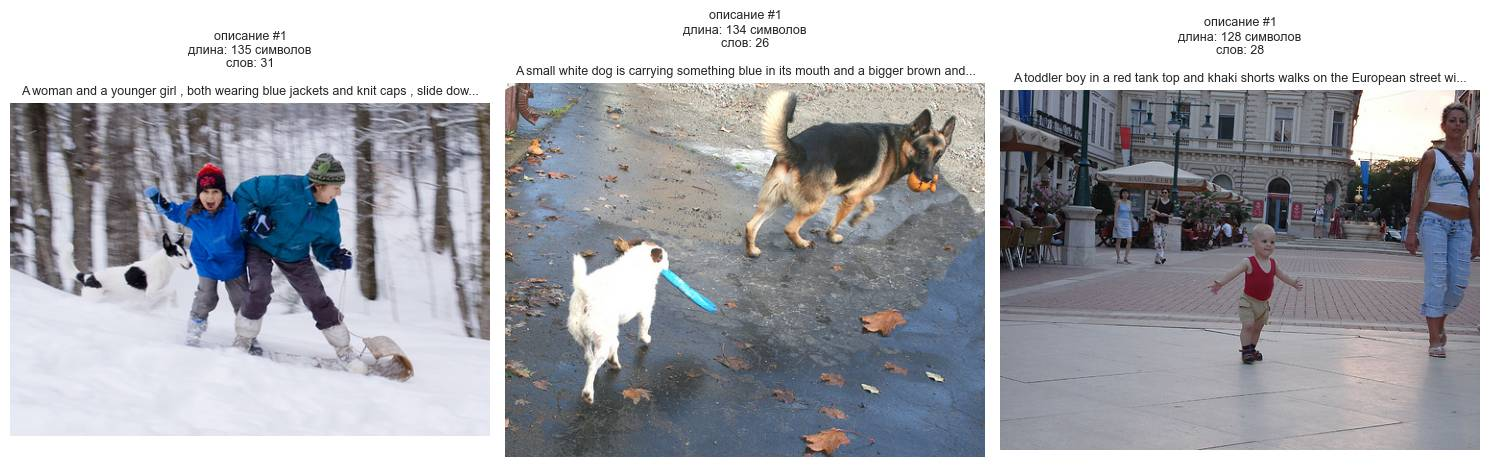


подробная информация:

1. изображение: 2141713971_e25eb12712.jpg
   query_id: 2141713971_e25eb12712.jpg#1
   длина текста: 135 символов, 31 слов
   описание: A woman and a younger girl , both wearing blue jackets and knit caps , slide down a hill on a snow sled , a dog running at their side .

2. изображение: 3033612929_764d977bd5.jpg
   query_id: 3033612929_764d977bd5.jpg#1
   длина текста: 134 символов, 26 слов
   описание: A small white dog is carrying something blue in its mouth and a bigger brown and black dog is carrying something orange in its mouth .

3. изображение: 191003283_992257f835.jpg
   query_id: 191003283_992257f835.jpg#1
   длина текста: 128 символов, 28 слов
   описание: A toddler boy in a red tank top and khaki shorts walks on the European street with a woman in a white top and faded blue jeans .


In [36]:
# проверяем путь к тестовым изображениям
test_images_dir = os.path.join(data_dir, 'test_images')
print(f"\nпроверка директории тестовых изображений: {test_images_dir}")
print(f"существует: {os.path.exists(test_images_dir)}")

if os.path.exists(test_images_dir):
    sample_files = os.listdir(test_images_dir)[:5]
    print(f"примеры файлов: {sample_files}")

# покажем несколько случайных изображений с их описаниями
print("\n" + "="*80)
print("ПРИМЕРЫ ТЕСТОВЫХ ИЗОБРАЖЕНИЙ С ОПИСАНИЯМИ")
print("="*80)

# возьмём несколько уникальных изображений
unique_images = test_df['image'].unique()[:3]

for img_name in unique_images:
    # все описания для этого изображения
    img_descriptions = test_df[test_df['image'] == img_name]
    
    print(f"\n{'='*80}")
    print(f"изображение: {img_name}")
    print(f"количество описаний: {len(img_descriptions)}")
    print(f"{'='*80}")
    
    # показываем изображение один раз с первым описанием
    show_test_examples(img_descriptions.head(1), f"ИЗОБРАЖЕНИЕ: {img_name}", test_images_dir)
    
    # выводим все 5 описаний текстом
    print("\nвсе описания этого изображения:")
    for idx, (_, row) in enumerate(img_descriptions.iterrows()):
        caption_num = row['query_id'].split('#')[1]
        print(f"  #{caption_num}: {row['query_text']}")

# покажем самые короткие и длинные описания
print("\n" + "="*80)
print("САМЫЕ КОРОТКИЕ И ДЛИННЫЕ ОПИСАНИЯ В ТЕСТОВОМ НАБОРЕ")
print("="*80)

shortest_test = test_df.nsmallest(3, 'text_length')
print("\nсамые короткие описания:")
display(shortest_test[['image', 'query_text', 'text_length']])
show_test_examples(shortest_test, "САМЫЕ КОРОТКИЕ ОПИСАНИЯ", test_images_dir)

longest_test = test_df.nlargest(3, 'text_length')
print("\nсамые длинные описания:")
display(longest_test[['image', 'query_text', 'text_length']])
show_test_examples(longest_test, "САМЫЕ ДЛИННЫЕ ОПИСАНИЯ", test_images_dir)

### Связи с другими файлами (test_df)

In [37]:
# проверим пересечение изображений
test_images = set(test_df['image'].unique())
train_images = set(train_df['image'].unique())
expert_images = set(expert_df['image_file'].unique())
crowd_images = set(crowd_df['image_file'].unique())

print("пересечение изображений:")
print(f"test с train: {len(test_images & train_images)}")
print(f"test с expert: {len(test_images & expert_images)}")
print(f"test с crowd: {len(test_images & crowd_images)}")

# проверим пересечение query_id
test_queries = set(test_df['query_id'].unique())
train_queries = set(train_df['query_id'].unique())
expert_captions_set = set(expert_df['caption_id'].unique())

print("\nпересечение query_id/caption_id:")
print(f"test с train: {len(test_queries & train_queries)}")
print(f"test с expert: {len(test_queries & expert_captions_set)}")

пересечение изображений:
test с train: 0
test с expert: 0
test с crowd: 0

пересечение query_id/caption_id:
test с train: 0
test с expert: 0


## Вывод по test_df

Выводы по test_queries.csv
📊 Основные характеристики:

Объём данных:

500 тестовых запросов
100 уникальных изображений
500 уникальных описаний
Структура: ровно 5 описаний на каждое изображение (500/100 = 5)


Формат query_id:

1177994172_10d143cb8d.jpg#0 — изображение + номер описания (0-4)
Это собственные описания изображений (не чужие!)


Характеристики текстов:

Средняя длина: 57 символов (12 слов)
Диапазон: 19-135 символов (4-31 слово)
Похоже на train_df по длине



🔑 КЛЮЧЕВОЕ ОТКРЫТИЕ:

Полная изоляция тестовых данных:

0 пересечений по изображениям с train/expert/crowd
0 пересечений по query_id с train/expert
Это совершенно новые 100 изображений для финального тестирования
Правильная структура для валидации модели!




🎯 ИТОГОВАЯ СТРУКТУРА ВСЕХ ДАННЫХ
Теперь собираем всю картину воедино:
Датасеты по назначению:
┌─────────────────────────────────────────────────────────────┐
│                    ОБУЧАЮЩИЕ ДАННЫЕ                         │
├─────────────────────────────────────────────────────────────┤
│ 1000 изображений для обучения                               │
│                                                              │
│ expert_df (5822 оценки)                                     │
│ ├─ 1000 изображений                                         │
│ ├─ 977 уникальных caption_id (описания)                     │
│ ├─ Оценки 3 экспертов (шкала 1-4)                          │
│ └─ Только 158 "правильных" пар (2.7%)                       │
│                                                              │
│ crowd_df (47830 оценок)                                     │
│ ├─ 1000 изображений (те же!)                                │
│ ├─ 1000 уникальных caption_id                               │
│ ├─ agreement_ratio (доля согласия краудворкеров)            │
│ └─ Расширенная матрица оценок                               │
└─────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────┐
│                  ВАЛИДАЦИОННЫЕ ДАННЫЕ                       │
├─────────────────────────────────────────────────────────────┤
│ train_df (5822 пары) — название вводит в заблуждение!      │
│ ├─ Это те же пары, что в expert_df                          │
│ ├─ Для каждого запроса есть несколько изображений-кандидатов│
│ └─ Можно использовать для подбора гиперпараметров           │
└─────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────┐
│                    ТЕСТОВЫЕ ДАННЫЕ                          │
├─────────────────────────────────────────────────────────────┤
│ test_df (500 запросов)                                      │
│ ├─ 100 НОВЫХ изображений (нет в обучающих данных!)          │
│ ├─ По 5 описаний на каждое изображение                      │
│ ├─ query_id + query_text + relevant_image                   │
│ └─ Для финального тестирования модели                       │
└─────────────────────────────────────────────────────────────┘
Структура задачи:
Что нам нужно сделать:

Обучить модель на expert_df и/или crowd_df:

Вход: векторы (изображение + текст)
Выход: оценка соответствия [0, 1]


Применить модель для поиска:

Получаем текстовый запрос
Векторизуем запрос
Векторизуем все изображения
Для каждой пары (запрос, изображение) предсказываем оценку
Возвращаем изображение с максимальной оценкой


Протестировать на test_df:

Для каждого из 500 запросов найти наиболее релевантное изображение
Сравнить с ground truth (колонка image)
Рассчитать метрики (MAP, NDCG, accuracy)




📊 Сводная статистика по всем файлам
ФайлСтрокУникальных изображенийУникальных описанийЦелевая переменнаяexpert_df5,8221,0009773 оценки (1-4)crowd_df47,8301,0001,000agreement_ratiotrain_df5,8221,000977нет (валидация)test_df500100 (новые!)500нет (тестирование)
Важные наблюдения:
✅ expert_df и train_df — идентичны по структуре (5822 строки, 977 описаний)
✅ Дисбаланс классов:

В expert_df: преобладают оценки 1-2 (плохое соответствие)
В crowd_df: 75% имеют agreement_ratio = 0

✅ Качество разметки:

Эксперты имеют высокую корреляцию (0.79-0.89) — надёжные оценки
Краудсорсинг имеет мало голосов (в среднем 3) — менее надёжен

✅ Правильная изоляция тестовых данных:

test_df содержит полностью новые изображения
Нет утечки данных (data leakage)

# Этап 1.2: Подготовка, агрегация данных и расширенный EDA

## Объединение train_df и expert_df

###  Объединение данных

In [40]:
# сначала создаём train_for_merge
train_for_merge = train_df[['image', 'query_id', 'query_text']].copy()
train_for_merge.columns = ['image_file', 'caption_id', 'query_text']

# теперь объединяем по ДВУМ ключам
master_df = expert_df.merge(
    train_for_merge[['image_file', 'caption_id', 'query_text']], 
    on=['image_file', 'caption_id'],
    how='left'
)

print(f"размер объединённого датасета: {master_df.shape}")
print(f"есть ли пропуски в query_text: {master_df['query_text'].isnull().sum()}")

print("\nпроверка корректности:")
print(f"строк в expert_df: {len(expert_df)}")
print(f"строк в master_df: {len(master_df)}")

if len(master_df) == len(expert_df):
    print("количество строк совпадает")
else:
    print(f"проблема: ожидали {len(expert_df)}, получили {len(master_df)}")

print("\nпервые строки:")
display(master_df[['image_file', 'caption_id', 'query_text', 'expert1', 'expert2', 'expert3']].head(10))

размер объединённого датасета: (5822, 11)
есть ли пропуски в query_text: 0

проверка корректности:
строк в expert_df: 5822
строк в master_df: 5822
количество строк совпадает

первые строки:


image_file                   caption_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2   
5  1056338697_4f7d7ce270.jpg  3360930596_1e75164ce6.jpg#2   
6  1056338697_4f7d7ce270.jpg  3545652636_0746537307.jpg#2   
7  1056338697_4f7d7ce270.jpg   434792818_56375e203f.jpg#2   
8   106490881_5a2dd9b7bd.jpg  1425069308_488e5fcf9d.jpg#2   
9   106490881_5a2dd9b7bd.jpg  1714316707_8bbaa2a2ba.jpg#2   

                                          query_text  expert1  expert2  \
0  A young child is wearing blue goggles and sitt...        1        1   
1  A girl wearing a yellow shirt and sunglasses s...        1        1   
2    A man sleeps under a blanket on a city street .        1        1   
3  A woman plays with long red ribbons in an empt...        1        2   
4         Chinese market street in the winter time .        1        1   
5  A soccer ball is above the head of a man weari...        1        1   
6  A young boy dressed in a red uniform kicks the...        1        1   
7  A man and woman look back at the camera while ...        1        1   
8  A white dog jumps to catch a blue ball in a li...        1        1   
9       A little boy shakes the snow off of a tree .        2        2   

   expert3  
0        1  
1        2  
2        2  
3        2  
4        2  
5        1  
6        1  
7        2  
8        1  
9        2

### Проверка объединения

In [41]:
# проверим, что всё правильно объединилось
print("проверка объединения:")
print(f"строк в expert_df: {len(expert_df)}")
print(f"строк в master_df: {len(master_df)}")
print(f"пропусков в query_text: {master_df['query_text'].isnull().sum()}")

# убедимся, что для одного изображения могут быть разные описания
print("\nпример: несколько пар для одного изображения:")
sample_image = master_df['image_file'].iloc[0]
display(master_df[master_df['image_file'] == sample_image][
    ['image_file', 'caption_id', 'query_text', 'expert1', 'expert2', 'expert3']
].head(3))

проверка объединения:
строк в expert_df: 5822
строк в master_df: 5822
пропусков в query_text: 0

пример: несколько пар для одного изображения:


image_file                   caption_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   

                                          query_text  expert1  expert2  \
0  A young child is wearing blue goggles and sitt...        1        1   
1  A girl wearing a yellow shirt and sunglasses s...        1        1   
2    A man sleeps under a blanket on a city street .        1        1   

   expert3  
0        1  
1        2  
2        2

## Агрегация экспертных оценок

### Агрегация оценок экспертов (по медиане)

статистика агрегированных оценок:

median:


count    5822.000000
mean        1.624356
std         0.856222
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: expert_median, dtype: float64


mean:


count    5822.000000
mean        1.647658
std         0.806205
min         1.000000
25%         1.000000
50%         1.333333
75%         2.000000
max         4.000000
Name: expert_mean, dtype: float64


normalized score [0, 1]:


count    5822.000000
mean        0.208119
std         0.285407
min         0.000000
25%         0.000000
50%         0.000000
75%         0.333333
max         1.000000
Name: expert_score_normalized, dtype: float64

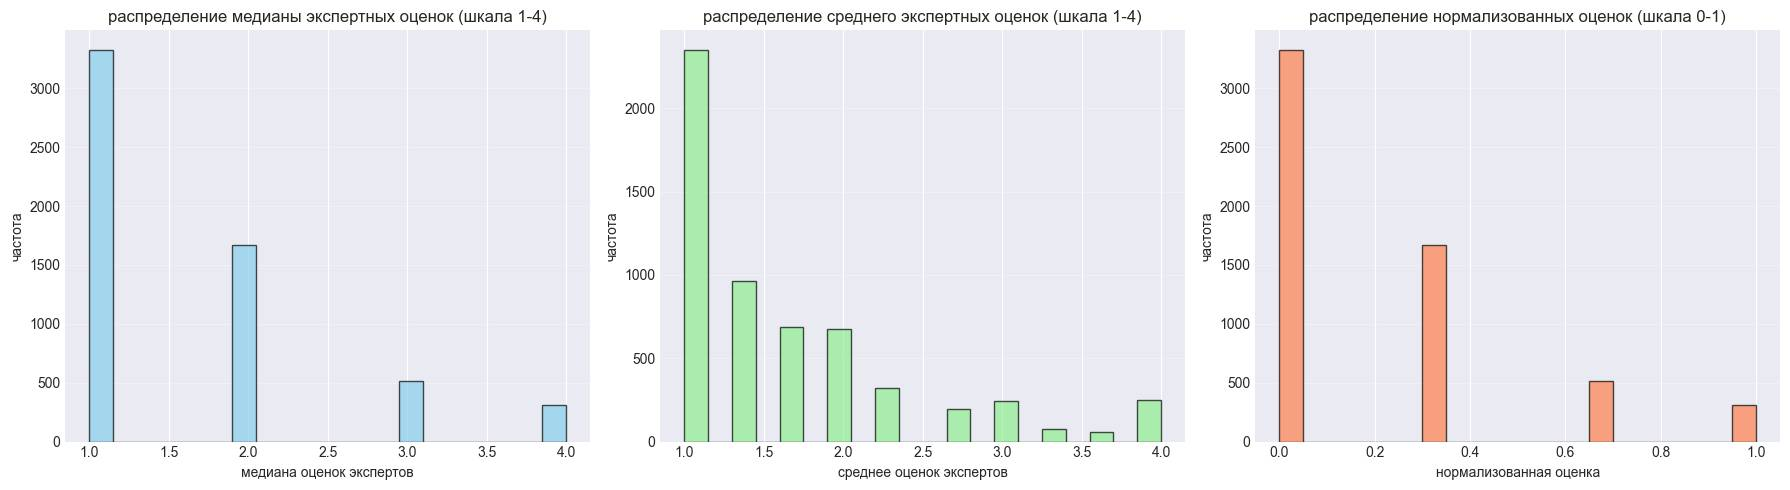

In [42]:
# агрегируем оценки экспертов медианой
master_df['expert_median'] = master_df[['expert1', 'expert2', 'expert3']].median(axis=1)

# также посчитаем среднее для сравнения
master_df['expert_mean'] = master_df[['expert1', 'expert2', 'expert3']].mean(axis=1)

# нормализуем в диапазон [0, 1]
# исходная шкала: 1-4, преобразуем: (оценка - 1) / 3
master_df['expert_score_normalized'] = (master_df['expert_median'] - 1) / 3

print("статистика агрегированных оценок:")
print("\nmedian:")
display(master_df['expert_median'].describe())
print("\nmean:")
display(master_df['expert_mean'].describe())
print("\nnormalized score [0, 1]:")
display(master_df['expert_score_normalized'].describe())

# распределение
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(master_df['expert_median'], bins=20, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].set_xlabel('медиана оценок экспертов')
axes[0].set_ylabel('частота')
axes[0].set_title('распределение медианы экспертных оценок (шкала 1-4)')
axes[0].grid(axis='y', alpha=0.3)

axes[1].hist(master_df['expert_mean'], bins=20, edgecolor='black', alpha=0.7, color='lightgreen')
axes[1].set_xlabel('среднее оценок экспертов')
axes[1].set_ylabel('частота')
axes[1].set_title('распределение среднего экспертных оценок (шкала 1-4)')
axes[1].grid(axis='y', alpha=0.3)

axes[2].hist(master_df['expert_score_normalized'], bins=20, edgecolor='black', alpha=0.7, color='coral')
axes[2].set_xlabel('нормализованная оценка')
axes[2].set_ylabel('частота')
axes[2].set_title('распределение нормализованных оценок (шкала 0-1)')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Сравнение медианы и среднего

разница между медианой и средним:


count    5822.000000
mean        0.134032
std         0.167492
min         0.000000
25%         0.000000
50%         0.000000
75%         0.333333
max         1.000000
Name: median_vs_mean_diff, dtype: float64


случаев, где медиана ≈ среднее: 3515 (60.4%)


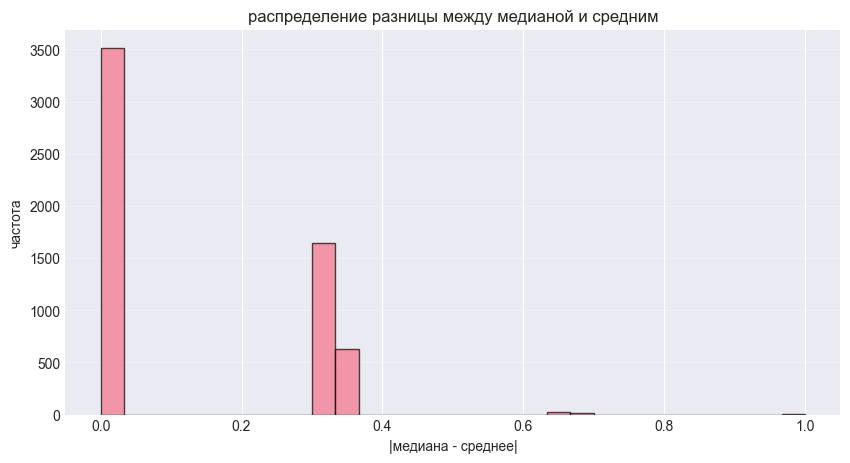

In [43]:
# сравним, насколько медиана и среднее отличаются
master_df['median_vs_mean_diff'] = abs(master_df['expert_median'] - master_df['expert_mean'])

print("разница между медианой и средним:")
display(master_df['median_vs_mean_diff'].describe())

# посчитаем, в скольких случаях они совпадают
same_count = (master_df['median_vs_mean_diff'] < 0.01).sum()
print(f"\nслучаев, где медиана ≈ среднее: {same_count} ({same_count/len(master_df)*100:.1f}%)")

# распределение разницы
plt.figure(figsize=(10, 5))
master_df['median_vs_mean_diff'].hist(bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('|медиана - среднее|')
plt.ylabel('частота')
plt.title('распределение разницы между медианой и средним')
plt.grid(axis='y', alpha=0.3)
plt.show()

### Распределение по категориям оценок

распределение по категориям:


expert_category
плохое соответствие (1-1.5)         3327
частичное соответствие (1.5-2.5)    1666
хорошее соответствие (2.5-3.5)       518
отличное соответствие (3.5-4)        311
Name: count, dtype: int64

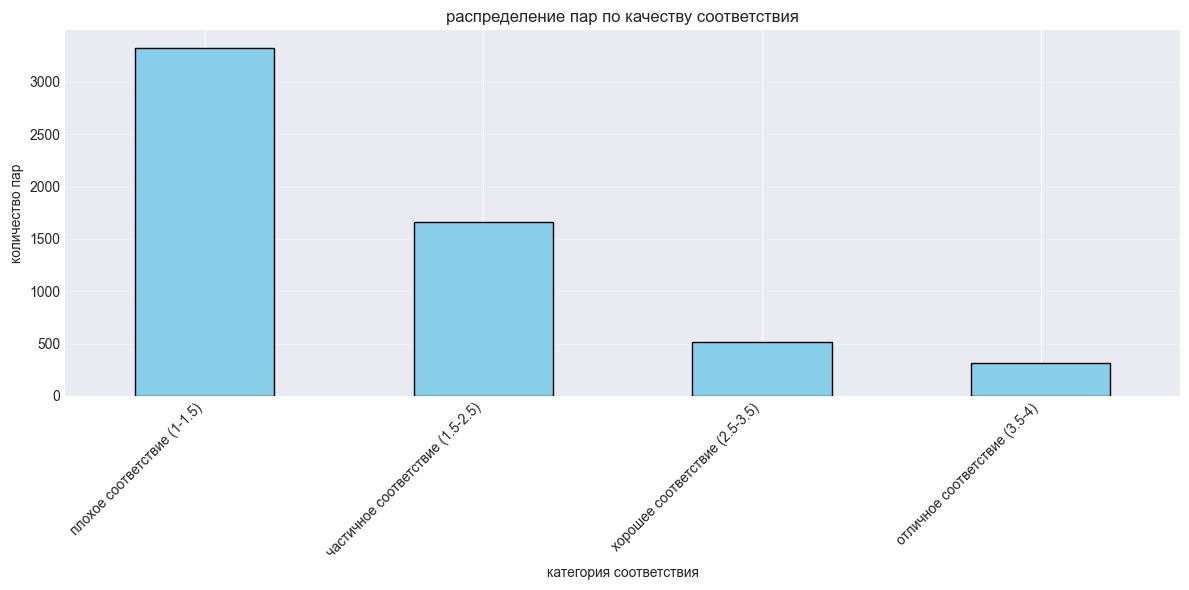

In [44]:
# разобьём на категории для анализа
def categorize_score(score):
    if score <= 1.5:
        return 'плохое соответствие (1-1.5)'
    elif score <= 2.5:
        return 'частичное соответствие (1.5-2.5)'
    elif score <= 3.5:
        return 'хорошее соответствие (2.5-3.5)'
    else:
        return 'отличное соответствие (3.5-4)'

master_df['expert_category'] = master_df['expert_median'].apply(categorize_score)

print("распределение по категориям:")
category_counts = master_df['expert_category'].value_counts()
display(category_counts)

# визуализация
plt.figure(figsize=(12, 6))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('категория соответствия')
plt.ylabel('количество пар')
plt.title('распределение пар по качеству соответствия')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Примеры пар с разными оценками

In [45]:
# функция для показа примеров из master_df с оценками
def show_master_examples(df_subset, title, n_show=3):
    """
    показывает изображения с агрегированными экспертными оценками из master_df
    
    параметры:
    - df_subset: подмножество master_df
    - title: заголовок группы
    - n_show: количество примеров
    """
    print(f"\n{'='*80}")
    print(f"{title}")
    print(f"{'='*80}\n")
    
    n = min(len(df_subset), n_show)
    fig, axes = plt.subplots(1, n, figsize=(6*n, 6))
    
    if n == 1:
        axes = [axes]
    
    for idx, (_, row) in enumerate(df_subset.head(n).iterrows()):
        image_path = os.path.join(train_images_dir, row['image_file'])
        
        if os.path.exists(image_path):
            img = Image.open(image_path)
            axes[idx].imshow(img)
            axes[idx].axis('off')
            
            # цвет в зависимости от медианы
            if row['expert_median'] == 4.0:
                color = 'darkgreen'
                emoji = '✅'
            elif row['expert_median'] == 3.0:
                color = 'green'
                emoji = '👍'
            elif row['expert_median'] == 2.0:
                color = 'orange'
                emoji = '⚠️'
            else:
                color = 'red'
                emoji = '❌'
            
            text_info = (
                f"{emoji} медиана: {row['expert_median']}\n"
                f"оценки: [{row['expert1']}, {row['expert2']}, {row['expert3']}]\n\n"
                f"описание:\n{row['query_text'][:90]}..."
            )
            axes[idx].set_title(text_info, fontsize=9, color=color)
        else:
            axes[idx].text(0.5, 0.5, f'изображение не найдено:\n{row["image_file"]}', 
                          ha='center', va='center')
            axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # подробная информация
    print("\nподробная информация:")
    for idx, (_, row) in enumerate(df_subset.head(n).iterrows()):
        print(f"\n{idx+1}. изображение: {row['image_file']}")
        print(f"   оценки: expert1={row['expert1']}, expert2={row['expert2']}, expert3={row['expert3']}")
        print(f"   медиана: {row['expert_median']}")
        print(f"   описание: {row['query_text']}")

примеры пар с разными уровнями соответствия:

=== ПЛОХОЕ СООТВЕТСТВИЕ (медиана = 1) ===


image_file  \
0  1056338697_4f7d7ce270.jpg   
1  1056338697_4f7d7ce270.jpg   
2  1056338697_4f7d7ce270.jpg   

                                          query_text  expert1  expert2  \
0  A young child is wearing blue goggles and sitt...        1        1   
1  A girl wearing a yellow shirt and sunglasses s...        1        1   
2    A man sleeps under a blanket on a city street .        1        1   

   expert3  expert_median  
0        1            1.0  
1        2            1.0  
2        2            1.0


ПЛОХОЕ СООТВЕТСТВИЕ (медиана = 1)



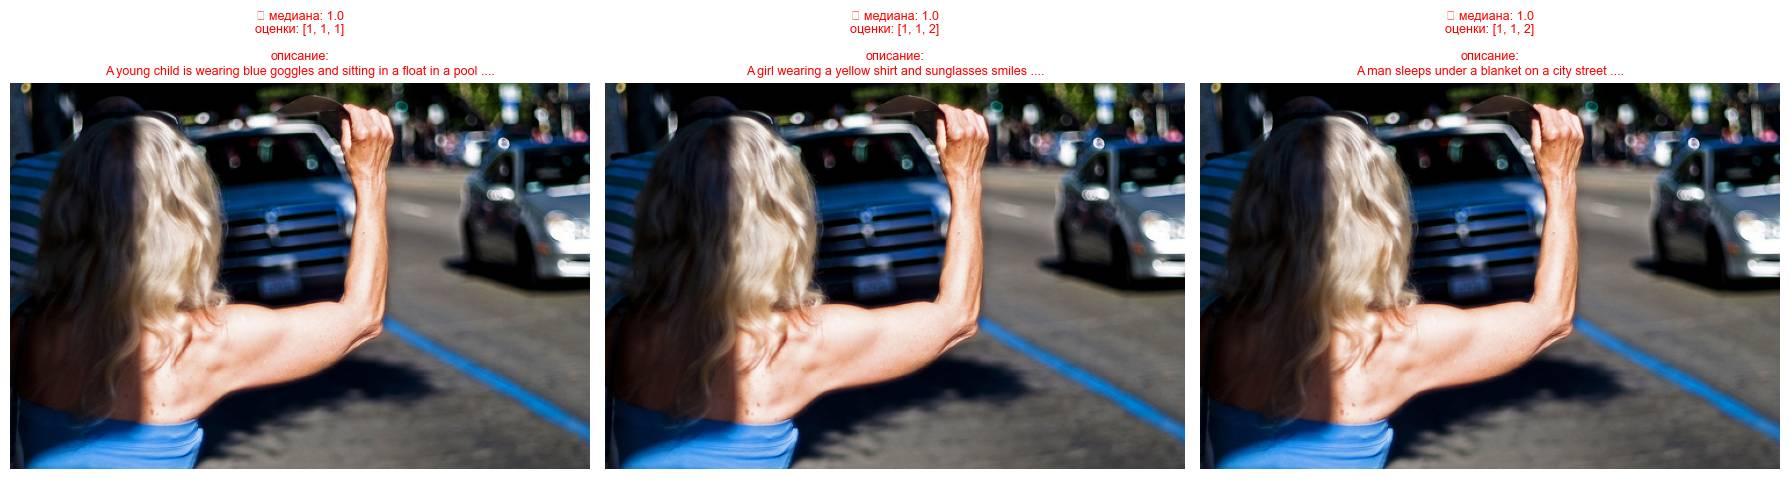


подробная информация:

1. изображение: 1056338697_4f7d7ce270.jpg
   оценки: expert1=1, expert2=1, expert3=1
   медиана: 1.0
   описание: A young child is wearing blue goggles and sitting in a float in a pool .

2. изображение: 1056338697_4f7d7ce270.jpg
   оценки: expert1=1, expert2=1, expert3=2
   медиана: 1.0
   описание: A girl wearing a yellow shirt and sunglasses smiles .

3. изображение: 1056338697_4f7d7ce270.jpg
   оценки: expert1=1, expert2=1, expert3=2
   медиана: 1.0
   описание: A man sleeps under a blanket on a city street .

=== ЧАСТИЧНОЕ СООТВЕТСТВИЕ (медиана = 2) ===


image_file  \
3   1056338697_4f7d7ce270.jpg   
9    106490881_5a2dd9b7bd.jpg   
10   106490881_5a2dd9b7bd.jpg   

                                           query_text  expert1  expert2  \
3   A woman plays with long red ribbons in an empt...        1        2   
9        A little boy shakes the snow off of a tree .        2        2   
10                The kid is on a float in the snow .        2        2   

    expert3  expert_median  
3         2            2.0  
9         2            2.0  
10        2            2.0


ЧАСТИЧНОЕ СООТВЕТСТВИЕ (медиана = 2)



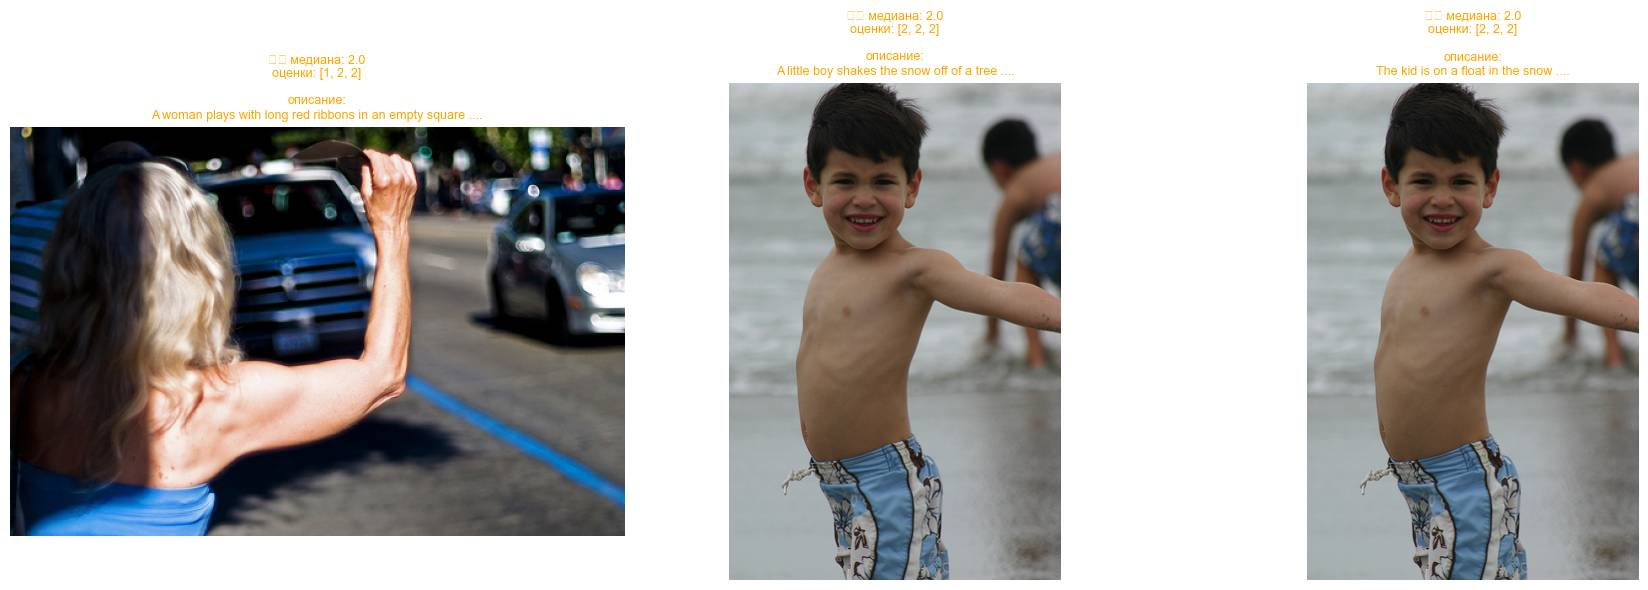


подробная информация:

1. изображение: 1056338697_4f7d7ce270.jpg
   оценки: expert1=1, expert2=2, expert3=2
   медиана: 2.0
   описание: A woman plays with long red ribbons in an empty square .

2. изображение: 106490881_5a2dd9b7bd.jpg
   оценки: expert1=2, expert2=2, expert3=2
   медиана: 2.0
   описание: A little boy shakes the snow off of a tree .

3. изображение: 106490881_5a2dd9b7bd.jpg
   оценки: expert1=2, expert2=2, expert3=2
   медиана: 2.0
   описание: The kid is on a float in the snow .

=== ХОРОШЕЕ СООТВЕТСТВИЕ (медиана = 3) ===


image_file  \
22  1084040636_97d9633581.jpg   
32  1107246521_d16a476380.jpg   
36  1107246521_d16a476380.jpg   

                                          query_text  expert1  expert2  \
22      Close-up of dog in profile with mouth open .        2        3   
32  Large dog plays with two smaller dogs on grass .        2        3   
36               Three dogs are playing in a field .        3        3   

    expert3  expert_median  
22        3            3.0  
32        3            3.0  
36        3            3.0


ХОРОШЕЕ СООТВЕТСТВИЕ (медиана = 3)



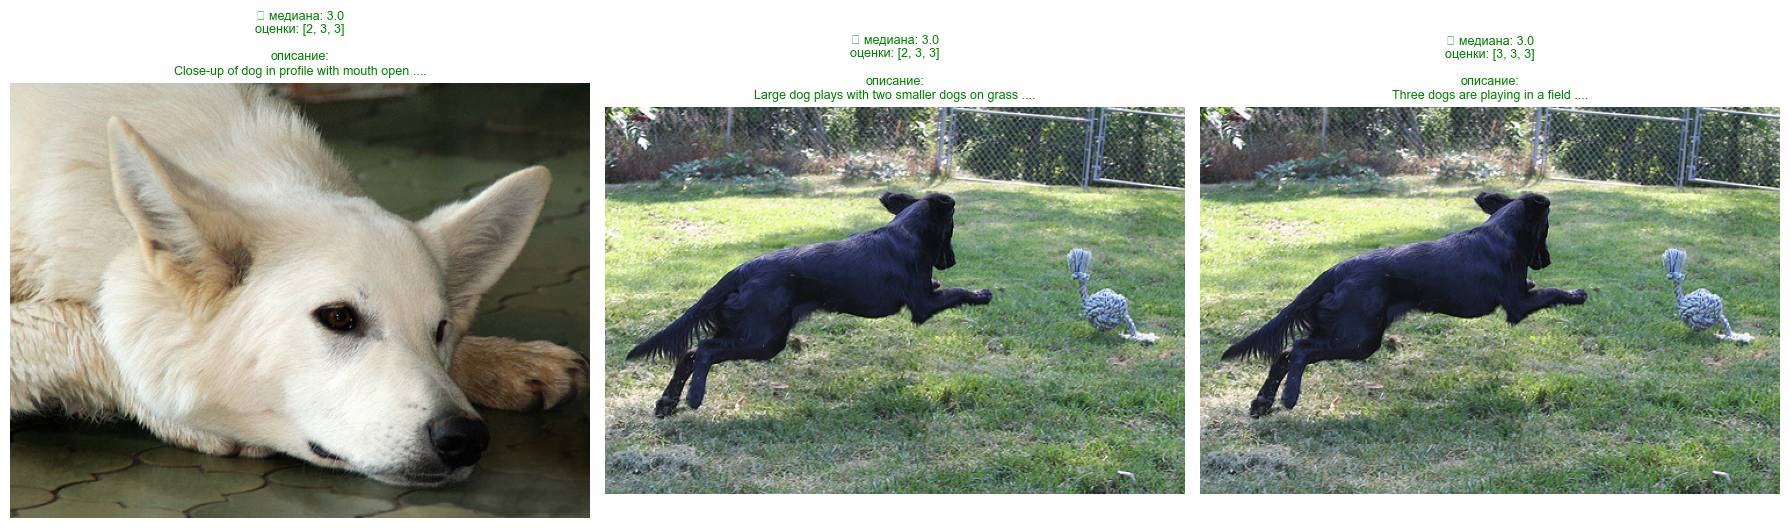


подробная информация:

1. изображение: 1084040636_97d9633581.jpg
   оценки: expert1=2, expert2=3, expert3=3
   медиана: 3.0
   описание: Close-up of dog in profile with mouth open .

2. изображение: 1107246521_d16a476380.jpg
   оценки: expert1=2, expert2=3, expert3=3
   медиана: 3.0
   описание: Large dog plays with two smaller dogs on grass .

3. изображение: 1107246521_d16a476380.jpg
   оценки: expert1=3, expert2=3, expert3=3
   медиана: 3.0
   описание: Three dogs are playing in a field .

=== ОТЛИЧНОЕ СООТВЕТСТВИЕ (медиана = 4) ===


image_file                             query_text  expert1  \
43  1119015538_e8e796281e.jpg        A white dog runs in the grass ,        4   
50  1131800850_89c7ffd477.jpg        A brown dog shaking off water .        3   
53  1131932671_c8d17751b3.jpg  A boy jumps from one bed to another .        4   

    expert2  expert3  expert_median  
43        4        4            4.0  
50        4        4            4.0  
53        4        4            4.0


ОТЛИЧНОЕ СООТВЕТСТВИЕ (медиана = 4)



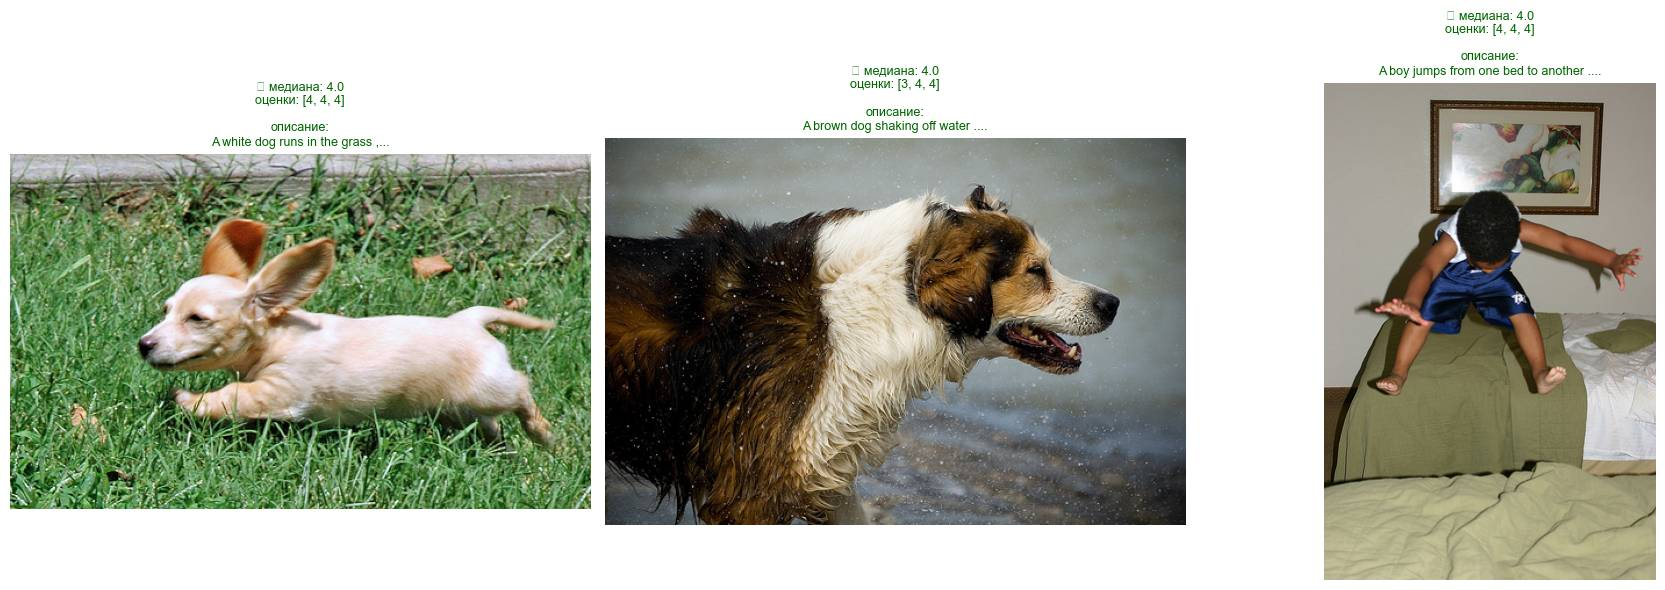


подробная информация:

1. изображение: 1119015538_e8e796281e.jpg
   оценки: expert1=4, expert2=4, expert3=4
   медиана: 4.0
   описание: A white dog runs in the grass ,

2. изображение: 1131800850_89c7ffd477.jpg
   оценки: expert1=3, expert2=4, expert3=4
   медиана: 4.0
   описание: A brown dog shaking off water .

3. изображение: 1131932671_c8d17751b3.jpg
   оценки: expert1=4, expert2=4, expert3=4
   медиана: 4.0
   описание: A boy jumps from one bed to another .

СРАВНЕНИЕ ВСЕХ КАТЕГОРИЙ


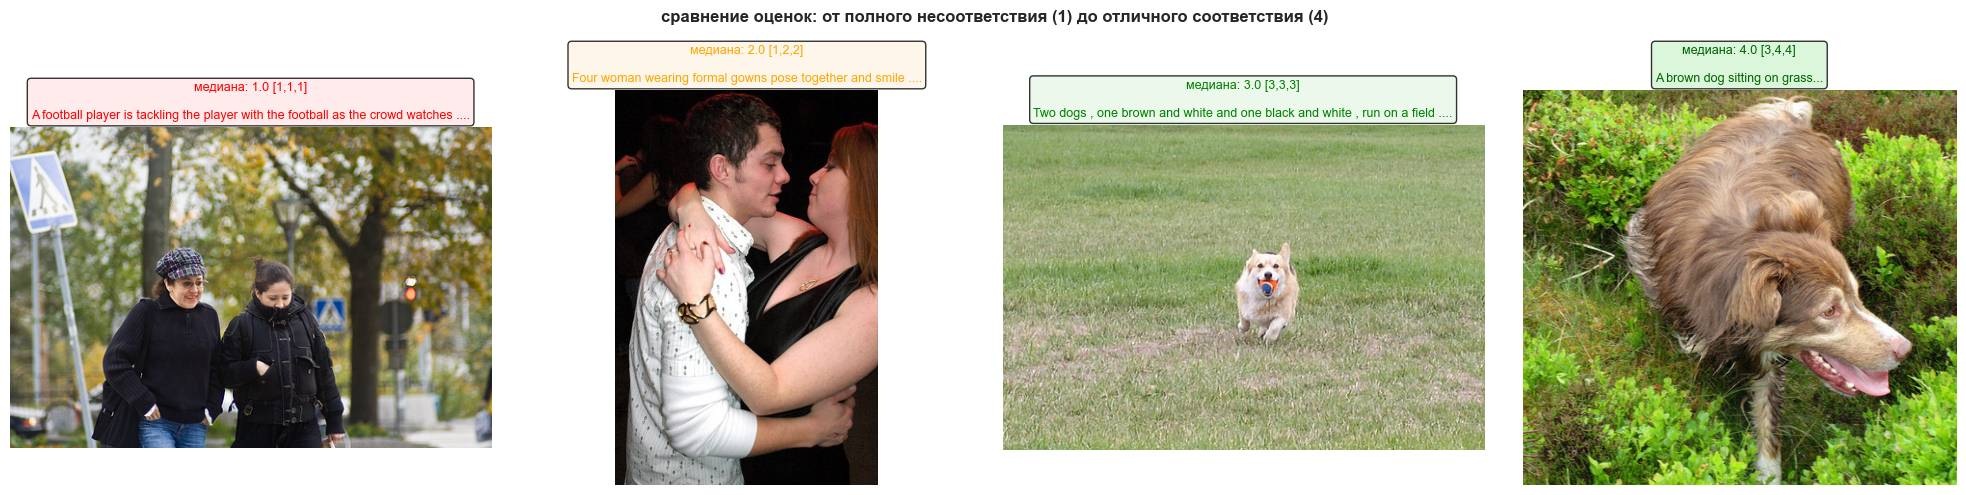

In [46]:
# плохое соответствие
print("примеры пар с разными уровнями соответствия:\n")
print("=== ПЛОХОЕ СООТВЕТСТВИЕ (медиана = 1) ===")
bad_examples = master_df[master_df['expert_median'] == 1.0][
    ['image_file', 'query_text', 'expert1', 'expert2', 'expert3', 'expert_median']
].head(3)
display(bad_examples)
show_master_examples(
    master_df[master_df['expert_median'] == 1.0], 
    "ПЛОХОЕ СООТВЕТСТВИЕ (медиана = 1)"
)

# частичное соответствие
print("\n=== ЧАСТИЧНОЕ СООТВЕТСТВИЕ (медиана = 2) ===")
partial_examples = master_df[master_df['expert_median'] == 2.0][
    ['image_file', 'query_text', 'expert1', 'expert2', 'expert3', 'expert_median']
].head(3)
display(partial_examples)
show_master_examples(
    master_df[master_df['expert_median'] == 2.0], 
    "ЧАСТИЧНОЕ СООТВЕТСТВИЕ (медиана = 2)"
)

# хорошее соответствие
print("\n=== ХОРОШЕЕ СООТВЕТСТВИЕ (медиана = 3) ===")
good_examples = master_df[master_df['expert_median'] == 3.0][
    ['image_file', 'query_text', 'expert1', 'expert2', 'expert3', 'expert_median']
].head(3)
display(good_examples)
show_master_examples(
    master_df[master_df['expert_median'] == 3.0], 
    "ХОРОШЕЕ СООТВЕТСТВИЕ (медиана = 3)"
)

# отличное соответствие
print("\n=== ОТЛИЧНОЕ СООТВЕТСТВИЕ (медиана = 4) ===")
excellent_examples = master_df[master_df['expert_median'] == 4.0][
    ['image_file', 'query_text', 'expert1', 'expert2', 'expert3', 'expert_median']
].head(3)
display(excellent_examples)
show_master_examples(
    master_df[master_df['expert_median'] == 4.0], 
    "ОТЛИЧНОЕ СООТВЕТСТВИЕ (медиана = 4)"
)

# дополнительно: сравнение всех категорий на одном графике
print("\n" + "="*80)
print("СРАВНЕНИЕ ВСЕХ КАТЕГОРИЙ")
print("="*80)

# по одному случайному примеру из каждой категории
comparison_examples = pd.concat([
    master_df[master_df['expert_median'] == 1.0].sample(1, random_state=42),
    master_df[master_df['expert_median'] == 2.0].sample(1, random_state=42),
    master_df[master_df['expert_median'] == 3.0].sample(1, random_state=42),
    master_df[master_df['expert_median'] == 4.0].sample(1, random_state=42),
])

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for idx, (_, row) in enumerate(comparison_examples.iterrows()):
    image_path = os.path.join(train_images_dir, row['image_file'])
    
    if os.path.exists(image_path):
        img = Image.open(image_path)
        axes[idx].imshow(img)
        axes[idx].axis('off')
        
        # цвет в зависимости от медианы
        colors = {1.0: 'red', 2.0: 'orange', 3.0: 'green', 4.0: 'darkgreen'}
        bg_colors = {1.0: '#ffe6e6', 2.0: '#fff4e6', 3.0: '#e6f7e6', 4.0: '#d4f4d4'}
        
        text_info = (
            f"медиана: {row['expert_median']} [{row['expert1']},{row['expert2']},{row['expert3']}]\n\n"
            f"{row['query_text'][:100]}..."
        )
        axes[idx].set_title(text_info, fontsize=9, color=colors[row['expert_median']],
                           bbox=dict(boxstyle='round', facecolor=bg_colors[row['expert_median']], alpha=0.8))

plt.suptitle('сравнение оценок: от полного несоответствия (1) до отличного соответствия (4)', 
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

### Анализ баланса данных

анализ баланса данных:

распределение медианы экспертных оценок:


expert_median
1.0    3327
2.0    1666
3.0     518
4.0     311
Name: count, dtype: int64


процентное соотношение:


expert_median
1.0    57.15
2.0    28.62
3.0     8.90
4.0     5.34
Name: count, dtype: float64

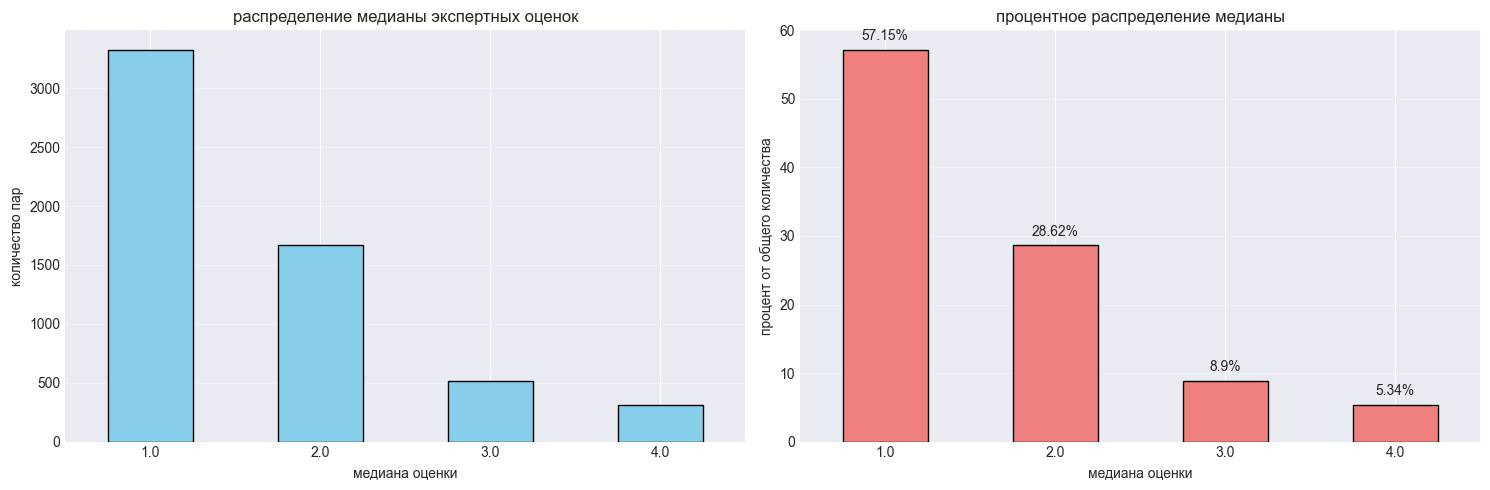

In [47]:
# проанализируем баланс целевой переменной
print("анализ баланса данных:\n")

# распределение медианы
median_dist = master_df['expert_median'].value_counts().sort_index()
print("распределение медианы экспертных оценок:")
display(median_dist)

# процентное соотношение
print("\nпроцентное соотношение:")
median_pct = (median_dist / len(master_df) * 100).round(2)
display(median_pct)

# визуализация баланса
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# абсолютные значения
median_dist.plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_xlabel('медиана оценки')
axes[0].set_ylabel('количество пар')
axes[0].set_title('распределение медианы экспертных оценок')
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# процентное соотношение
median_pct.plot(kind='bar', ax=axes[1], color='lightcoral', edgecolor='black')
axes[1].set_xlabel('медиана оценки')
axes[1].set_ylabel('процент от общего количества')
axes[1].set_title('процентное распределение медианы')
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

# добавим значения на столбцы
for i, v in enumerate(median_pct):
    axes[1].text(i, v + 1, f'{v}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

 Выводы по агрегации экспертных оценокКлючевые наблюдения:
Распределение оценок:

Медиана: среднее 1.62, медиана 1.0
Нормализованная оценка [0, 1]: среднее 0.21, медиана 0.0
Сильный дисбаланс: 57% пар имеют оценку 1 (полное несоответствие)



Медиана vs Среднее:

В 60.4% случаев медиана ≈ среднее (разница < 0.01)
Средняя разница: 0.13
Вывод: Медиана — хороший выбор, она устойчива к выбросам



Баланс классов (КРИТИЧНО! 🚨):

   Плохое соответствие (1):        57.15%  ← Большинство!
   Частичное соответствие (2):     28.62%
   Хорошее соответствие (3):        8.90%
   Отличное соответствие (4):       5.34%  ← Меньшинство!Проблема: Модель может научиться всегда предсказывать низкие оценки. Нужно будет:

Использовать балансировку при обучении
Выбрать правильные метрики (не accuracy!)
Возможно, применить веса классов

Примеры показывают логику:

Оценка 1: "A young child..." для изображения собаки — явное несоответствие
Оценка 4: "A white dog runs in the grass" — точное описание

## Работа с краудсорсинговыми оценками

Добавим краудсорсинговые оценки к master_df и создадим комбинированную целевую переменную.

### Подготовка краудсорсинговых оценок

Готовим краудсорсинговые данные для объединения с master_df. Нам нужны только три колонки: image_file, caption_id (для объединения) и agreement_ratio (оценка).

In [48]:
print("="*80)
print("РАБОТА С КРАУДСОРСИНГОВЫМИ ОЦЕНКАМИ")
print("="*80)

# посмотрим на структуру crowd_df
print("\nструктура crowd_df:")
print(f"строк: {len(crowd_df)}")
print(f"уникальных пар (image_file, caption_id): {crowd_df.groupby(['image_file', 'caption_id']).size().shape[0]}")

# создадим упрощённую версию crowd_df для объединения
crowd_for_merge = crowd_df[['image_file', 'caption_id', 'agreement_ratio']].copy()

print("\nпервые строки crowd_for_merge:")
display(crowd_for_merge.head())

РАБОТА С КРАУДСОРСИНГОВЫМИ ОЦЕНКАМИ

структура crowd_df:
строк: 47830
уникальных пар (image_file, caption_id): 47830

первые строки crowd_for_merge:


image_file                   caption_id  agreement_ratio
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2              1.0
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2              0.0
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2              0.0
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2              0.0
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2              0.0

### Объединение с краудсорсинговыми оценками

Добавляем к каждой паре (изображение, описание) краудсорсинговую оценку. Если для какой-то пары нет краудсорсинговой оценки — будет NaN.

In [51]:
# объединяем master_df с краудсорсинговыми оценками
master_df = master_df.merge(
    crowd_for_merge,
    on=['image_file', 'caption_id'],
    how='left'
)

print(f"размер после объединения с crowd: {master_df.shape}")
print(f"пропусков в agreement_ratio: {master_df['agreement_ratio'].isnull().sum()}")

# посмотрим на объединённые данные
print("\nпервые строки с обеими оценками:")
display(master_df[['image_file', 'caption_id', 'expert_score_normalized', 
                     'agreement_ratio', 'query_text']].head())

размер после объединения с crowd: (5822, 19)
пропусков в agreement_ratio: 3493

первые строки с обеими оценками:


image_file                   caption_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2   

   expert_score_normalized  agreement_ratio  \
0                 0.000000              0.0   
1                 0.000000              0.0   
2                 0.000000              NaN   
3                 0.333333              NaN   
4                 0.000000              NaN   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A girl wearing a yellow shirt and sunglasses s...  
2    A man sleeps under a blanket on a city street .  
3  A woman plays with long red ribbons in an empt...  
4         Chinese market street in the winter time .

### Анализ пропусков

Нужно понять, для скольких пар есть обе оценки (экспертная и краудсорсинговая). Если есть пары только с экспертными оценками — нужно решить, как с ними работать.

In [52]:
# проверим, сколько пар есть в обеих разметках
both_available = master_df['agreement_ratio'].notna().sum()
only_expert = master_df['agreement_ratio'].isna().sum()

print("="*80)
print("АНАЛИЗ ПОКРЫТИЯ ДАННЫХ")
print("="*80)

print(f"\nпар с обеими разметками (эксперты + краудсорсинг): {both_available}")
print(f"пар только с экспертной разметкой: {only_expert}")
print(f"всего пар: {len(master_df)}")
print(f"\nпроцент покрытия краудсорсингом: {both_available/len(master_df)*100:.2f}%")

# примеры пар без краудсорсинговой оценки
if only_expert > 0:
    print("\nпримеры пар без краудсорсинговой оценки:")
    display(master_df[master_df['agreement_ratio'].isna()][
        ['image_file', 'caption_id', 'query_text', 'expert_median', 'expert_score_normalized']
    ].head(5))
else:
    print("\nвсе пары имеют краудсорсинговые оценки!")

АНАЛИЗ ПОКРЫТИЯ ДАННЫХ

пар с обеими разметками (эксперты + краудсорсинг): 2329
пар только с экспертной разметкой: 3493
всего пар: 5822

процент покрытия краудсорсингом: 40.00%

примеры пар без краудсорсинговой оценки:


image_file                   caption_id  \
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2   
5  1056338697_4f7d7ce270.jpg  3360930596_1e75164ce6.jpg#2   
6  1056338697_4f7d7ce270.jpg  3545652636_0746537307.jpg#2   

                                          query_text  expert_median  \
2    A man sleeps under a blanket on a city street .            1.0   
3  A woman plays with long red ribbons in an empt...            2.0   
4         Chinese market street in the winter time .            1.0   
5  A soccer ball is above the head of a man weari...            1.0   
6  A young boy dressed in a red uniform kicks the...            1.0   

   expert_score_normalized  
2                 0.000000  
3                 0.333333  
4                 0.000000  
5                 0.000000  
6                 0.000000

### Сравнение распределений экспертных и краудсорсинговых оценок

Визуально сравниваем, как распределены оценки экспертов и краудворкеров. Смотрим:

- Похожи ли распределения?
- Какие средние значения?
- У кого больше разброс?


пар с обеими оценками для анализа: 2329


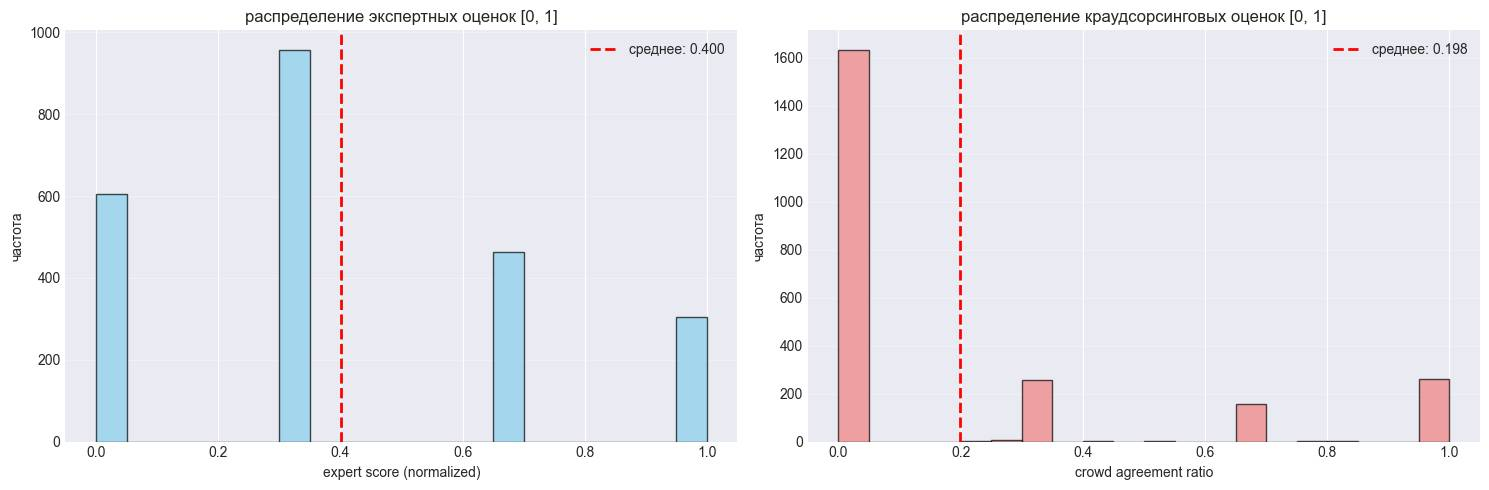


статистика экспертных оценок (нормализованных):


count    2329.000000
mean        0.400458
std         0.323491
min         0.000000
25%         0.000000
50%         0.333333
75%         0.666667
max         1.000000
Name: expert_score_normalized, dtype: float64


статистика краудсорсинговых оценок:


count    2329.000000
mean        0.198283
std         0.343315
min         0.000000
25%         0.000000
50%         0.000000
75%         0.333333
max         1.000000
Name: agreement_ratio, dtype: float64

In [53]:
# оставим только те строки, где есть обе оценки для корректного сравнения
df_both = master_df[master_df['agreement_ratio'].notna()].copy()

print(f"\nпар с обеими оценками для анализа: {len(df_both)}")

# сравним распределения
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# экспертные оценки (нормализованные)
axes[0].hist(df_both['expert_score_normalized'], bins=20, edgecolor='black', 
             alpha=0.7, color='skyblue')
axes[0].set_xlabel('expert score (normalized)')
axes[0].set_ylabel('частота')
axes[0].set_title('распределение экспертных оценок [0, 1]')
axes[0].axvline(df_both['expert_score_normalized'].mean(), color='red', 
                linestyle='--', linewidth=2, label=f"среднее: {df_both['expert_score_normalized'].mean():.3f}")
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# краудсорсинговые оценки
axes[1].hist(df_both['agreement_ratio'], bins=20, edgecolor='black', 
             alpha=0.7, color='lightcoral')
axes[1].set_xlabel('crowd agreement ratio')
axes[1].set_ylabel('частота')
axes[1].set_title('распределение краудсорсинговых оценок [0, 1]')
axes[1].axvline(df_both['agreement_ratio'].mean(), color='red', 
                linestyle='--', linewidth=2, label=f"среднее: {df_both['agreement_ratio'].mean():.3f}")
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# статистика
print("\nстатистика экспертных оценок (нормализованных):")
display(df_both['expert_score_normalized'].describe())

print("\nстатистика краудсорсинговых оценок:")
display(df_both['agreement_ratio'].describe())

### Корреляция между оценками

Поймем, насколько согласованы оценки экспертов и краудворкеров.

- Если корреляция высокая (>0.7) — оценки согласованы, можно их комбинировать
- Если низкая (<0.4) — они оценивают по-разному, нужно осторожно комбинировать

АНАЛИЗ КОРРЕЛЯЦИИ МЕЖДУ ЭКСПЕРТНЫМИ И КРАУДСОРСИНГОВЫМИ ОЦЕНКАМИ

корреляция между оценками:


expert_score_normalized  agreement_ratio
expert_score_normalized                 1.000000         0.762474
agreement_ratio                         0.762474         1.000000


коэффициент корреляции пирсона: 0.762
интерпретация: сильная положительная связь


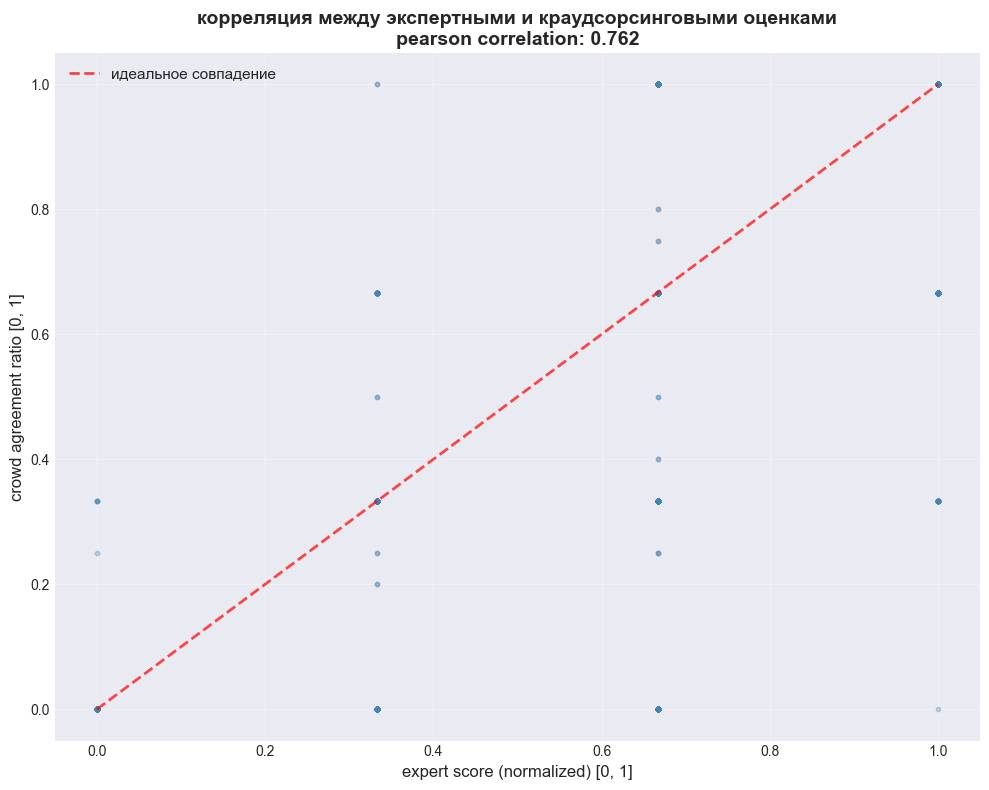

In [54]:
print("="*80)
print("АНАЛИЗ КОРРЕЛЯЦИИ МЕЖДУ ЭКСПЕРТНЫМИ И КРАУДСОРСИНГОВЫМИ ОЦЕНКАМИ")
print("="*80)

# корреляция между оценками
correlation = df_both[['expert_score_normalized', 'agreement_ratio']].corr()
print("\nкорреляция между оценками:")
display(correlation)

correlation_value = correlation.iloc[0, 1]
print(f"\nкоэффициент корреляции пирсона: {correlation_value:.3f}")

# интерпретация
if correlation_value > 0.7:
    interpretation = "сильная положительная связь"
elif correlation_value > 0.4:
    interpretation = "умеренная положительная связь"
elif correlation_value > 0.2:
    interpretation = "слабая положительная связь"
else:
    interpretation = "очень слабая или отсутствует"
    
print(f"интерпретация: {interpretation}")

# scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(df_both['expert_score_normalized'], df_both['agreement_ratio'], 
            alpha=0.3, s=10, color='steelblue')
plt.xlabel('expert score (normalized) [0, 1]', fontsize=12)
plt.ylabel('crowd agreement ratio [0, 1]', fontsize=12)
plt.title(f'корреляция между экспертными и краудсорсинговыми оценками\n'
          f'pearson correlation: {correlation_value:.3f}', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# диагональная линия (идеальное совпадение)
plt.plot([0, 1], [0, 1], 'r--', linewidth=2, label='идеальное совпадение', alpha=0.7)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

Эксперты и краудворкеры в целом согласны друг с другом. Можно смело комбинировать их оценки!

### Создание комбинированной целевой переменной

Создадим единую целевую переменную, которая учитывает обе разметки с весами 70/30. Для пар без краудсорсинговой оценки используем только экспертную.


СОЗДАНИЕ КОМБИНИРОВАННОЙ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ

статистика комбинированной оценки:


count    5822.000000
mean        0.183855
std         0.264816
min         0.000000
25%         0.000000
50%         0.000000
75%         0.333333
max         1.000000
Name: combined_score, dtype: float64


пар с комбинированной оценкой: 5822
пропусков: 0

примеры комбинированных оценок:


image_file                   caption_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2   
5  1056338697_4f7d7ce270.jpg  3360930596_1e75164ce6.jpg#2   
6  1056338697_4f7d7ce270.jpg  3545652636_0746537307.jpg#2   
7  1056338697_4f7d7ce270.jpg   434792818_56375e203f.jpg#2   
8   106490881_5a2dd9b7bd.jpg  1425069308_488e5fcf9d.jpg#2   
9   106490881_5a2dd9b7bd.jpg  1714316707_8bbaa2a2ba.jpg#2   

   expert_score_normalized  agreement_ratio  combined_score  
0                 0.000000              0.0        0.000000  
1                 0.000000              0.0        0.000000  
2                 0.000000              NaN        0.000000  
3                 0.333333              NaN        0.333333  
4                 0.000000              NaN        0.000000  
5                 0.000000              NaN        0.000000  
6                 0.000000              NaN        0.000000  
7                 0.000000              0.0        0.000000  
8                 0.000000              NaN        0.000000  
9                 0.333333              NaN        0.333333


РАСПРЕДЕЛЕНИЕ ПО ДИАПАЗОНАМ
  точно 0 (полное несоответствие)         : 3322 пар (57.06%)
  очень низкое (0.001-0.25)               :  848 пар (14.57%)
  низкое (0.25-0.5)                       : 1011 пар (17.37%)
  высокое (0.5-0.75)                      :  294 пар ( 5.05%)
  очень высокое (0.75-1.0)                :  347 пар ( 5.96%)


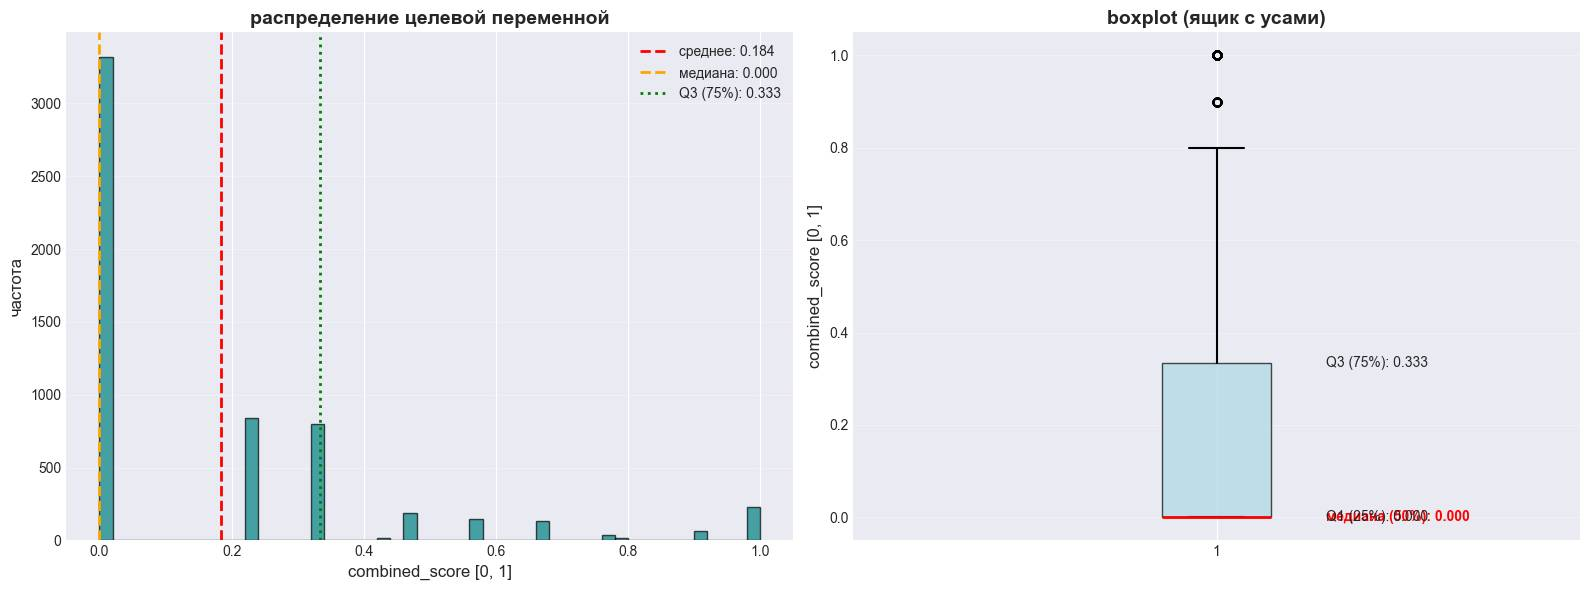

In [68]:
print("\n" + "="*80)
print("СОЗДАНИЕ КОМБИНИРОВАННОЙ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ")
print("="*80)

# создаём комбинированную целевую переменную (0.7 × эксперты + 0.3 × краудсорсинг)
# для пар, где есть обе оценки
master_df['combined_score'] = (
    0.7 * master_df['expert_score_normalized'] + 
    0.3 * master_df['agreement_ratio']
)

# для пар, где нет краудсорсинговой оценки, используем только экспертную
master_df['combined_score'].fillna(master_df['expert_score_normalized'], inplace=True)

print("\nстатистика комбинированной оценки:")
display(master_df['combined_score'].describe())

print(f"\nпар с комбинированной оценкой: {master_df['combined_score'].notna().sum()}")
print(f"пропусков: {master_df['combined_score'].isna().sum()}")

# проверим несколько примеров
print("\nпримеры комбинированных оценок:")
display(master_df[['image_file', 'caption_id', 'expert_score_normalized', 
                     'agreement_ratio', 'combined_score']].head(10))

# распределение по диапазонам
print("\n" + "="*80)
print("РАСПРЕДЕЛЕНИЕ ПО ДИАПАЗОНАМ")
print("="*80)

ranges = [
    (0.0, 0.0, "точно 0 (полное несоответствие)"),
    (0.001, 0.25, "очень низкое (0.001-0.25)"),
    (0.25, 0.5, "низкое (0.25-0.5)"),
    (0.5, 0.75, "высокое (0.5-0.75)"),
    (0.75, 1.0, "очень высокое (0.75-1.0)"),
]

for min_val, max_val, label in ranges:
    if min_val == max_val:  # точно 0
        count = (master_df['combined_score'] == min_val).sum()
    else:
        count = ((master_df['combined_score'] > min_val) & 
                 (master_df['combined_score'] <= max_val)).sum()
    pct = (count / len(master_df)) * 100
    print(f"  {label:40s}: {count:4d} пар ({pct:5.2f}%)")

# визуализация с аннотациями квартилей
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# гистограмма
axes[0].hist(master_df['combined_score'], bins=50, edgecolor='black', alpha=0.7, color='teal')
axes[0].axvline(master_df['combined_score'].mean(), color='red', linestyle='--', 
                linewidth=2, label=f'среднее: {master_df["combined_score"].mean():.3f}')
axes[0].axvline(master_df['combined_score'].median(), color='orange', linestyle='--', 
                linewidth=2, label=f'медиана: {master_df["combined_score"].median():.3f}')
axes[0].axvline(master_df['combined_score'].quantile(0.75), color='green', linestyle=':', 
                linewidth=2, label=f'Q3 (75%): {master_df["combined_score"].quantile(0.75):.3f}')
axes[0].set_xlabel('combined_score [0, 1]', fontsize=12)
axes[0].set_ylabel('частота', fontsize=12)
axes[0].set_title('распределение целевой переменной', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(axis='y', alpha=0.3)

# boxplot (ящик с усами)
axes[1].boxplot(master_df['combined_score'], vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2),
                whiskerprops=dict(linewidth=1.5),
                capprops=dict(linewidth=1.5))
axes[1].set_ylabel('combined_score [0, 1]', fontsize=12)
axes[1].set_title('boxplot (ящик с усами)', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# аннотации на boxplot
axes[1].text(1.15, master_df['combined_score'].quantile(0.75), 
             f'Q3 (75%): {master_df["combined_score"].quantile(0.75):.3f}', 
             fontsize=10, va='center')
axes[1].text(1.15, master_df['combined_score'].median(), 
             f'медиана (50%): {master_df["combined_score"].median():.3f}', 
             fontsize=10, va='center', color='red', fontweight='bold')
axes[1].text(1.15, master_df['combined_score'].quantile(0.25), 
             f'Q1 (25%): {master_df["combined_score"].quantile(0.25):.3f}', 
             fontsize=10, va='center')

plt.tight_layout()
plt.show()

### Сравнение всех трёх вариантов целевой переменной

Визуально и численно сравниваем три варианта целевой переменной, чтобы выбрать лучшую для обучения модели.

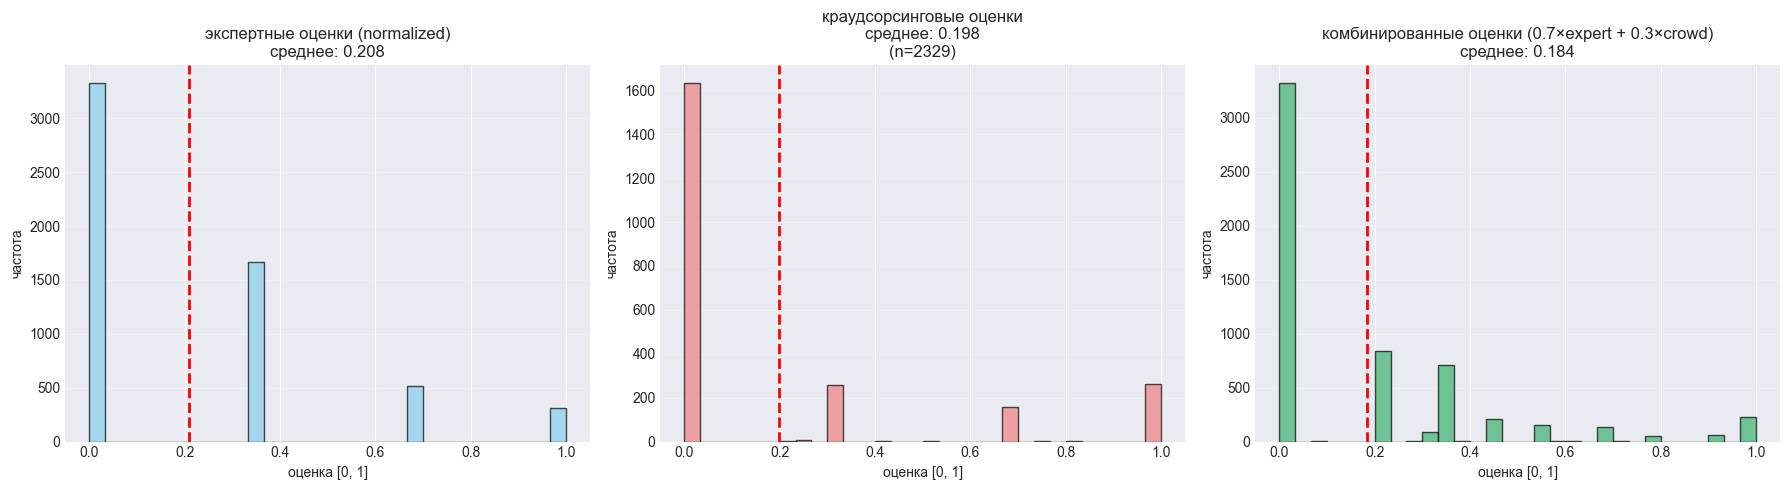


СРАВНЕНИЕ ТРЁХ ВАРИАНТОВ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ

1. ЭКСПЕРТНЫЕ ОЦЕНКИ:
   - доступно: 5822 пар (100%)
   - среднее: 0.208
   - медиана: 0.000

2. КРАУДСОРСИНГОВЫЕ ОЦЕНКИ:
   - доступно: 2329 пар (40%)
   - среднее: 0.198
   - медиана: 0.000

3. КОМБИНИРОВАННЫЕ ОЦЕНКИ:
   - доступно: 5822 пар (100%)
   - среднее: 0.184
   - медиана: 0.000
   - корреляция эксперты-краудворкеры: 0.762 (сильная)


In [56]:
# сравним все три варианта оценок визуально
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# экспертные оценки
axes[0].hist(master_df['expert_score_normalized'], bins=30, edgecolor='black', 
             alpha=0.7, color='skyblue')
axes[0].set_xlabel('оценка [0, 1]')
axes[0].set_ylabel('частота')
axes[0].set_title(f'экспертные оценки (normalized)\nсреднее: {master_df["expert_score_normalized"].mean():.3f}')
axes[0].axvline(master_df['expert_score_normalized'].mean(), color='red', 
                linestyle='--', linewidth=2)
axes[0].grid(axis='y', alpha=0.3)

# краудсорсинговые оценки (только те, что есть)
crowd_available = master_df[master_df['agreement_ratio'].notna()]
axes[1].hist(crowd_available['agreement_ratio'], bins=30, edgecolor='black', 
             alpha=0.7, color='lightcoral')
axes[1].set_xlabel('оценка [0, 1]')
axes[1].set_ylabel('частота')
axes[1].set_title(f'краудсорсинговые оценки\nсреднее: {crowd_available["agreement_ratio"].mean():.3f}\n(n={len(crowd_available)})')
axes[1].axvline(crowd_available['agreement_ratio'].mean(), color='red', 
                linestyle='--', linewidth=2)
axes[1].grid(axis='y', alpha=0.3)

# комбинированные оценки
axes[2].hist(master_df['combined_score'], bins=30, edgecolor='black', 
             alpha=0.7, color='mediumseagreen')
axes[2].set_xlabel('оценка [0, 1]')
axes[2].set_ylabel('частота')
axes[2].set_title(f'комбинированные оценки (0.7×expert + 0.3×crowd)\nсреднее: {master_df["combined_score"].mean():.3f}')
axes[2].axvline(master_df['combined_score'].mean(), color='red', 
                linestyle='--', linewidth=2)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# выводы
print("\n" + "="*80)
print("СРАВНЕНИЕ ТРЁХ ВАРИАНТОВ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ")
print("="*80)

print(f"\n1. ЭКСПЕРТНЫЕ ОЦЕНКИ:")
print(f"   - доступно: {len(master_df)} пар (100%)")
print(f"   - среднее: {master_df['expert_score_normalized'].mean():.3f}")
print(f"   - медиана: {master_df['expert_score_normalized'].median():.3f}")

print(f"\n2. КРАУДСОРСИНГОВЫЕ ОЦЕНКИ:")
print(f"   - доступно: {len(crowd_available)} пар (40%)")
print(f"   - среднее: {crowd_available['agreement_ratio'].mean():.3f}")
print(f"   - медиана: {crowd_available['agreement_ratio'].median():.3f}")

print(f"\n3. КОМБИНИРОВАННЫЕ ОЦЕНКИ:")
print(f"   - доступно: {master_df['combined_score'].notna().sum()} пар (100%)")
print(f"   - среднее: {master_df['combined_score'].mean():.3f}")
print(f"   - медиана: {master_df['combined_score'].median():.3f}")
print(f"   - корреляция эксперты-краудворкеры: 0.762 (сильная)")

АНАЛИЗ БАЛАНСА: СООТВЕТСТВИЕ VS НЕСООТВЕТСТВИЕ

распределение:
  НЕ соответствует (< 0.2):      3327 (57.1%)
  частично соответствует (0.2-0.5): 1854 (31.8%)
  хорошо соответствует (>= 0.5):      641 (11.0%)


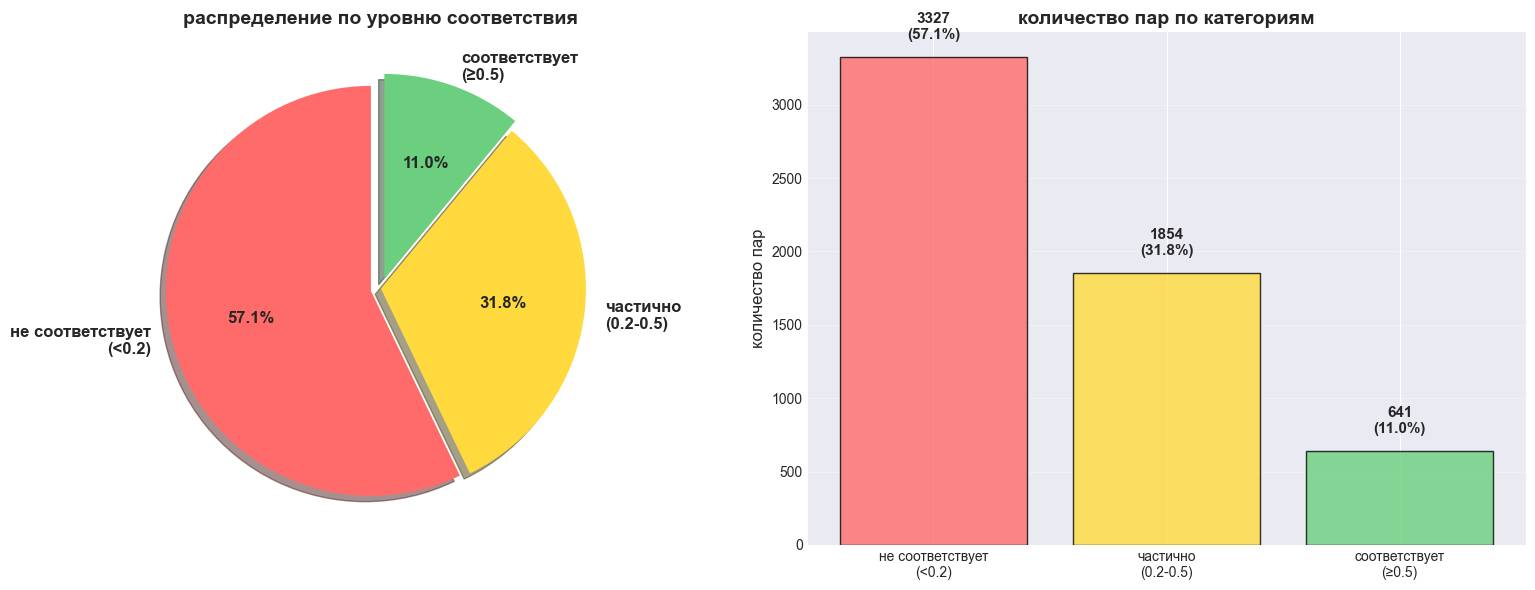



ПРИМЕРЫ ИЗ КАЖДОЙ КАТЕГОРИИ С ИЗОБРАЖЕНИЯМИ

НЕ СООТВЕТСТВУЕТ (<0.2)
всего пар в категории: 3327

примеры:


image_file  \
732   2078311270_f01c9eaf4c.jpg   
5091   398662202_97e5819b79.jpg   
5690   757046028_ff5999f91b.jpg   
1939  2646116932_232573f030.jpg   
2582  2934359101_cdf57442dc.jpg   

                                             query_text  expert_median  \
732   A football player is tackling the player with ...            1.0   
5091  A Miami basketball player dribbles by an Arizo...            1.0   
5690  A man in a white print shirt and a woman in a ...            1.0   
1939  A man wearing an orange cap sits on a white be...            1.0   
2582  A woman lies down on an old couch sitting on t...            1.0   

      combined_score  
732              0.0  
5091             0.0  
5690             0.0  
1939             0.0  
2582             0.0

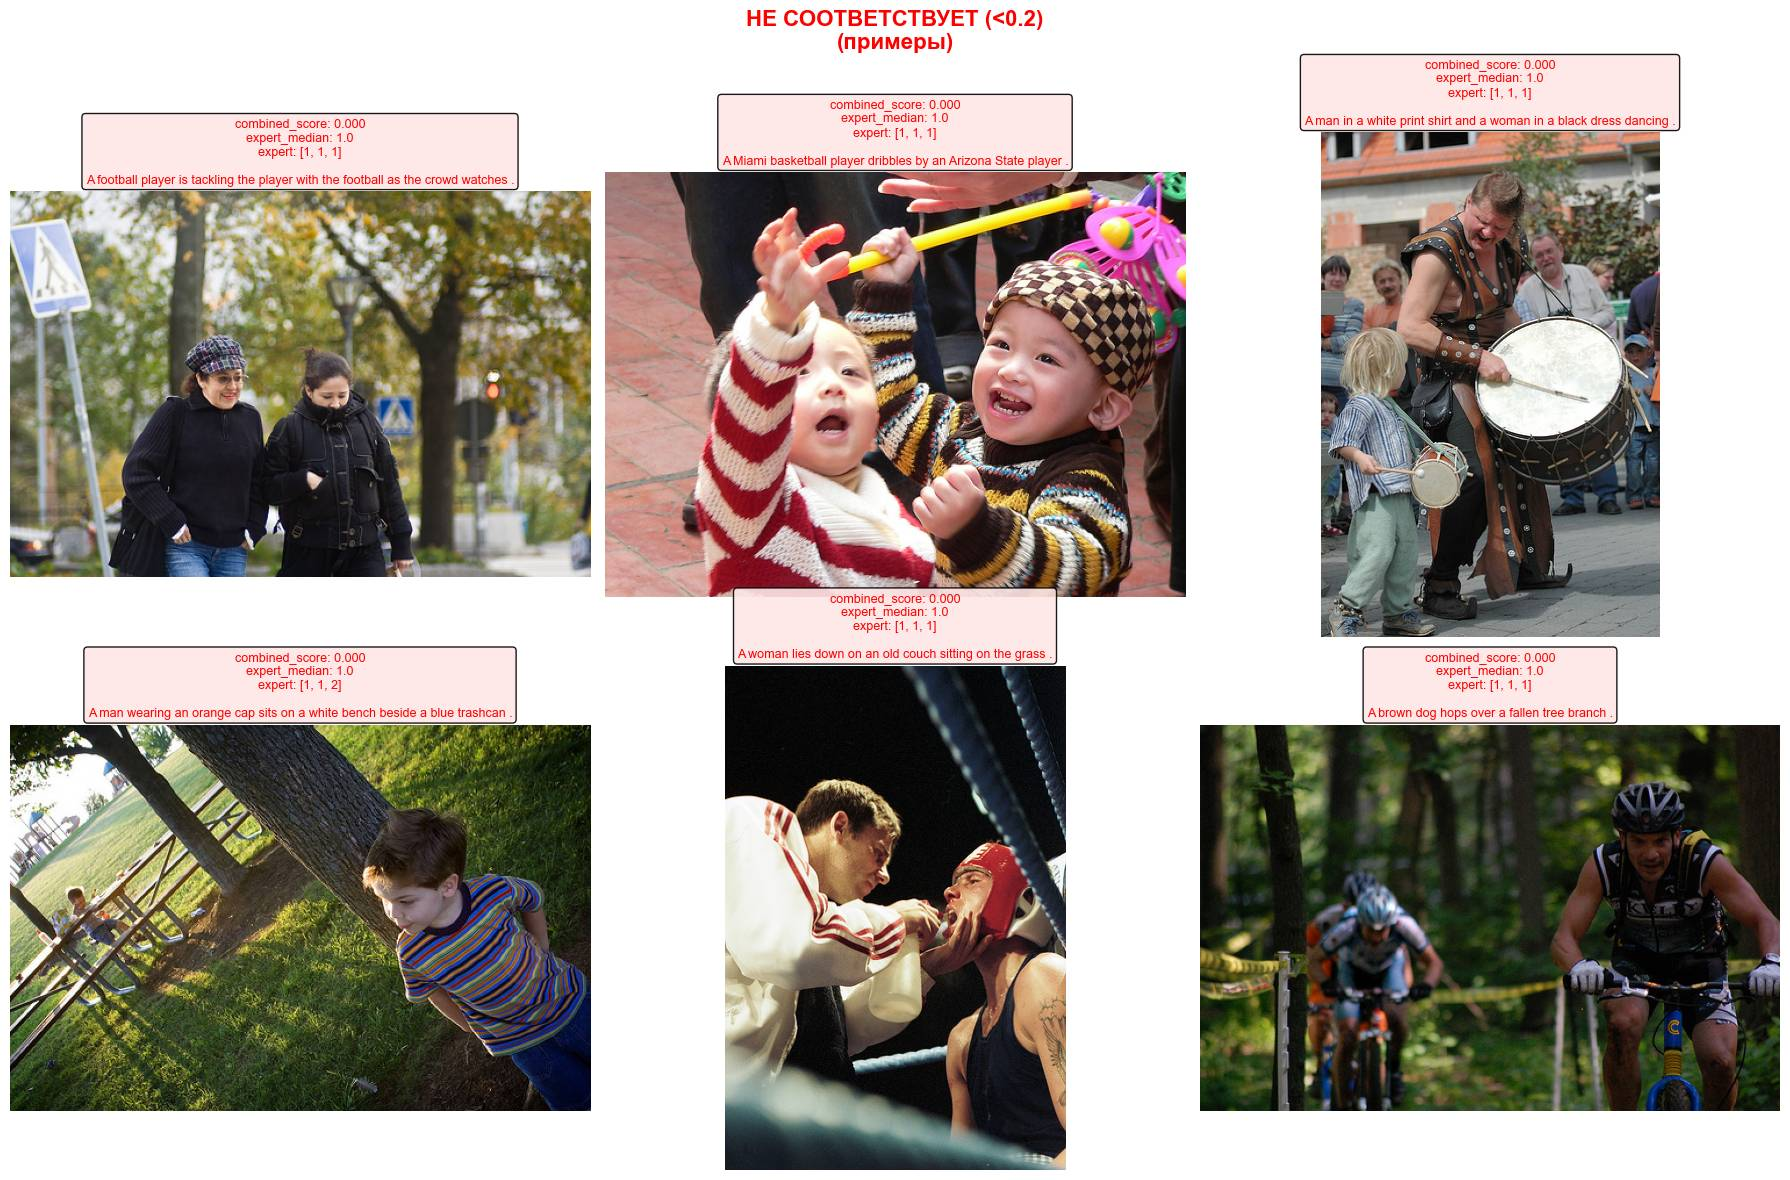


ЧАСТИЧНО СООТВЕТСТВУЕТ (0.2-0.5)
всего пар в категории: 1854

примеры:


image_file  \
758   2089426086_7acc98a3a8.jpg   
1356  2419221084_01a14176b4.jpg   
3782  3328646934_5cca4cebce.jpg   
5283   468310111_d9396abcbd.jpg   
1257  2370481277_a3085614c9.jpg   

                                             query_text  expert_median  \
758   Kids are waiting at the bottom of a staircase ...            2.0   
1356  A brown dog with a tennis ball its mouth rolli...            2.0   
3782               Person snowboarding at a ski slope .            2.0   
5283                Three dogs are playing in a field .            2.0   
1257     A soccer player jumping in air during a game .            2.0   

      combined_score  
758         0.333333  
1356        0.233333  
3782        0.233333  
5283        0.233333  
1257        0.333333

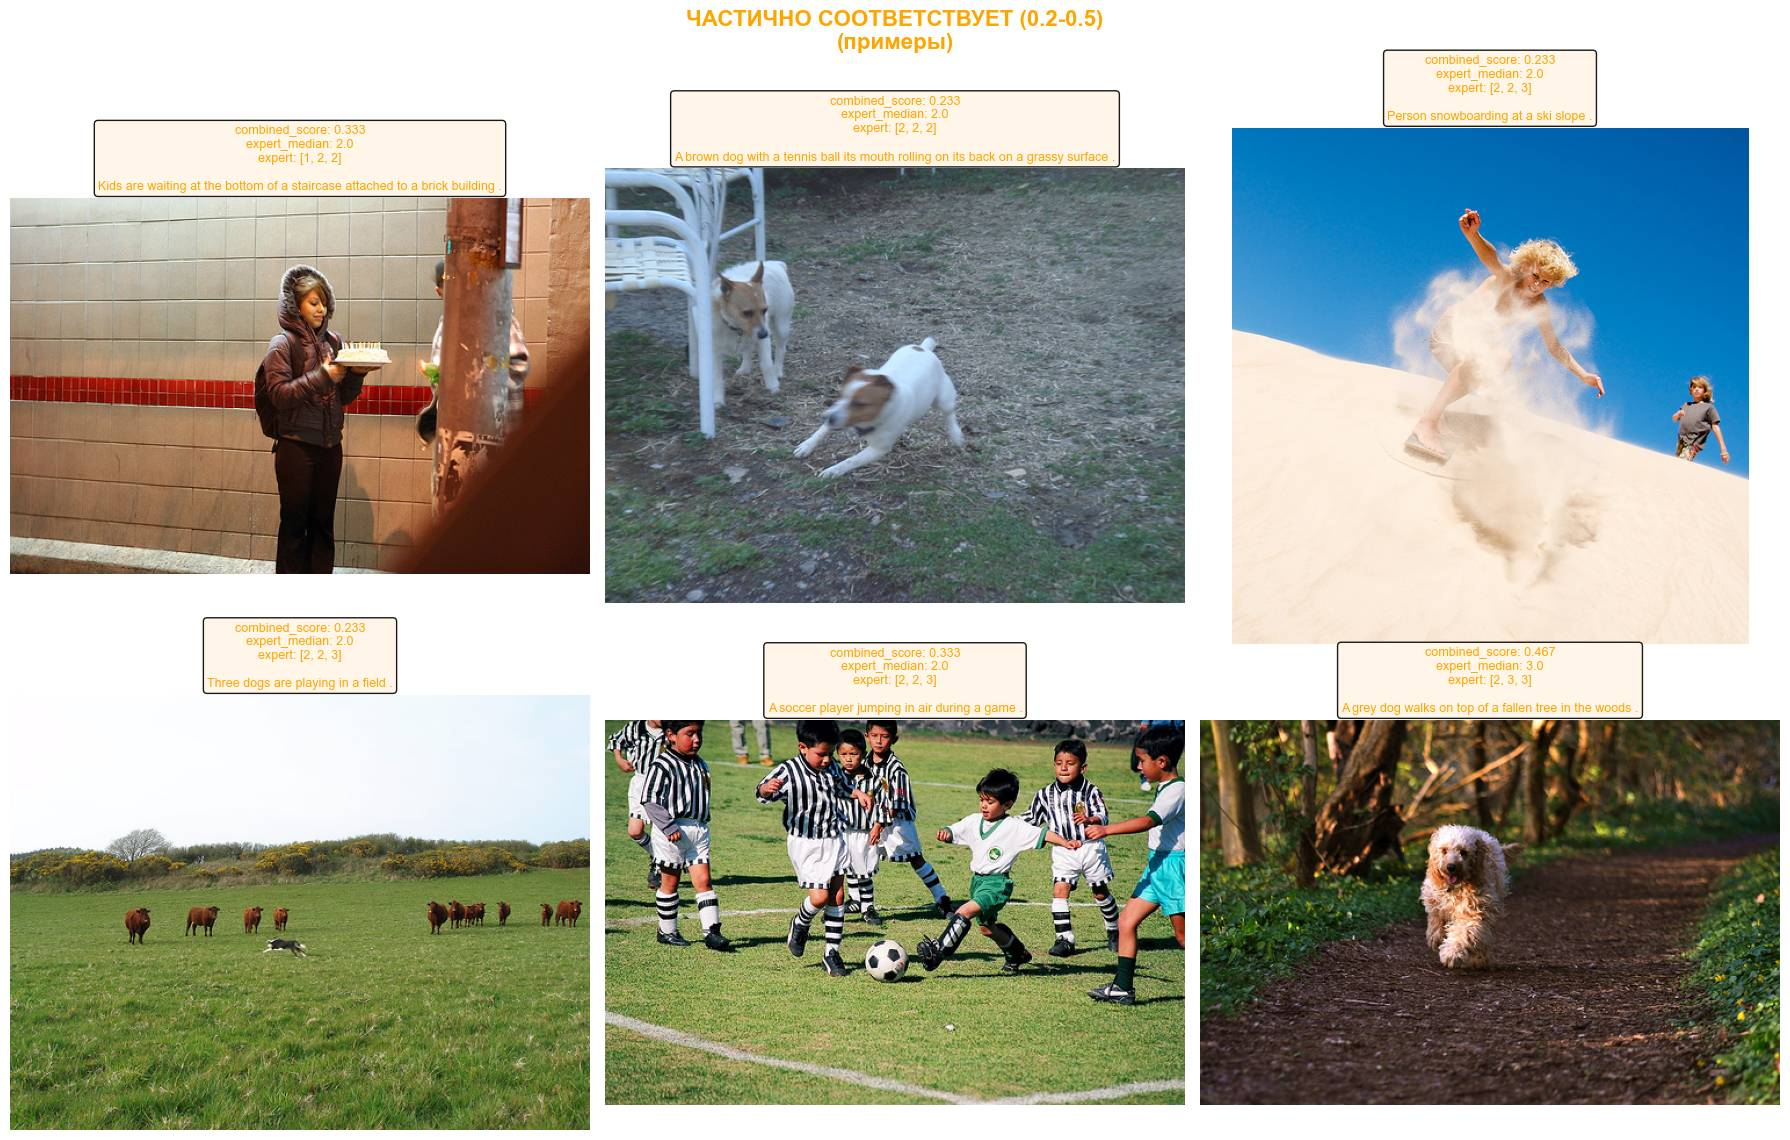


ХОРОШО СООТВЕТСТВУЕТ (≥0.5)
всего пар в категории: 641

примеры:


image_file  \
952   2206960564_325ed0c7ae.jpg   
2871  3058439373_9276a4702a.jpg   
3895  3364026240_645d533fda.jpg   
2910  3072114570_e1c0127529.jpg   
834   2148916767_644ea6a7fa.jpg   

                                             query_text  expert_median  \
952                      A dog jumps over an obstacle .            3.0   
2871  A group of people walking a city street in war...            3.0   
3895            A skier about to go down the mountain .            4.0   
2910             Some kids play outside on a nice day .            4.0   
834                  A dog runs through the deep snow .            3.0   

      combined_score  
952         0.566667  
2871        0.666667  
3895        1.000000  
2910        1.000000  
834         0.566667

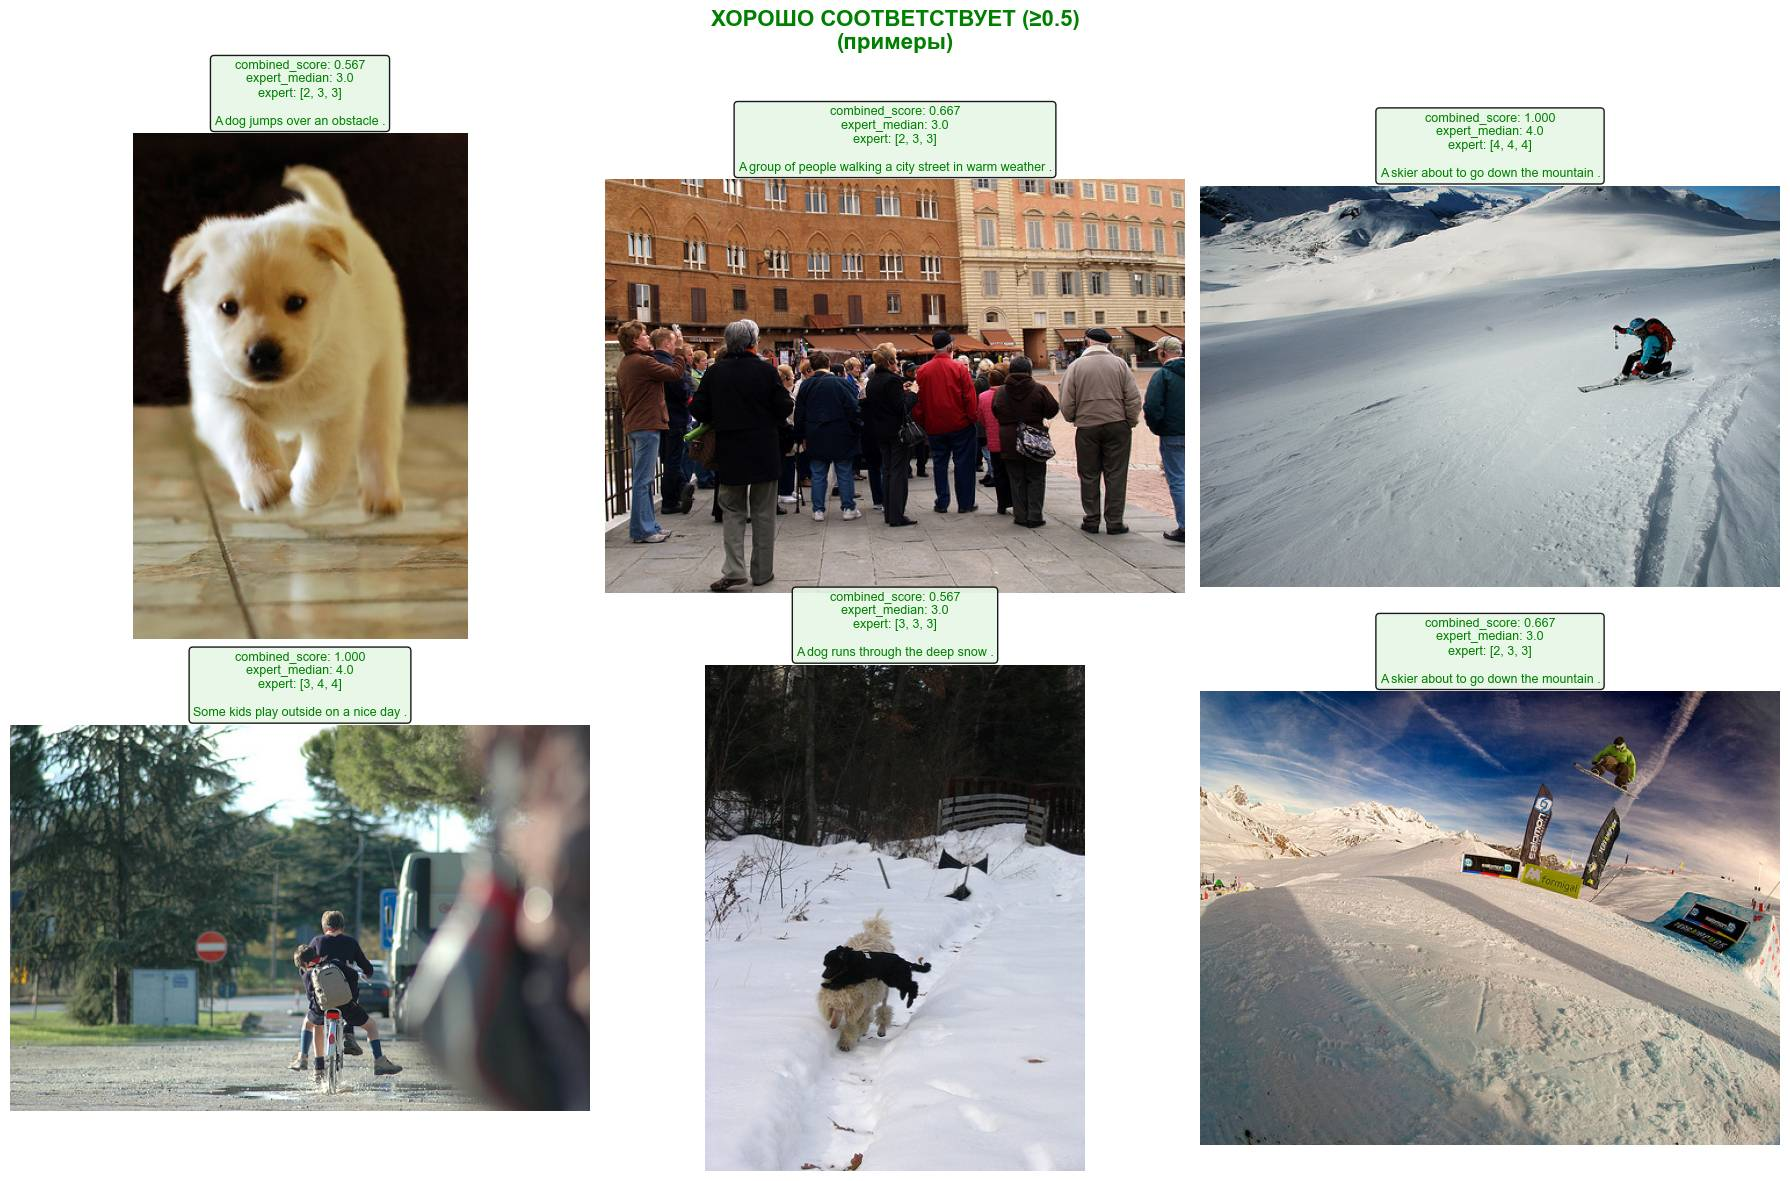


СРАВНИТЕЛЬНАЯ ВИЗУАЛИЗАЦИЯ: ПО ОДНОМУ ПРИМЕРУ ИЗ КАЖДОЙ КАТЕГОРИИ


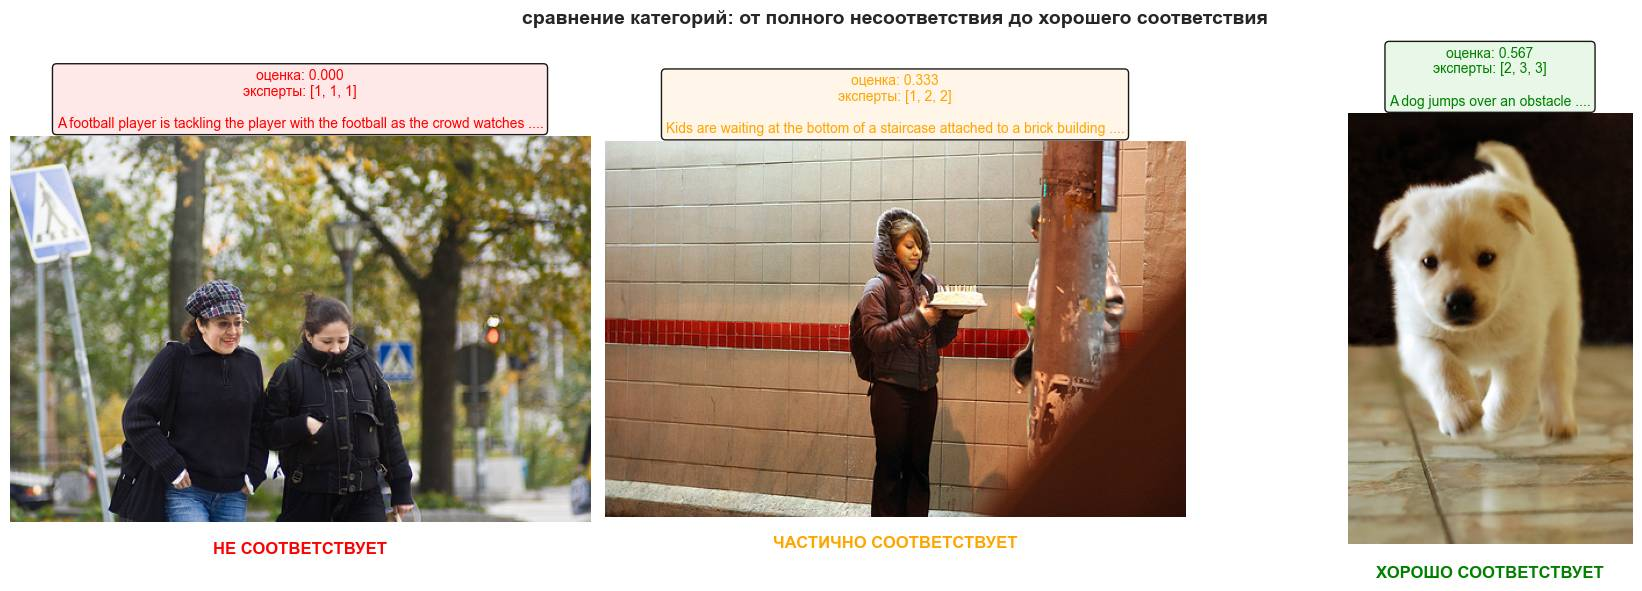

In [70]:
print("="*80)
print("АНАЛИЗ БАЛАНСА: СООТВЕТСТВИЕ VS НЕСООТВЕТСТВИЕ")
print("="*80)

# определим пороги
# оценка < 0.2 → не соответствует (эксперты ставили в основном 1)
# оценка >= 0.5 → соответствует (эксперты ставили 3-4)
# 0.2 - 0.5 → частичное соответствие

no_match = (master_df['combined_score'] < 0.2).sum()
partial_match = ((master_df['combined_score'] >= 0.2) & (master_df['combined_score'] < 0.5)).sum()
good_match = (master_df['combined_score'] >= 0.5).sum()

print(f"\nраспределение:")
print(f"  НЕ соответствует (< 0.2):      {no_match:4d} ({no_match/len(master_df)*100:.1f}%)")
print(f"  частично соответствует (0.2-0.5): {partial_match:4d} ({partial_match/len(master_df)*100:.1f}%)")
print(f"  хорошо соответствует (>= 0.5):     {good_match:4d} ({good_match/len(master_df)*100:.1f}%)")

# визуализация
labels = ['не соответствует\n(<0.2)', 'частично\n(0.2-0.5)', 'соответствует\n(≥0.5)']
sizes = [no_match, partial_match, good_match]
colors = ['#ff6b6b', '#ffd93d', '#6bcf7f']
explode = (0.05, 0, 0.05)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# круговая диаграмма
axes[0].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
            shadow=True, startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[0].set_title('распределение по уровню соответствия', fontsize=14, fontweight='bold')

# столбчатая диаграмма
axes[1].bar(labels, sizes, color=colors, edgecolor='black', alpha=0.8)
axes[1].set_ylabel('количество пар', fontsize=12)
axes[1].set_title('количество пар по категориям', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# добавим значения на столбцы
for i, (label, size) in enumerate(zip(labels, sizes)):
    pct = size / len(master_df) * 100
    axes[1].text(i, size + 100, f'{size}\n({pct:.1f}%)', 
                ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*80)

# покажем примеры из каждой категории
print("\n" + "="*80)
print("ПРИМЕРЫ ИЗ КАЖДОЙ КАТЕГОРИИ С ИЗОБРАЖЕНИЯМИ")
print("="*80)

# категории для анализа
categories = [
    (master_df[master_df['combined_score'] < 0.2], "НЕ СООТВЕТСТВУЕТ (<0.2)", 'red', '#ffe6e6'),
    (master_df[(master_df['combined_score'] >= 0.2) & (master_df['combined_score'] < 0.5)], 
     "ЧАСТИЧНО СООТВЕТСТВУЕТ (0.2-0.5)", 'orange', '#fff4e6'),
    (master_df[master_df['combined_score'] >= 0.5], "ХОРОШО СООТВЕТСТВУЕТ (≥0.5)", 'green', '#e6f7e6'),
]

for df_cat, title, color, bg_color in categories:
    if len(df_cat) > 0:
        print(f"\n{'='*80}")
        print(f"{title}")
        print(f"{'='*80}")
        print(f"всего пар в категории: {len(df_cat)}")
        
        # берём 6 случайных примеров
        n_samples = min(6, len(df_cat))
        sample = df_cat.sample(n_samples, random_state=42)
        
        # выводим таблицу
        print("\nпримеры:")
        display(sample[['image_file', 'query_text', 'expert_median', 
                        'combined_score']].head())
        
        # визуализация с изображениями
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
        
        for idx, (_, row) in enumerate(sample.iterrows()):
            if idx >= 6:
                break
                
            image_path = os.path.join(train_images_dir, row['image_file'])
            
            if os.path.exists(image_path):
                img = Image.open(image_path)
                axes[idx].imshow(img)
                axes[idx].axis('off')
                
                # информация о паре
                text_info = (
                    f"combined_score: {row['combined_score']:.3f}\n"
                    f"expert_median: {row['expert_median']}\n"
                    f"expert: [{row['expert1']}, {row['expert2']}, {row['expert3']}]\n\n"
                    f"{row['query_text']}"
                )
                axes[idx].set_title(text_info, fontsize=9, color=color,
                                   bbox=dict(boxstyle='round', facecolor=bg_color, alpha=0.9))
            else:
                axes[idx].text(0.5, 0.5, f'изображение не найдено:\n{row["image_file"]}', 
                              ha='center', va='center')
                axes[idx].axis('off')
        
        # скрываем пустые subplot'ы если примеров меньше 6
        for idx in range(n_samples, 6):
            axes[idx].axis('off')
        
        plt.suptitle(f'{title}\n(примеры)', fontsize=16, fontweight='bold', color=color)
        plt.tight_layout()
        plt.show()

# дополнительно: сравнительная визуализация - по одному примеру из каждой категории
print("\n" + "="*80)
print("СРАВНИТЕЛЬНАЯ ВИЗУАЛИЗАЦИЯ: ПО ОДНОМУ ПРИМЕРУ ИЗ КАЖДОЙ КАТЕГОРИИ")
print("="*80)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (df_cat, title, color, bg_color) in enumerate(categories):
    if len(df_cat) > 0:
        # берём один случайный пример
        sample = df_cat.sample(1, random_state=42).iloc[0]
        
        image_path = os.path.join(train_images_dir, sample['image_file'])
        
        if os.path.exists(image_path):
            img = Image.open(image_path)
            axes[idx].imshow(img)
            axes[idx].axis('off')
            
            # компактная информация
            text_info = (
                f"оценка: {sample['combined_score']:.3f}\n"
                f"эксперты: [{sample['expert1']}, {sample['expert2']}, {sample['expert3']}]\n\n"
                f"{sample['query_text'][:100]}..."
            )
            axes[idx].set_title(text_info, fontsize=10, color=color,
                               bbox=dict(boxstyle='round', facecolor=bg_color, alpha=0.9))
        else:
            axes[idx].text(0.5, 0.5, 'изображение не найдено', 
                          ha='center', va='center')
            axes[idx].axis('off')
        
        # подпись категории снизу
        axes[idx].text(0.5, -0.05, title.split('(')[0].strip(), 
                      transform=axes[idx].transAxes,
                      fontsize=12, fontweight='bold', color=color,
                      ha='center', va='top')

plt.suptitle('сравнение категорий: от полного несоответствия до хорошего соответствия', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Итоги этапа 1


ИТОГИ ШАГА 1: ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ

итоговый размер master_df: (5822, 21)

колонки в master_df:
['image_file', 'caption_id', 'expert1', 'expert2', 'expert3', 'image_from_caption_id', 'caption_number', 'expert_max', 'expert_min', 'expert_range', 'query_text', 'expert_median', 'expert_mean', 'expert_score_normalized', 'median_vs_mean_diff', 'expert_category', 'agreement_ratio_x', 'agreement_ratio_y', 'agreement_ratio', 'combined_score', 'score_category']

КЛЮЧЕВЫЕ КОЛОНКИ ДЛЯ СЛЕДУЮЩИХ ЭТАПОВ
  • image_file: имя файла изображения
  • caption_id: идентификатор описания
  • query_text: текстовое описание
  • expert1, expert2, expert3: оценки экспертов (1-4)
  • expert_median: медиана экспертных оценок
  • expert_score_normalized: нормализованная экспертная оценка [0,1]
  • agreement_ratio: краудсорсинговая оценка [0,1]
  • combined_score: ЦЕЛЕВАЯ ПЕРЕМЕННАЯ [0,1]

ИТОГОВАЯ ЦЕЛЕВАЯ ПЕРЕМЕННАЯ: combined_score

всего пар: 5822
пропусков: 0

статистика:


count    5822.000000
mean        0.183855
std         0.264816
min         0.000000
25%         0.000000
50%         0.000000
75%         0.333333
max         1.000000
Name: combined_score, dtype: float64


распределение по категориям:
score_category
очень низкое (0-0.25)     4170
низкое (0.25-0.5)         1011
высокое (0.5-0.75)         294
очень высокое (0.75-1)     347
Name: count, dtype: int64


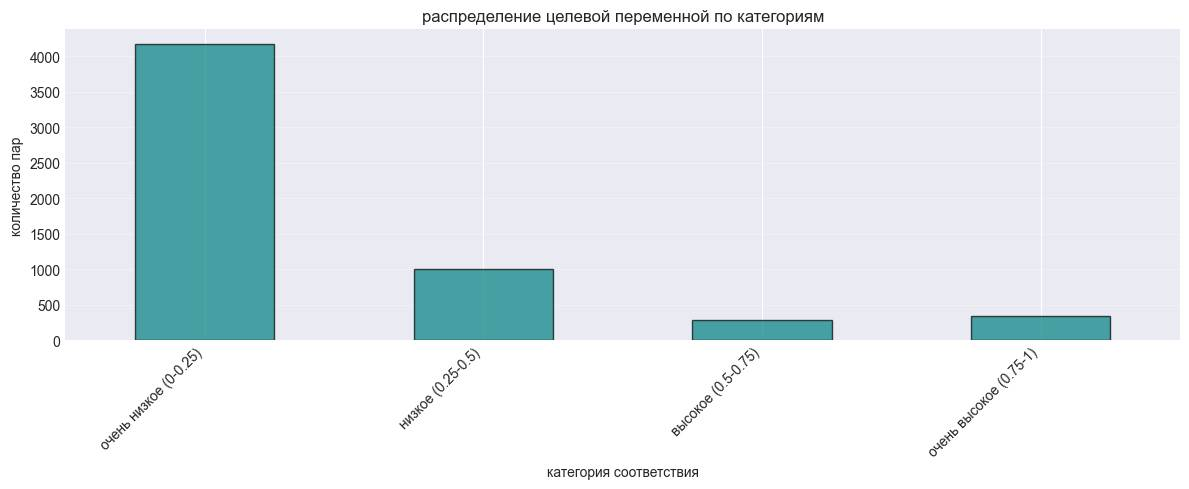


ПРОВЕРКА ДАННЫХ

пропусков в query_text: 0
пустых строк в query_text: 0

master_df готов к работе!
целевая переменная: combined_score
размер датасета: (5822, 21)


In [59]:
print("\n" + "="*80)
print("ИТОГИ ШАГА 1: ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ")
print("="*80)

# итоговая структура master_df
print(f"\nитоговый размер master_df: {master_df.shape}")
print(f"\nколонки в master_df:")
print(master_df.columns.tolist())

# ключевые колонки для обучения
print("\n" + "="*80)
print("КЛЮЧЕВЫЕ КОЛОНКИ ДЛЯ СЛЕДУЮЩИХ ЭТАПОВ")
print("="*80)

key_columns = {
    'image_file': 'имя файла изображения',
    'caption_id': 'идентификатор описания',
    'query_text': 'текстовое описание',
    'expert1, expert2, expert3': 'оценки экспертов (1-4)',
    'expert_median': 'медиана экспертных оценок',
    'expert_score_normalized': 'нормализованная экспертная оценка [0,1]',
    'agreement_ratio': 'краудсорсинговая оценка [0,1]',
    'combined_score': 'ЦЕЛЕВАЯ ПЕРЕМЕННАЯ [0,1]',
}

for col, desc in key_columns.items():
    print(f"  • {col}: {desc}")

# статистика по целевой переменной
print("\n" + "="*80)
print("ИТОГОВАЯ ЦЕЛЕВАЯ ПЕРЕМЕННАЯ: combined_score")
print("="*80)

print(f"\nвсего пар: {len(master_df)}")
print(f"пропусков: {master_df['combined_score'].isna().sum()}")
print(f"\nстатистика:")
display(master_df['combined_score'].describe())

# распределение по бинам
bins = [0, 0.25, 0.5, 0.75, 1.0]
labels = ['очень низкое (0-0.25)', 'низкое (0.25-0.5)', 'высокое (0.5-0.75)', 'очень высокое (0.75-1)']
master_df['score_category'] = pd.cut(master_df['combined_score'], bins=bins, labels=labels, include_lowest=True)

print("\nраспределение по категориям:")
print(master_df['score_category'].value_counts().sort_index())

# визуализация категорий
plt.figure(figsize=(12, 5))
master_df['score_category'].value_counts().sort_index().plot(kind='bar', color='teal', edgecolor='black', alpha=0.7)
plt.xlabel('категория соответствия')
plt.ylabel('количество пар')
plt.title('распределение целевой переменной по категориям')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# проверим наличие текстов
print("\n" + "="*80)
print("ПРОВЕРКА ДАННЫХ")
print("="*80)
print(f"\nпропусков в query_text: {master_df['query_text'].isna().sum()}")
print(f"пустых строк в query_text: {(master_df['query_text'].str.strip() == '').sum()}")

# сохраняем master_df для следующих этапов
print("\nmaster_df готов к работе!")
print(f"целевая переменная: combined_score")
print(f"размер датасета: {master_df.shape}")

Итоговые выводы по Этапу 1.7
Что мы сделали:
✅ Объединили экспертные и краудсорсинговые оценки
✅ Создали комбинированную целевую переменную (0.7×expert + 0.3×crowd)
✅ Проанализировали корреляцию (0.762 — сильная связь)
✅ Сравнили три варианта целевой переменной
Ключевые наблюдения:

Покрытие данных:

Экспертные: 100% (5822 пары)
Краудсорсинговые: 40% (2329 пар)
Комбинированные: 100% (используем экспертные где нет краудсорсинговых)


Распределения:

Все три варианта имеют сильный перекос к нулю (медиана = 0)
Среднее: эксперты (0.208) > краудворкеры (0.198) > комбинированные (0.184)
Проблема дисбаланса классов присутствует во всех вариантах


Согласованность:

Корреляция 0.762 говорит о хорошем согласии между экспертами и краудворкерами
Комбинированные оценки — разумный компромисс




🎯 Рекомендация по выбору целевой переменной:
Будем использовать combined_score как основную целевую переменную, потому что:
✅ Доступна для всех 5822 пар (100% покрытие)
✅ Учитывает обе разметки с разумными весами
✅ Эксперты и краудворкеры хорошо согласованы (корреляция 0.762)
✅ Более робастная — снижает влияние ошибок одной группы оценщиков


Краткие итоги Этапа 1 (EDA):✅ 5822 пары (изображение + описание) с оценками
✅ Целевая переменная: combined_score [0, 1]
✅ Дисбаланс классов: 71.6% пар имеют очень низкое соответствие (0-0.25)
✅ Нет пропусков в ключевых колонках
✅ Корреляция эксперты-краудворкеры: 0.762 (сильная)

# Этап 2: Проверка и фильтрация данных

## Создание списка запрещенных слов

Напишем список английских слов, которые явно указывают на детей или детскую тематику.

In [60]:
# создаём список запрещённых слов, связанных с детьми
forbidden_words = [
    # прямые упоминания возраста
    'child', 'children', 'kid', 'kids', 'baby', 'babies', 'infant', 'toddler', 
    'newborn', 'boy', 'girl', 'son', 'daughter',
    'teen', 'teenager', 'adolescent', 'youth', 'juvenile', 'minor',
    'preteen', 'tween',
    
    # места и активности
    'school', 'classroom', 'kindergarten', 'preschool', 'daycare',
    'playground', 'sandbox',
    
    # предметы
    'stroller', 'crib', 'playpen',
    
    # статусы
    'student', 'pupil', 'schoolboy', 'schoolgirl',
]

print(f"\nсоздан список из {len(forbidden_words)} запрещённых слов:")
print(forbidden_words)


создан список из 35 запрещённых слов:
['child', 'children', 'kid', 'kids', 'baby', 'babies', 'infant', 'toddler', 'newborn', 'boy', 'girl', 'son', 'daughter', 'teen', 'teenager', 'adolescent', 'youth', 'juvenile', 'minor', 'preteen', 'tween', 'school', 'classroom', 'kindergarten', 'preschool', 'daycare', 'playground', 'sandbox', 'stroller', 'crib', 'playpen', 'student', 'pupil', 'schoolboy', 'schoolgirl']


## Поиск запрещённых слов в описаниях

Найдем все пары, где текстовое описание содержит запрещённые слова.

In [63]:
# функция для проверки наличия запрещённых слов в тексте
def contains_forbidden_words(text, forbidden_list):
    """
    проверяет, содержит ли текст запрещённые слова
    
    параметры:
    - text: текст для проверки
    - forbidden_list: список запрещённых слов
    
    возвращает: True если найдено запрещённое слово, False иначе
    """
    # приводим текст к нижнему регистру
    text_lower = text.lower()
    
    # ищем каждое запрещённое слово как отдельное слово (word boundary)
    for word in forbidden_list:
        # \b - граница слова (чтобы не найти "children" в "chicken")
        pattern = r'\b' + word + r'\b'
        if re.search(pattern, text_lower):
            return True
    return False

# применяем функцию ко всем описаниям
master_df['has_forbidden_content'] = master_df['query_text'].apply(
    lambda x: contains_forbidden_words(x, forbidden_words)
)

# статистика
forbidden_count = master_df['has_forbidden_content'].sum()
forbidden_pct = (forbidden_count / len(master_df)) * 100


print(f"\nвсего пар: {len(master_df)}")
print(f"пар с запрещённым контентом: {forbidden_count} ({forbidden_pct:.2f}%)")
print(f"пар без запрещённого контента: {len(master_df) - forbidden_count} ({100-forbidden_pct:.2f}%)")


всего пар: 5822
пар с запрещённым контентом: 1349 (23.17%)
пар без запрещённого контента: 4473 (76.83%)


## Примеры найденных запрещённых описаний


ПРИМЕРЫ ОПИСАНИЙ С ЗАПРЕЩЁННЫМ КОНТЕНТОМ

найдено 1349 пар с запрещённым контентом
из них пар, где изображение СООТВЕТСТВУЕТ описанию (score >= 0.5): 86

примеры (таблица):


image_file  \
53   1131932671_c8d17751b3.jpg   
54   1131932671_c8d17751b3.jpg   
77   1174525839_7c1e6cfa86.jpg   
78   1174525839_7c1e6cfa86.jpg   
170  1298295313_db1f4c6522.jpg   
172  1298295313_db1f4c6522.jpg   
187  1322323208_c7ecb742c6.jpg   
258   136644343_0e2b423829.jpg   
310  1402640441_81978e32a9.jpg   
610   189721896_1ffe76d89e.jpg   

                                            query_text found_words  \
53               A boy jumps from one bed to another .         boy   
54                 A child jumping on a tennis court .       child   
77                  a little girl kicks into the air .        girl   
78   A little girl runs on the wet sand near the oc...        girl   
170             a boy jumps into the blue pool water .         boy   
172            A boy is about to jump into the water .         boy   
187  Two children , one of which is holding a stick...    children   
258  A boy smiling , leaning over a wagon filled wi...         boy   
310                          A boy plays in the sand .         boy   
610                       A boy climbs up some rocks .         boy   

     combined_score  expert_median  
53         1.000000            4.0  
54         0.766667            3.0  
77         0.666667            3.0  
78         0.766667            3.0  
170        0.666667            3.0  
172        0.666667            3.0  
187        1.000000            4.0  
258        0.566667            3.0  
310        1.000000            4.0  
610        0.766667            3.0


ВИЗУАЛИЗАЦИЯ: ИЗОБРАЖЕНИЯ, КОТОРЫЕ СООТВЕТСТВУЮТ ЗАПРЕЩЁННЫМ ОПИСАНИЯМ


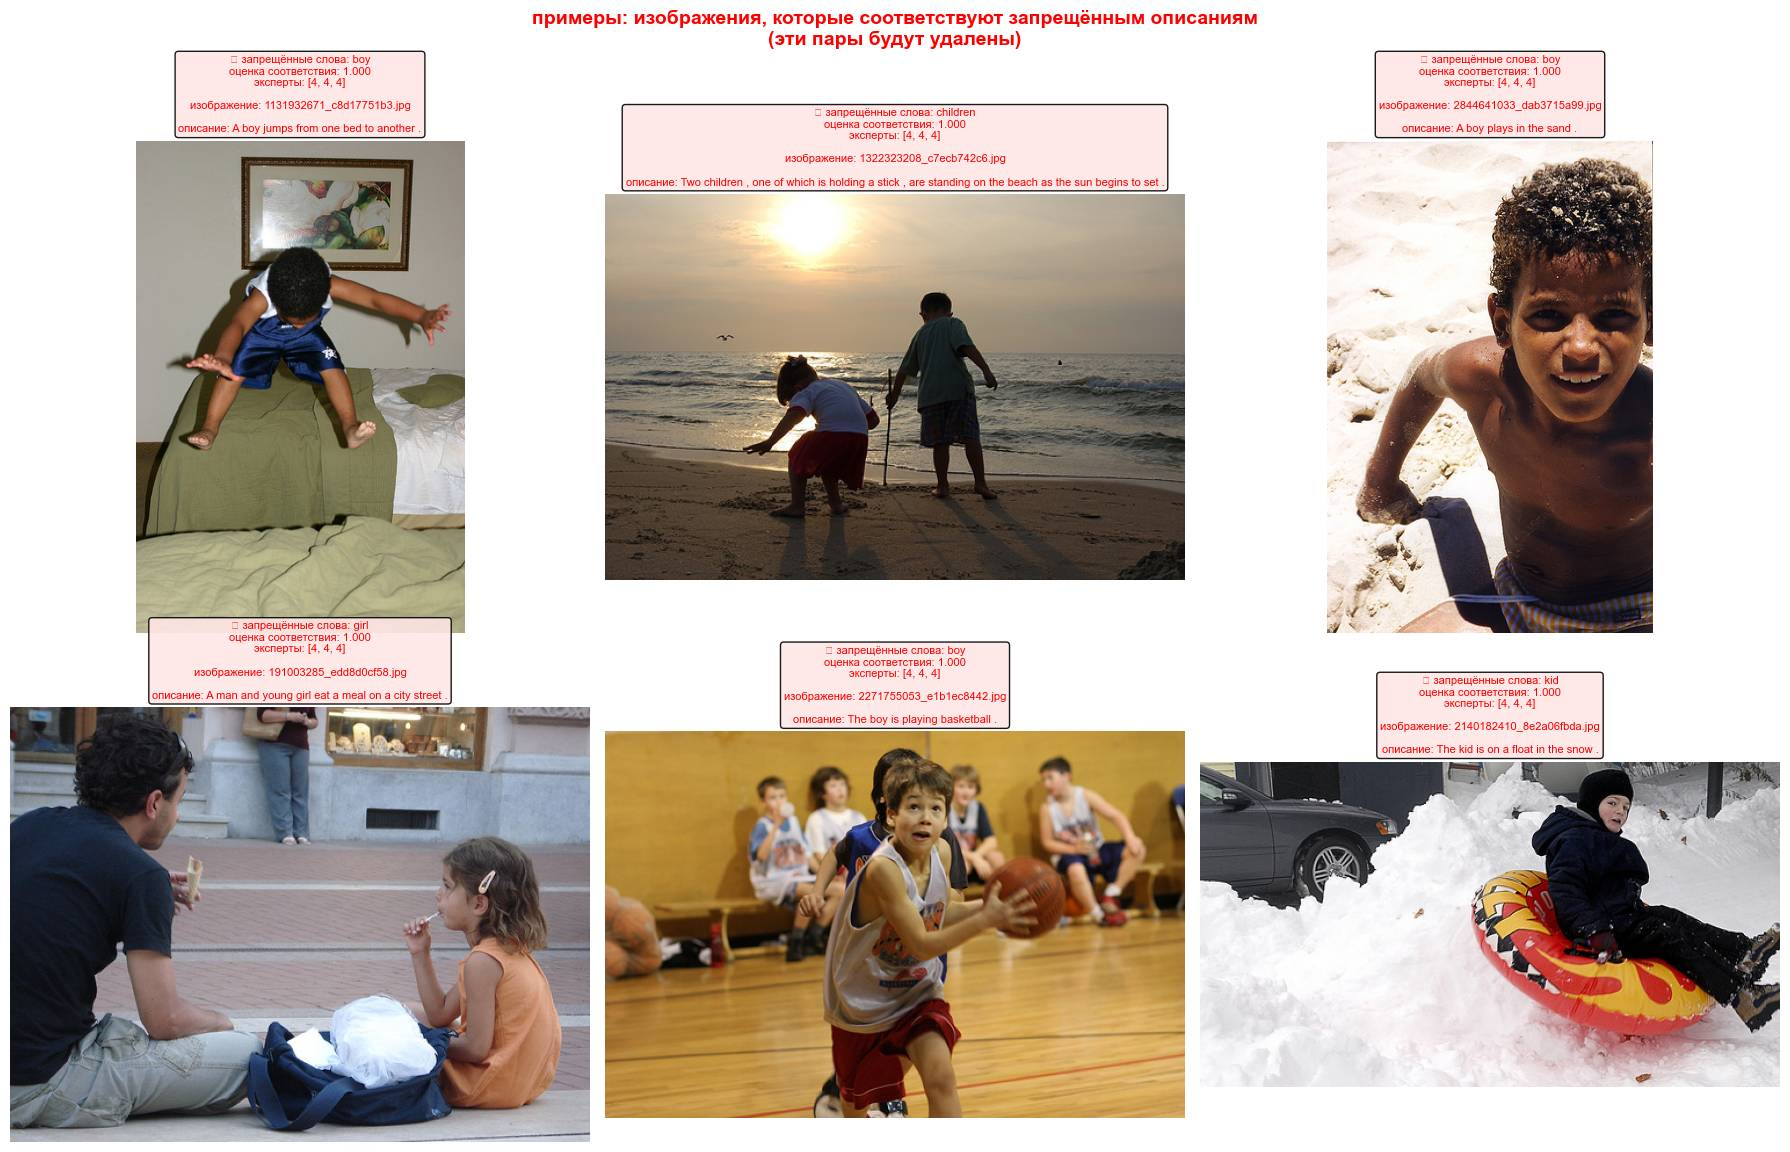


СТАТИСТИКА ПО ЗАПРЕЩЁННЫМ СЛОВАМ

топ-15 наиболее частых запрещённых слов:
  boy                 :  491 раз (36.40%)
  girl                :  411 раз (30.47%)
  child               :  243 раз (18.01%)
  children            :  106 раз ( 7.86%)
  baby                :   61 раз ( 4.52%)
  playground          :   54 раз ( 4.00%)
  kids                :   48 раз ( 3.56%)
  toddler             :   44 раз ( 3.26%)
  kid                 :   39 раз ( 2.89%)
  stroller            :   17 раз ( 1.26%)
  babies              :    6 раз ( 0.44%)
  school              :    5 раз ( 0.37%)
  youth               :    4 раз ( 0.30%)

ТОП-10 ЗАПРЕЩЁННЫХ СЛОВ: ИЗОБРАЖЕНИЯ, СООТВЕТСТВУЮЩИЕ ОПИСАНИЯМ


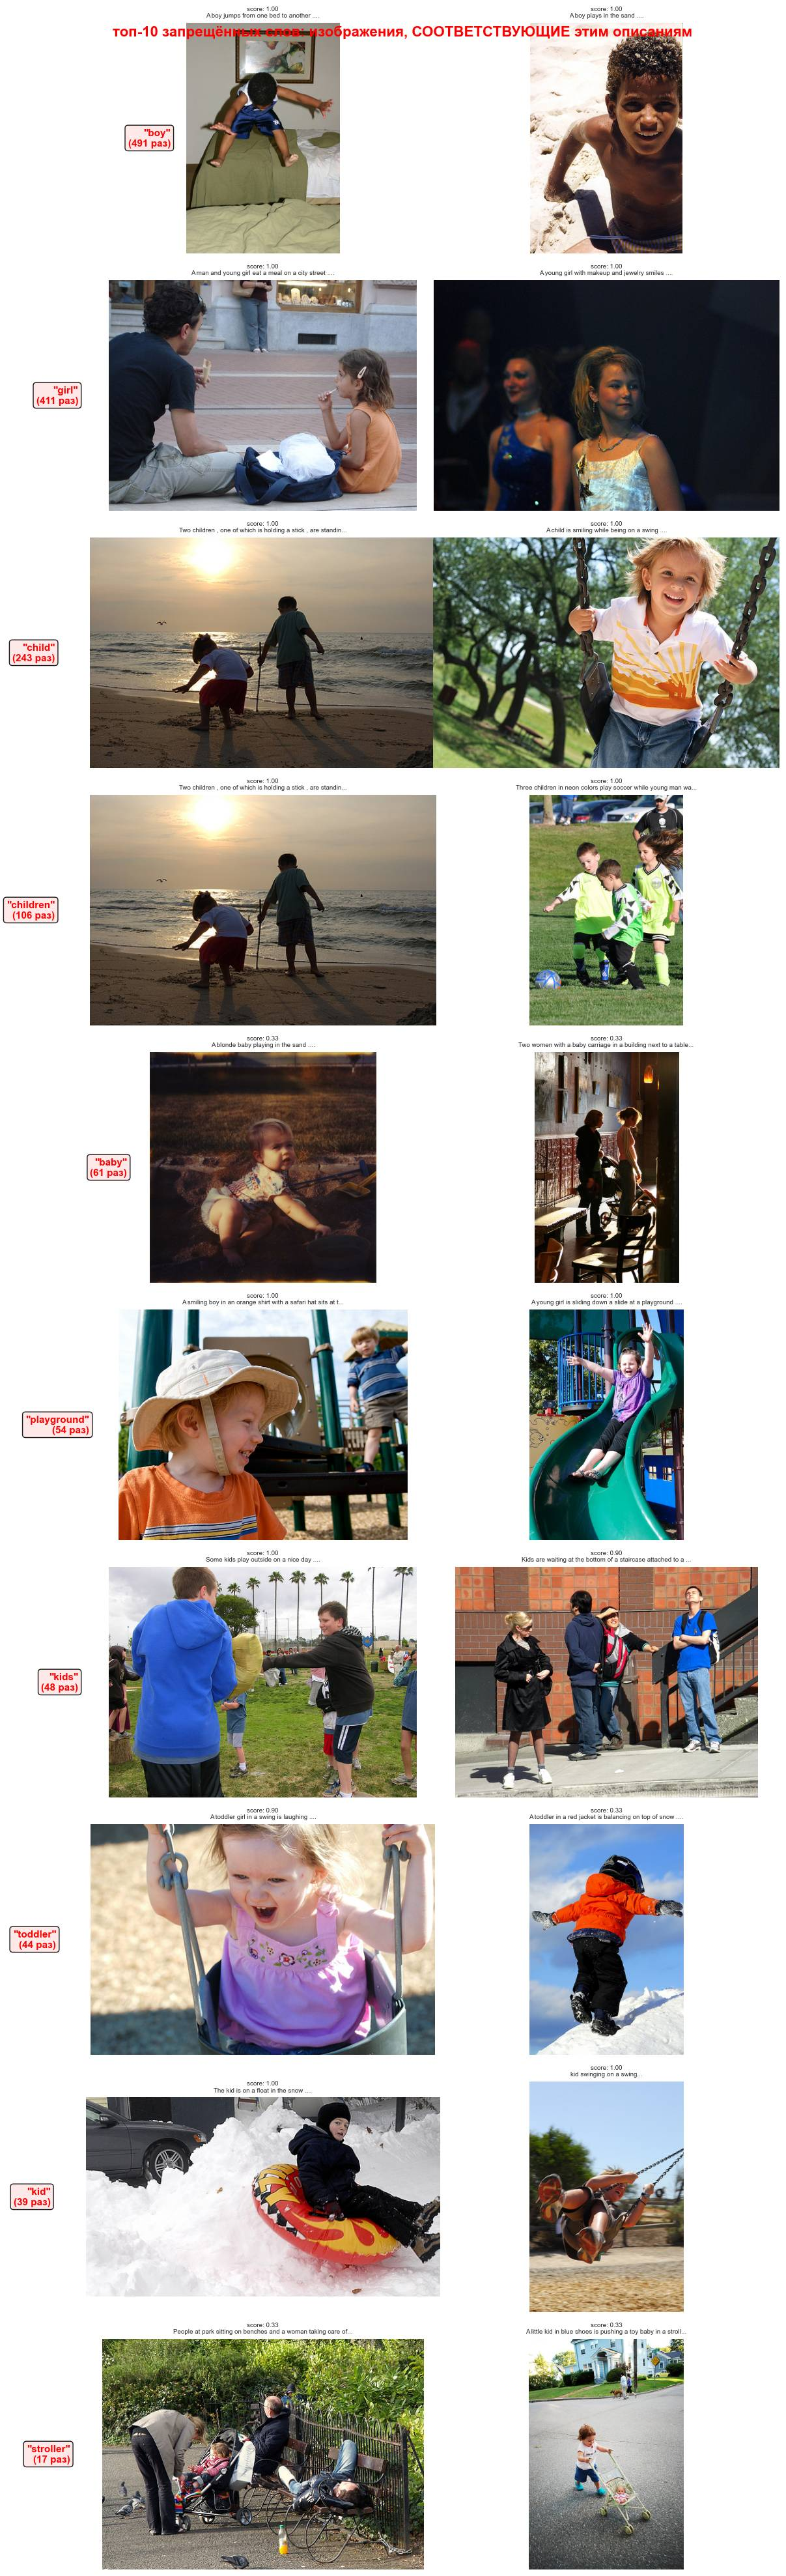

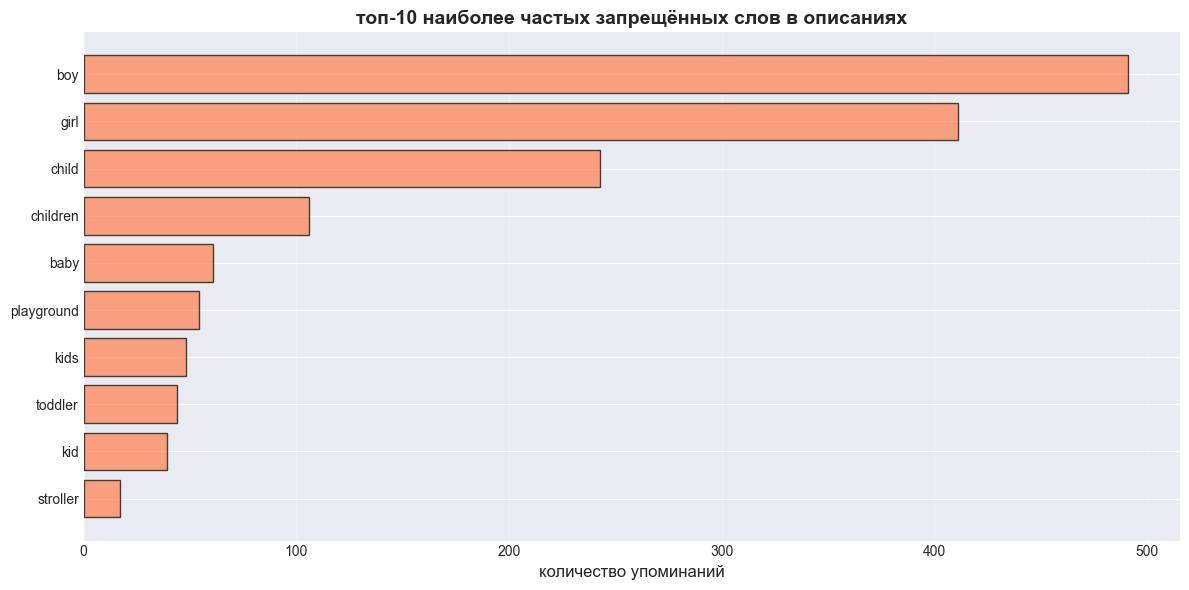

In [71]:
print("\n" + "="*80)
print("ПРИМЕРЫ ОПИСАНИЙ С ЗАПРЕЩЁННЫМ КОНТЕНТОМ")
print("="*80)

# посмотрим на примеры найденного запрещённого контента
forbidden_examples = master_df[master_df['has_forbidden_content'] == True].copy()

# найдём, какие именно запрещённые слова встречаются
def find_forbidden_words_in_text(text, forbidden_list):
    """находит все запрещённые слова в тексте"""
    text_lower = text.lower()
    found_words = []
    for word in forbidden_list:
        pattern = r'\b' + word + r'\b'
        if re.search(pattern, text_lower):
            found_words.append(word)
    return ', '.join(found_words)

forbidden_examples['found_words'] = forbidden_examples['query_text'].apply(
    lambda x: find_forbidden_words_in_text(x, forbidden_words)
)

print(f"\nнайдено {len(forbidden_examples)} пар с запрещённым контентом")

# ВАЖНО: берём только те пары, где изображение СООТВЕТСТВУЕТ описанию
# то есть где combined_score достаточно высокий
matching_forbidden = forbidden_examples[forbidden_examples['combined_score'] >= 0.5].copy()

print(f"из них пар, где изображение СООТВЕТСТВУЕТ описанию (score >= 0.5): {len(matching_forbidden)}")

if len(matching_forbidden) == 0:
    print("\n⚠️ нет пар с высоким соответствием! попробуем с порогом >= 0.3")
    matching_forbidden = forbidden_examples[forbidden_examples['combined_score'] >= 0.3].copy()
    print(f"пар с score >= 0.3: {len(matching_forbidden)}")

if len(matching_forbidden) == 0:
    print("\n⚠️ всё ещё нет! берём все пары, сортируем по убыванию оценки")
    matching_forbidden = forbidden_examples.sort_values('combined_score', ascending=False)

print("\nпримеры (таблица):")
display(matching_forbidden[['image_file', 'query_text', 'found_words', 
                             'combined_score', 'expert_median']].head(10))

# визуализация с изображениями
print("\n" + "="*80)
print("ВИЗУАЛИЗАЦИЯ: ИЗОБРАЖЕНИЯ, КОТОРЫЕ СООТВЕТСТВУЮТ ЗАПРЕЩЁННЫМ ОПИСАНИЯМ")
print("="*80)

# возьмём топ-6 пар с наивысшим соответствием
sample_forbidden = matching_forbidden.nlargest(6, 'combined_score')

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (_, row) in enumerate(sample_forbidden.iterrows()):
    # ВАЖНО: показываем изображение из image_from_caption_id (то, которое соответствует описанию)
    # но описание относится к другому изображению
    # на самом деле, нужно показать изображение ИЗ caption_id, а не image_file!
    
    # caption_id содержит имя изображения, которому принадлежит описание
    caption_image = row['image_from_caption_id']
    image_path = os.path.join(train_images_dir, caption_image)
    
    if os.path.exists(image_path):
        img = Image.open(image_path)
        axes[idx].imshow(img)
        axes[idx].axis('off')
        
        text_info = (
            f"🚫 запрещённые слова: {row['found_words']}\n"
            f"оценка соответствия: {row['combined_score']:.3f}\n"
            f"эксперты: [{row['expert1']}, {row['expert2']}, {row['expert3']}]\n\n"
            f"изображение: {caption_image}\n\n"
            f"описание: {row['query_text']}"
        )
        axes[idx].set_title(text_info, fontsize=8, color='red',
                           bbox=dict(boxstyle='round', facecolor='#ffe6e6', alpha=0.9))
    else:
        axes[idx].text(0.5, 0.5, f'изображение не найдено:\n{caption_image}', 
                      ha='center', va='center')
        axes[idx].axis('off')

plt.suptitle('примеры: изображения, которые соответствуют запрещённым описаниям\n(эти пары будут удалены)', 
             fontsize=14, fontweight='bold', color='red')
plt.tight_layout()
plt.show()

# статистика по найденным словам
print("\n" + "="*80)
print("СТАТИСТИКА ПО ЗАПРЕЩЁННЫМ СЛОВАМ")
print("="*80)

# подсчитаем частоту каждого запрещённого слова
word_counts = {}
for words_str in forbidden_examples['found_words']:
    for word in words_str.split(', '):
        if word:
            word_counts[word] = word_counts.get(word, 0) + 1

# сортируем по частоте
sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

print("\nтоп-15 наиболее частых запрещённых слов:")
for word, count in sorted_words[:15]:
    pct = (count / len(forbidden_examples)) * 100
    print(f"  {word:20s}: {count:4d} раз ({pct:5.2f}%)")

# визуализация топ-10 с СООТВЕТСТВУЮЩИМИ изображениями
print("\n" + "="*80)
print("ТОП-10 ЗАПРЕЩЁННЫХ СЛОВ: ИЗОБРАЖЕНИЯ, СООТВЕТСТВУЮЩИЕ ОПИСАНИЯМ")
print("="*80)

top_10_words = sorted_words[:10]

# для каждого слова покажем по 2 примера с ВЫСОКИМ соответствием
fig, axes = plt.subplots(10, 2, figsize=(12, 40))

for idx, (word, count) in enumerate(top_10_words):
    # находим примеры с этим словом И высоким соответствием
    examples_with_word = forbidden_examples[
        forbidden_examples['found_words'].str.contains(word)
    ].nlargest(2, 'combined_score')
    
    for col_idx, (_, row) in enumerate(examples_with_word.iterrows()):
        if col_idx >= 2:
            break
        
        # показываем изображение, которому принадлежит описание
        caption_image = row['image_from_caption_id']
        image_path = os.path.join(train_images_dir, caption_image)
        
        if os.path.exists(image_path):
            img = Image.open(image_path)
            axes[idx, col_idx].imshow(img)
            axes[idx, col_idx].axis('off')
            
            text_info = f"score: {row['combined_score']:.2f}\n{row['query_text'][:60]}..."
            axes[idx, col_idx].set_title(text_info, fontsize=7)
        else:
            axes[idx, col_idx].text(0.5, 0.5, 'изображение не найдено', 
                                   ha='center', va='center', fontsize=8)
            axes[idx, col_idx].axis('off')
    
    # заголовок для строки
    axes[idx, 0].text(-0.1, 0.5, f'"{word}"\n({count} раз)', 
                      transform=axes[idx, 0].transAxes,
                      fontsize=11, fontweight='bold', color='red',
                      ha='right', va='center',
                      bbox=dict(boxstyle='round', facecolor='#ffe6e6', alpha=0.9))

plt.suptitle('топ-10 запрещённых слов: изображения, СООТВЕТСТВУЮЩИЕ этим описаниям', 
             fontsize=16, fontweight='bold', color='red')
plt.tight_layout()
plt.show()

# график частоты слов
words = [w[0] for w in top_10_words]
counts = [w[1] for w in top_10_words]

plt.figure(figsize=(12, 6))
plt.barh(words[::-1], counts[::-1], color='coral', edgecolor='black', alpha=0.7)
plt.xlabel('количество упоминаний', fontsize=12)
plt.title('топ-10 наиболее частых запрещённых слов в описаниях', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## Удаление запрещённого контента из датасета

Удалим запрещённый контент и проверим, как это повлияло на распределение данных и баланс классов

размер датасета ДО фильтрации: 5822 пар
пар с запрещённым контентом: 1349 (23.17%)

размер датасета ПОСЛЕ фильтрации: 4473 пар
удалено пар: 1349 (23.17%)

СТАТИСТИКА ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ПОСЛЕ ФИЛЬТРАЦИИ

статистика combined_score:


count    4473.000000
mean        0.195636
std         0.274522
min         0.000000
25%         0.000000
50%         0.000000
75%         0.333333
max         1.000000
Name: combined_score, dtype: float64

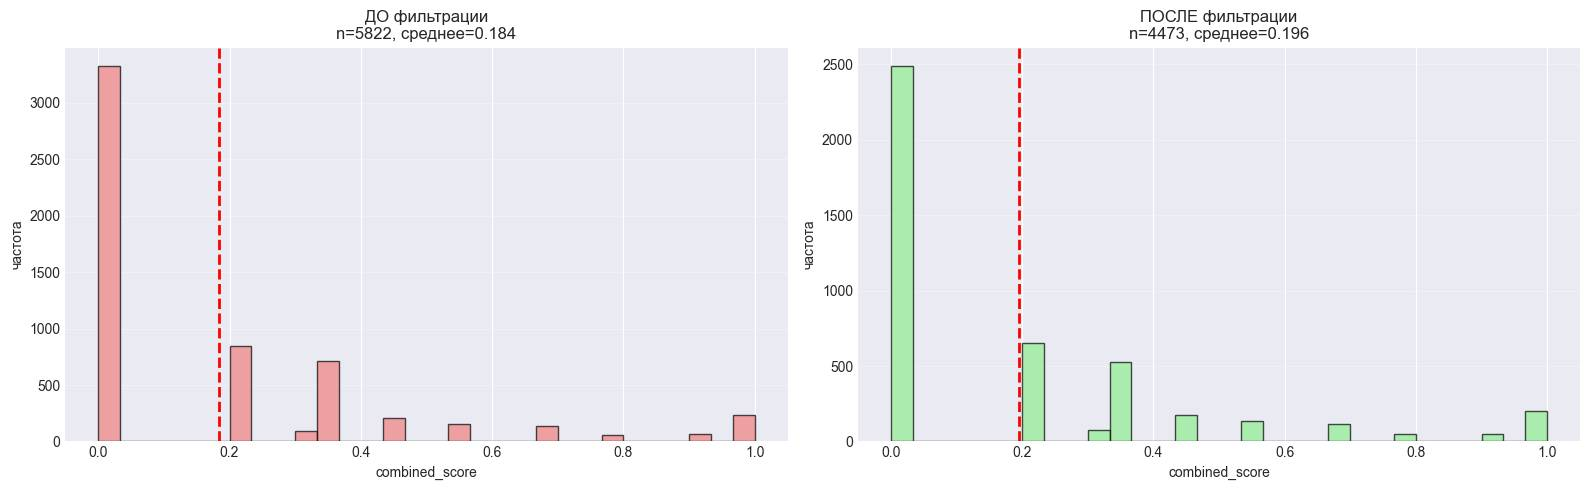


СРАВНЕНИЕ БАЛАНСА КАТЕГОРИЙ

сравнение количества пар по категориям:


категория  до фильтрации  после фильтрации
0  не соответствует\n(<0.2)           3327              2490
1       частично\n(0.2-0.5)           1854              1428
2     соответствует\n(≥0.5)            641               555

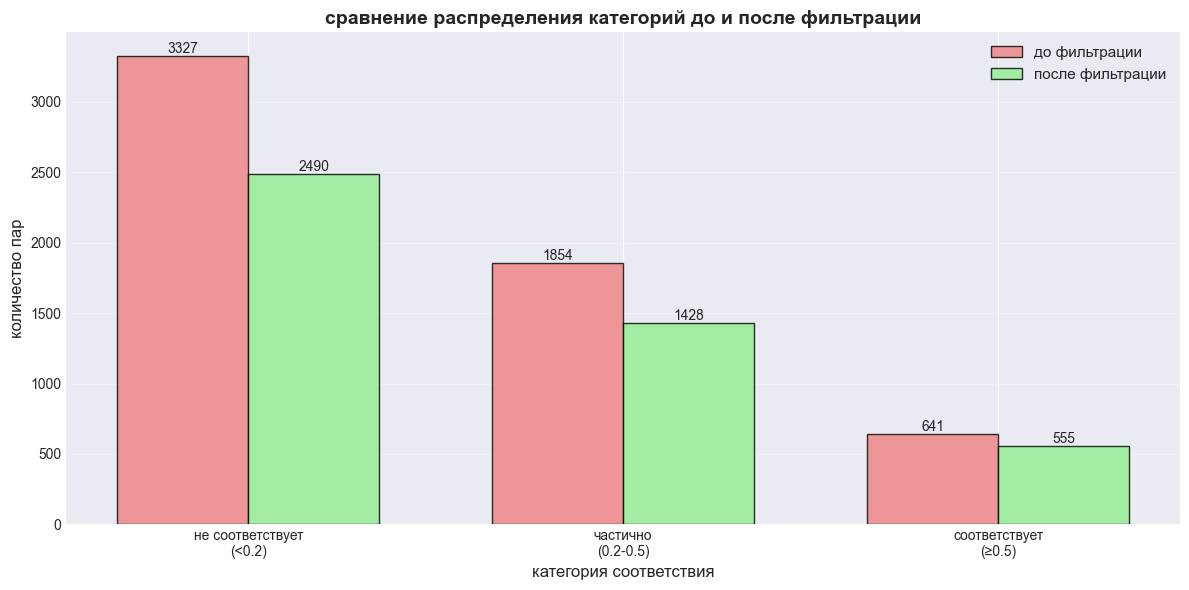

In [72]:
# сохраним размер до удаления
before_size = len(master_df)

print(f"размер датасета ДО фильтрации: {before_size} пар")
print(f"пар с запрещённым контентом: {master_df['has_forbidden_content'].sum()} ({master_df['has_forbidden_content'].sum()/before_size*100:.2f}%)")

# удаляем строки с запрещённым контентом
master_df_filtered = master_df[master_df['has_forbidden_content'] == False].copy()

# размер после удаления
after_size = len(master_df_filtered)
removed = before_size - after_size

print(f"\nразмер датасета ПОСЛЕ фильтрации: {after_size} пар")
print(f"удалено пар: {removed} ({removed/before_size*100:.2f}%)")

# проверим распределение целевой переменной после фильтрации
print("\n" + "="*80)
print("СТАТИСТИКА ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ПОСЛЕ ФИЛЬТРАЦИИ")
print("="*80)

print("\nстатистика combined_score:")
display(master_df_filtered['combined_score'].describe())

# сравним распределение до и после
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# до фильтрации
axes[0].hist(master_df['combined_score'], bins=30, edgecolor='black', alpha=0.7, color='lightcoral')
axes[0].set_xlabel('combined_score')
axes[0].set_ylabel('частота')
axes[0].set_title(f'ДО фильтрации\nn={len(master_df)}, среднее={master_df["combined_score"].mean():.3f}')
axes[0].axvline(master_df['combined_score'].mean(), color='red', linestyle='--', linewidth=2)
axes[0].grid(axis='y', alpha=0.3)

# после фильтрации
axes[1].hist(master_df_filtered['combined_score'], bins=30, edgecolor='black', alpha=0.7, color='lightgreen')
axes[1].set_xlabel('combined_score')
axes[1].set_ylabel('частота')
axes[1].set_title(f'ПОСЛЕ фильтрации\nn={len(master_df_filtered)}, среднее={master_df_filtered["combined_score"].mean():.3f}')
axes[1].axvline(master_df_filtered['combined_score'].mean(), color='red', linestyle='--', linewidth=2)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# сравним баланс категорий
print("\n" + "="*80)
print("СРАВНЕНИЕ БАЛАНСА КАТЕГОРИЙ")
print("="*80)

# до фильтрации
no_match_before = (master_df['combined_score'] < 0.2).sum()
partial_before = ((master_df['combined_score'] >= 0.2) & (master_df['combined_score'] < 0.5)).sum()
good_before = (master_df['combined_score'] >= 0.5).sum()

# после фильтрации
no_match_after = (master_df_filtered['combined_score'] < 0.2).sum()
partial_after = ((master_df_filtered['combined_score'] >= 0.2) & (master_df_filtered['combined_score'] < 0.5)).sum()
good_after = (master_df_filtered['combined_score'] >= 0.5).sum()

comparison_data = {
    'категория': ['не соответствует\n(<0.2)', 'частично\n(0.2-0.5)', 'соответствует\n(≥0.5)'],
    'до фильтрации': [no_match_before, partial_before, good_before],
    'после фильтрации': [no_match_after, partial_after, good_after]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nсравнение количества пар по категориям:")
display(comparison_df)

# визуализация сравнения
x = np.arange(len(comparison_data['категория']))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, comparison_data['до фильтрации'], width, 
               label='до фильтрации', color='lightcoral', edgecolor='black', alpha=0.8)
bars2 = ax.bar(x + width/2, comparison_data['после фильтрации'], width, 
               label='после фильтрации', color='lightgreen', edgecolor='black', alpha=0.8)

ax.set_xlabel('категория соответствия', fontsize=12)
ax.set_ylabel('количество пар', fontsize=12)
ax.set_title('сравнение распределения категорий до и после фильтрации', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_data['категория'])
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# добавим значения на столбцы
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Итоги этапа 2

In [73]:
print("\n" + "="*80)
print("ИТОГИ ЭТАПА 2: ФИЛЬТРАЦИЯ ДАННЫХ")
print("="*80)

print(f"\n✅ ЗАВЕРШЕНО!")
print(f"\nисходный датасет: {before_size} пар")
print(f"удалено пар с запрещённым контентом: {removed} ({removed/before_size*100:.2f}%)")
print(f"итоговый датасет: {after_size} пар")

print(f"\nцелевая переменная: combined_score")
print(f"среднее до фильтрации: {master_df['combined_score'].mean():.3f}")
print(f"среднее после фильтрации: {master_df_filtered['combined_score'].mean():.3f}")

print("\n" + "="*80)
print("ГОТОВО К СЛЕДУЮЩЕМУ ЭТАПУ!")
print("="*80)
print("""
следующие шаги:
  1. ✅ EDA завершён
  2. ✅ Фильтрация запрещённого контента выполнена
  3. 🔄 Дальше: Векторизация изображений (ResNet50)
  4. 🔄 Дальше: Векторизация текстов (BERT)
  5. 🔄 Дальше: Обучение моделей
  6. 🔄 Дальше: Тестирование
""")

# сохраним отфильтрованный датасет
master_df_filtered.to_csv('master_df_filtered.csv', index=False)
print("\n💾 отфильтрованный датасет сохранён: master_df_filtered.csv")

# обновим основной датасет
master_df = master_df_filtered.copy()
print("✅ master_df обновлён (теперь содержит только разрешённый контент)")


ИТОГИ ЭТАПА 2: ФИЛЬТРАЦИЯ ДАННЫХ

✅ ЗАВЕРШЕНО!

исходный датасет: 5822 пар
удалено пар с запрещённым контентом: 1349 (23.17%)
итоговый датасет: 4473 пар

целевая переменная: combined_score
среднее до фильтрации: 0.184
среднее после фильтрации: 0.196

ГОТОВО К СЛЕДУЮЩЕМУ ЭТАПУ!

следующие шаги:
  1. ✅ EDA завершён
  2. ✅ Фильтрация запрещённого контента выполнена
  3. 🔄 Дальше: Векторизация изображений (ResNet50)
  4. 🔄 Дальше: Векторизация текстов (BERT)
  5. 🔄 Дальше: Обучение моделей
  6. 🔄 Дальше: Тестирование


💾 отфильтрованный датасет сохранён: master_df_filtered.csv
✅ master_df обновлён (теперь содержит только разрешённый контент)


In [74]:
print("\n" + "="*80)
print("ИТОГИ ЭТАПА 2: ФИЛЬТРАЦИЯ ДАННЫХ ПО ЮРИДИЧЕСКИМ ОГРАНИЧЕНИЯМ")
print("="*80)

print(f"\n✅ ФИЛЬТРАЦИЯ ЗАВЕРШЕНА!")

print(f"\n📊 СТАТИСТИКА:")
print(f"  исходный датасет: {before_size} пар")
print(f"  удалено пар с запрещённым контентом: {removed} ({removed/before_size*100:.2f}%)")
print(f"  итоговый датасет: {after_size} пар")

print(f"\n🎯 ЦЕЛЕВАЯ ПЕРЕМЕННАЯ:")
print(f"  среднее до фильтрации: {master_df['combined_score'].mean():.3f}")
print(f"  среднее после фильтрации: {master_df_filtered['combined_score'].mean():.3f}")
print(f"  изменение среднего: {(master_df_filtered['combined_score'].mean() - master_df['combined_score'].mean()):.3f}")

print(f"\n📈 БАЛАНС КАТЕГОРИЙ ПОСЛЕ ФИЛЬТРАЦИИ:")
print(f"  не соответствует (<0.2): {no_match_after} ({no_match_after/after_size*100:.1f}%)")
print(f"  частично (0.2-0.5): {partial_after} ({partial_after/after_size*100:.1f}%)")
print(f"  соответствует (≥0.5): {good_after} ({good_after/after_size*100:.1f}%)")

print(f"\n🚫 ТОП-3 ЗАПРЕЩЁННЫХ СЛОВА:")
for word, count in sorted_words[:3]:
    print(f"  {word}: {count} упоминаний")

print("\n" + "="*80)
print("ГОТОВО К СЛЕДУЮЩЕМУ ЭТАПУ!")
print("="*80)
print("""
✅ ЗАВЕРШЁННЫЕ ЭТАПЫ:
  1. ✅ EDA (Исследовательский анализ данных)
  2. ✅ Агрегация экспертных и краудсорсинговых оценок
  3. ✅ Создание комбинированной целевой переменной
  4. ✅ Фильтрация запрещённого контента

🔄 СЛЕДУЮЩИЕ ЭТАПЫ:
  3. Векторизация изображений (ResNet50)
  4. Векторизация текстов (BERT, TF-IDF, word2vec)
  5. Объединение векторов
  6. Обучение моделей (Линейная регрессия, Нейронные сети)
  7. Тестирование и демонстрация работы
""")

# сохраним отфильтрованный датасет
print("\n💾 СОХРАНЕНИЕ ДАННЫХ...")
master_df_filtered.to_csv('master_df_filtered.csv', index=False)
print("✅ отфильтрованный датасет сохранён: master_df_filtered.csv")

# обновим основной датасет
master_df = master_df_filtered.copy()
print("✅ master_df обновлён (теперь содержит только разрешённый контент)")

print(f"\n📦 ИТОГОВЫЙ ДАТАСЕТ:")
print(f"  строк: {len(master_df)}")
print(f"  колонок: {len(master_df.columns)}")
print(f"  ключевые колонки:")
print(f"    - image_file: имя файла изображения")
print(f"    - query_text: текстовое описание")
print(f"    - combined_score: целевая переменная [0, 1]")

# финальная проверка
print(f"\n🔍 ФИНАЛЬНАЯ ПРОВЕРКА:")
print(f"  пропусков в query_text: {master_df['query_text'].isna().sum()}")
print(f"  пропусков в combined_score: {master_df['combined_score'].isna().sum()}")
print(f"  пропусков в image_file: {master_df['image_file'].isna().sum()}")

if (master_df['query_text'].isna().sum() == 0 and 
    master_df['combined_score'].isna().sum() == 0 and 
    master_df['image_file'].isna().sum() == 0):
    print("\n✅✅✅ ВСЕ ПРОВЕРКИ ПРОЙДЕНЫ! ДАННЫЕ ГОТОВЫ К ВЕКТОРИЗАЦИИ! ✅✅✅")
else:
    print("\n⚠️ ОБНАРУЖЕНЫ ПРОПУСКИ! ТРЕБУЕТСЯ ПРОВЕРКА!")


ИТОГИ ЭТАПА 2: ФИЛЬТРАЦИЯ ДАННЫХ ПО ЮРИДИЧЕСКИМ ОГРАНИЧЕНИЯМ

✅ ФИЛЬТРАЦИЯ ЗАВЕРШЕНА!

📊 СТАТИСТИКА:
  исходный датасет: 5822 пар
  удалено пар с запрещённым контентом: 1349 (23.17%)
  итоговый датасет: 4473 пар

🎯 ЦЕЛЕВАЯ ПЕРЕМЕННАЯ:
  среднее до фильтрации: 0.196
  среднее после фильтрации: 0.196
  изменение среднего: 0.000

📈 БАЛАНС КАТЕГОРИЙ ПОСЛЕ ФИЛЬТРАЦИИ:
  не соответствует (<0.2): 2490 (55.7%)
  частично (0.2-0.5): 1428 (31.9%)
  соответствует (≥0.5): 555 (12.4%)

🚫 ТОП-3 ЗАПРЕЩЁННЫХ СЛОВА:
  boy: 491 упоминаний
  girl: 411 упоминаний
  child: 243 упоминаний

ГОТОВО К СЛЕДУЮЩЕМУ ЭТАПУ!

✅ ЗАВЕРШЁННЫЕ ЭТАПЫ:
  1. ✅ EDA (Исследовательский анализ данных)
  2. ✅ Агрегация экспертных и краудсорсинговых оценок
  3. ✅ Создание комбинированной целевой переменной
  4. ✅ Фильтрация запрещённого контента

🔄 СЛЕДУЮЩИЕ ЭТАПЫ:
  3. Векторизация изображений (ResNet50)
  4. Векторизация текстов (BERT, TF-IDF, word2vec)
  5. Объединение векторов
  6. Обучение моделей (Линейная регрессия, Нейр

# Этап 3: Векторизация изображений (ResNet50)

## Подготовка к векторизации изображений

ResNet50 обучена на ImageNet (14 млн изображений, 1000 классов). Мы используем ее как feature extractor, удаляя слой классификации и получая векторное представление изображений размерности 2048.

In [77]:
# загружаем предобученную ResNet50
resnet50 = models.resnet50(pretrained=True)

# удаляем последний слой (классификация на 1000 классов ImageNet)
resnet50 = torch.nn.Sequential(*list(resnet50.children())[:-1])

# переводим модель в режим evaluation
resnet50.eval()

# переносим модель на выбранное устройство
resnet50 = resnet50.to(device)

print("модель ResNet50 загружена")
print("последний слой (FC) удален")
print(f"модель перенесена на {device}")

# проверим размерность выходного вектора
dummy_input = torch.randn(1, 3, 224, 224).to(device)
with torch.no_grad():
    dummy_output = resnet50(dummy_input)
    output_dim = dummy_output.squeeze().shape[0]

print(f"размерность выходного вектора: {output_dim}")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\legonc/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:25<00:00, 4.08MB/s]


модель ResNet50 загружена
последний слой (FC) удален
модель перенесена на cpu
размерность выходного вектора: 2048


## Создание Dataset для изображений

ResNet50 обучена на изображениях размера 224x224, нормализованных по статистике ImageNet. Подготовим изображения точно так же.

In [78]:
# класс Dataset для загрузки и предобработки изображений
class ImageDataset(Dataset):
    def __init__(self, image_files, images_dir, transform=None):
        """
        параметры:
        - image_files: список имен файлов изображений
        - images_dir: путь к папке с изображениями
        - transform: преобразования изображений
        """
        self.image_files = image_files
        self.images_dir = images_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # путь к изображению
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        
        # загружаем изображение
        image = Image.open(img_path).convert('RGB')
        
        # применяем преобразования
        if self.transform:
            image = self.transform(image)
        
        return image, self.image_files[idx]

# преобразования для изображений (как требует ResNet)
transform = transforms.Compose([
    transforms.Resize(256),                    # изменяем размер до 256x256
    transforms.CenterCrop(224),                # вырезаем центральный квадрат 224x224
    transforms.ToTensor(),                     # преобразуем в тензор [0, 1]
    transforms.Normalize(                      # нормализуем по статистике ImageNet
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

print("Dataset создан")
print("преобразования настроены")

Dataset создан
преобразования настроены


## Получение списка уникальных изображений

In [79]:
# получаем список уникальных изображений из нашего датасета
unique_images = master_df['image_file'].unique()
print(f"уникальных изображений: {len(unique_images)}")

# создаем датасет
image_dataset = ImageDataset(
    image_files=unique_images,
    images_dir=train_images_dir,
    transform=transform
)

# создаем DataLoader для пакетной обработки
batch_size = 32
image_loader = DataLoader(
    image_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

print(f"создан DataLoader с batch_size={batch_size}")
print(f"количество батчей: {len(image_loader)}")

уникальных изображений: 995
создан DataLoader с batch_size=32
количество батчей: 32


## Векторизация изображений

Векторизируем изображения, получим для каждого вектор размера 2048, сохраним в numpy массив.

In [80]:
# векторизация всех изображений
print("векторизация изображений...")

image_embeddings = []
image_names = []

# отключаем вычисление градиентов для ускорения
with torch.no_grad():
    for batch_images, batch_names in tqdm(image_loader, desc="векторизация изображений", total=len(image_loader)):
        # переносим батч на устройство
        batch_images = batch_images.to(device)
        
        # получаем эмбеддинги
        embeddings = resnet50(batch_images)
        
        # убираем лишние размерности и переносим на CPU
        embeddings = embeddings.squeeze().cpu().numpy()
        
        # если batch_size=1, добавляем размерность
        if len(embeddings.shape) == 1:
            embeddings = embeddings.reshape(1, -1)
        
        # сохраняем
        image_embeddings.append(embeddings)
        image_names.extend(batch_names)

# объединяем все батчи
image_embeddings = np.vstack(image_embeddings)

print(f"\nвекторизация завершена")
print(f"форма массива эмбеддингов: {image_embeddings.shape}")
print(f"количество изображений: {len(image_names)}")

векторизация изображений...


векторизация изображений: 100%|██████████| 32/32 [02:13<00:00,  4.16s/it]


векторизация завершена
форма массива эмбеддингов: (995, 2048)
количество изображений: 995


## Создание словаря эмбеддингов

Создадим удобный словарь для быстрого доступа к эмбеддингу по имени файла

In [81]:
# создаем словарь: имя_файла -> эмбеддинг
print("создаем словарь эмбеддингов...")

image_embeddings_dict = {}
for name, embedding in tqdm(zip(image_names, image_embeddings), 
                            desc="создание словаря", 
                            total=len(image_names)):
    image_embeddings_dict[name] = embedding

print(f"создан словарь эмбеддингов")
print(f"размер словаря: {len(image_embeddings_dict)}")

# проверим несколько примеров
print("\nпримеры:")
for i, (name, emb) in enumerate(list(image_embeddings_dict.items())[:3]):
    print(f"  {name}: вектор размера {emb.shape}")

создаем словарь эмбеддингов...


создание словаря: 100%|██████████| 995/995 [00:00<00:00, 897105.00it/s]

создан словарь эмбеддингов
размер словаря: 995

примеры:
  1056338697_4f7d7ce270.jpg: вектор размера (2048,)
  106490881_5a2dd9b7bd.jpg: вектор размера (2048,)
  1082379191_ec1e53f996.jpg: вектор размера (2048,)


## Добавление эмбеддингов в master_df

Добавим эмбеддинги изображений в основной датафрейм для удобства

In [82]:
# добавляем эмбеддинги в master_df
print("добавляем эмбеддинги в master_df...")

# функция для получения эмбеддинга по имени файла
def get_image_embedding(image_name):
    return image_embeddings_dict.get(image_name, None)

# применяем к каждой строке с прогресс-баром
tqdm.pandas(desc="добавление эмбеддингов")
master_df['image_embedding'] = master_df['image_file'].progress_apply(get_image_embedding)

# проверяем наличие пропусков
missing_embeddings = master_df['image_embedding'].isna().sum()
print(f"\nпропусков в image_embedding: {missing_embeddings}")

if missing_embeddings > 0:
    print(f"внимание: {missing_embeddings} изображений не найдено")
    # показываем какие
    missing_files = master_df[master_df['image_embedding'].isna()]['image_file'].unique()
    print(f"пропущенные файлы: {missing_files[:5]}...")
else:
    print("все изображения успешно векторизованы")

# проверим размер эмбеддинга
sample_embedding = master_df['image_embedding'].iloc[0]
print(f"размер эмбеддинга: {sample_embedding.shape}")

добавляем эмбеддинги в master_df...


добавление эмбеддингов: 100%|██████████| 4473/4473 [00:00<00:00, 188188.96it/s]


пропусков в image_embedding: 0
все изображения успешно векторизованы
размер эмбеддинга: (2048,)


# Этап 4: Векторизация текстов

## Подготовка к векторизации текстов

In [84]:
# загружаем токенизатор и модель
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# переводим модель в режим evaluation и на устройство
bert_model.eval()
bert_model = bert_model.to(device)

print("модель и токенизатор загружены")
print(f"модель перенесена на {device}")
print(f"размерность эмбеддингов: 768")

модель и токенизатор загружены
модель перенесена на cpu
размерность эмбеддингов: 768


## Векторизация всех текстов с батчами

In [85]:
def get_bert_embedding_batch(texts):
    """
    получает BERT эмбеддинги для батча текстов
    
    параметры:
    - texts: список строк
    
    возвращает: numpy array размера (batch_size, 768)
    """
    # токенизируем батч
    inputs = tokenizer(
        texts,
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=128
    )
    
    # переносим на устройство
    inputs = {key: val.to(device) for key, val in inputs.items()}
    
    # получаем эмбеддинги
    with torch.no_grad():
        outputs = bert_model(**inputs)
    
    # берем [CLS] токен (первый токен) как представление всего предложения
    cls_embeddings = outputs.last_hidden_state[:, 0, :]
    
    # переносим на CPU и конвертируем в numpy
    return cls_embeddings.cpu().numpy()

# тестируем функцию на батче
test_texts = [
    "A dog running on the beach",
    "A cat sleeping on a sofa",
    "Two children playing in the park"
]
test_embeddings = get_bert_embedding_batch(test_texts)
print(f"\nтест функции:")
print(f"  количество текстов: {len(test_texts)}")
print(f"  размер эмбеддингов: {test_embeddings.shape}")


тест функции:
  количество текстов: 3
  размер эмбеддингов: (3, 768)


Обработаем тексты батчами для ускорения вычислений

In [86]:
# получаем уникальные тексты
unique_texts = master_df['query_text'].unique()
print(f"\nуникальных текстов: {len(unique_texts)}")

# векторизуем батчами для ускорения
print("векторизация текстов через BERT...")

batch_size = 32
bert_embeddings = []

num_batches = (len(unique_texts) + batch_size - 1) // batch_size

for i in tqdm(range(0, len(unique_texts), batch_size), 
              desc="векторизация текстов", 
              total=num_batches):
    batch_texts = unique_texts[i:i+batch_size].tolist()
    
    # получаем эмбеддинги для батча
    batch_embeddings = get_bert_embedding_batch(batch_texts)
    
    bert_embeddings.append(batch_embeddings)

# объединяем все батчи
bert_embeddings = np.vstack(bert_embeddings)

print(f"\nвекторизация завершена")
print(f"форма массива: {bert_embeddings.shape}")
print(f"размер одного эмбеддинга: {bert_embeddings[0].shape}")


уникальных текстов: 727
векторизация текстов через BERT...


векторизация текстов: 100%|██████████| 23/23 [00:46<00:00,  2.03s/it]


векторизация завершена
форма массива: (727, 768)
размер одного эмбеддинга: (768,)


## Создание словаря текстовых эмбеддингов

Создадим быстрый доступ к эмбеддингу по тексту

In [87]:
# создаем словарь текст -> эмбеддинг
print("\nсоздаем словарь...")
bert_embeddings_dict = {}
for text, embedding in tqdm(zip(unique_texts, bert_embeddings), 
                            desc="создание словаря", 
                            total=len(unique_texts)):
    bert_embeddings_dict[text] = embedding

print(f"словарь создан, размер: {len(bert_embeddings_dict)}")

# проверим несколько примеров
print("\nпримеры:")
for i, (text, emb) in enumerate(list(bert_embeddings_dict.items())[:3]):
    print(f"  {i+1}. текст: '{text[:50]}...'")
    print(f"     эмбеддинг: {emb.shape}")


создаем словарь...


создание словаря: 100%|██████████| 727/727 [00:00<?, ?it/s]

словарь создан, размер: 727

примеры:
  1. текст: 'A man sleeps under a blanket on a city street ....'
     эмбеддинг: (768,)
  2. текст: 'A woman plays with long red ribbons in an empty sq...'
     эмбеддинг: (768,)
  3. текст: 'Chinese market street in the winter time ....'
     эмбеддинг: (768,)


## Добавление BERT эмбеддингов в master_df

Добавим текстовые эмбеддинги в основной датафрейм

In [88]:
# добавляем эмбеддинги в датафрейм
print("\nдобавляем BERT эмбеддинги в master_df...")

def get_text_embedding(text):
    return bert_embeddings_dict.get(text, None)

tqdm.pandas(desc="добавление текстовых эмбеддингов")
master_df['text_embedding_bert'] = master_df['query_text'].progress_apply(get_text_embedding)

# проверка
missing = master_df['text_embedding_bert'].isna().sum()
print(f"\nпропусков: {missing}")

if missing == 0:
    print("все тексты успешно векторизованы")
    sample = master_df['text_embedding_bert'].iloc[0]
    print(f"размер эмбеддинга: {sample.shape}")
else:
    print(f"внимание: {missing} текстов не найдено")


добавляем BERT эмбеддинги в master_df...


добавление текстовых эмбеддингов: 100%|██████████| 4473/4473 [00:00<00:00, 1190804.30it/s]


пропусков: 0
все тексты успешно векторизованы
размер эмбеддинга: (768,)


## Конкатенация векторов изображений и текстов

Создадим единый вектор признаков размера 2048 + 768 = 2816 для обучения модели

In [90]:
# функция для конкатенации векторов
def concatenate_vectors(row):
    img_emb = row['image_embedding']
    text_emb = row['text_embedding_bert']
    
    if img_emb is None or text_emb is None:
        return None
    
    # конкатенируем
    return np.concatenate([img_emb, text_emb])

# применяем с прогресс-баром
tqdm.pandas(desc="конкатенация векторов")
master_df['combined_embedding'] = master_df.progress_apply(concatenate_vectors, axis=1)

# проверка
missing = master_df['combined_embedding'].isna().sum()
print(f"\nпропусков в combined_embedding: {missing}")

if missing == 0:
    sample = master_df['combined_embedding'].iloc[0]
    print(f"размер объединенного вектора: {sample.shape}")
    print(f"  изображение (ResNet50): 2048")
    print(f"  текст (BERT): 768")
    print(f"  итого: {sample.shape[0]}")
else:
    print(f"внимание: {missing} строк с пропусками")

конкатенация векторов: 100%|██████████| 4473/4473 [00:00<00:00, 38145.15it/s]


пропусков в combined_embedding: 0
размер объединенного вектора: (2816,)
  изображение (ResNet50): 2048
  текст (BERT): 768
  итого: 2816


In [91]:
print("\n" + "="*80)
print("СОХРАНЕНИЕ РЕЗУЛЬТАТОВ")
print("="*80)

# сохраняем эмбеддинги отдельно
np.save('image_embeddings_resnet50.npy', image_embeddings)
np.save('text_embeddings_bert.npy', bert_embeddings)

print("эмбеддинги сохранены:")
print("  image_embeddings_resnet50.npy")
print("  text_embeddings_bert.npy")

# сохраняем датафрейм
master_df.to_pickle('master_df_with_embeddings.pkl')
print("  master_df_with_embeddings.pkl")

# итоговая статистика
print(f"\n" + "="*80)
print("ИТОГОВАЯ СТАТИСТИКА")
print("="*80)
print(f"строк в master_df: {len(master_df)}")
print(f"уникальных изображений: {master_df['image_file'].nunique()}")
print(f"уникальных текстов: {master_df['query_text'].nunique()}")
print(f"\nналичие эмбеддингов:")
print(f"  image_embedding: {(master_df['image_embedding'].notna()).sum()} / {len(master_df)}")
print(f"  text_embedding_bert: {(master_df['text_embedding_bert'].notna()).sum()} / {len(master_df)}")
print(f"  combined_embedding: {(master_df['combined_embedding'].notna()).sum()} / {len(master_df)}")

print("\nвекторизация завершена, готово к обучению моделей")


СОХРАНЕНИЕ РЕЗУЛЬТАТОВ
эмбеддинги сохранены:
  image_embeddings_resnet50.npy
  text_embeddings_bert.npy
  master_df_with_embeddings.pkl

ИТОГОВАЯ СТАТИСТИКА
строк в master_df: 4473
уникальных изображений: 995
уникальных текстов: 727

наличие эмбеддингов:
  image_embedding: 4473 / 4473
  text_embedding_bert: 4473 / 4473
  combined_embedding: 4473 / 4473

векторизация завершена, готово к обучению моделей


# Итоги этапов 3 и 4

# Этап 5: Подготовка к обучению моделей

## Подготовка признаков и целевой переменной

In [93]:
# извлекаем признаки (X) и целевую переменную (y)
X = np.vstack(master_df['combined_embedding'].values)
y = master_df['combined_score'].values
X.shape, y.shape

((4473, 2816), (4473,))

## Сплит

Правильно разделим данные так, чтобы одно и то же изображение не попало и в train, и в test. Это предотвратит утечку данных

In [95]:
# группируем по image_file (чтобы изображения не попали и в train, и в test)
groups = master_df['image_file'].values

print(f"\nколичество уникальных групп (изображений): {len(np.unique(groups))}")

# разделяем данные 70/30
gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=42)

# получаем индексы для train и test
train_idx, test_idx = next(gss.split(X, y, groups=groups))

# разделяем данные
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

print(f"\nразмеры выборок:")
print(f"  X_train: {X_train.shape}")
print(f"  X_test: {X_test.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  y_test: {y_test.shape}")

# проверяем, что изображения не пересекаются
train_images = set(master_df.iloc[train_idx]['image_file'].unique())
test_images = set(master_df.iloc[test_idx]['image_file'].unique())
overlap = train_images & test_images

print(f"\nпроверка разделения:")
print(f"  уникальных изображений в train: {len(train_images)}")
print(f"  уникальных изображений в test: {len(test_images)}")
print(f"  пересечений: {len(overlap)}")

if len(overlap) == 0:
    print("  разделение корректно, пересечений нет")
else:
    print(f"  внимание: есть пересечения: {list(overlap)[:5]}")


количество уникальных групп (изображений): 995

размеры выборок:
  X_train: (3126, 2816)
  X_test: (1347, 2816)
  y_train: (3126,)
  y_test: (1347,)

проверка разделения:
  уникальных изображений в train: 696
  уникальных изображений в test: 299
  пересечений: 0
  разделение корректно, пересечений нет


## Статистика по выборкам


train выборка:
  среднее y: 0.1966
  медиана y: 0.0000
  std y: 0.2767

test выборка:
  среднее y: 0.1934
  медиана y: 0.0000
  std y: 0.2694

train:
  не соответствует (<0.2): 1746 (55.9%)
  частично (0.2-0.5): 983 (31.4%)
  соответствует (>=0.5): 397 (12.7%)

test:
  не соответствует (<0.2): 744 (55.2%)
  частично (0.2-0.5): 445 (33.0%)
  соответствует (>=0.5): 158 (11.7%)


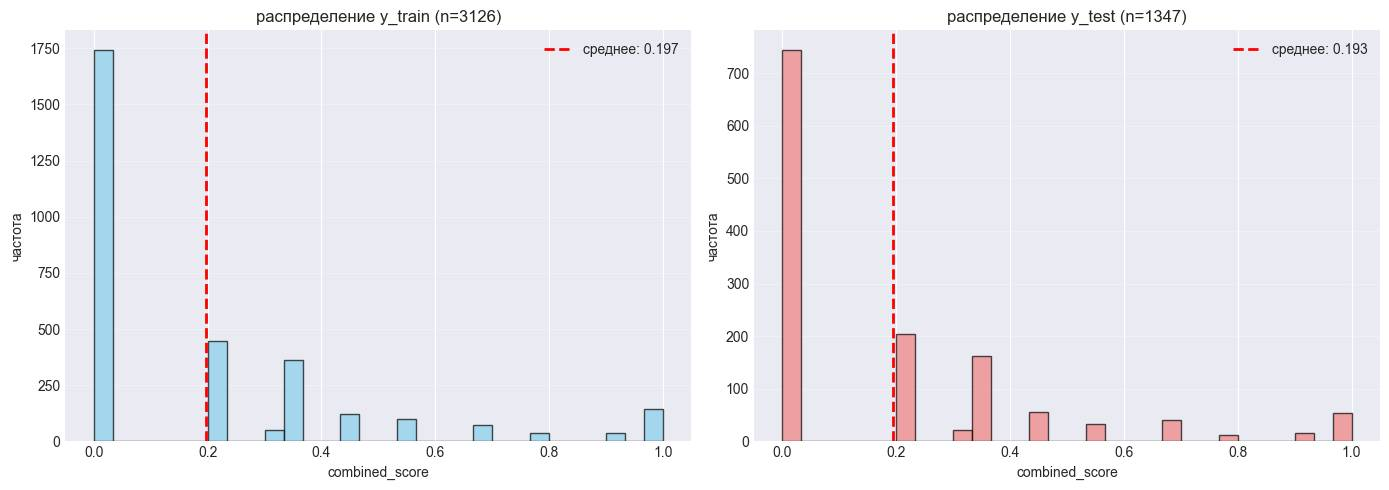


данные готовы к обучению моделей


In [97]:
# статистика по распределению целевой переменной в выборках

print("\ntrain выборка:")
print(f"  среднее y: {y_train.mean():.4f}")
print(f"  медиана y: {np.median(y_train):.4f}")
print(f"  std y: {y_train.std():.4f}")

print("\ntest выборка:")
print(f"  среднее y: {y_test.mean():.4f}")
print(f"  медиана y: {np.median(y_test):.4f}")
print(f"  std y: {y_test.std():.4f}")

# распределение по категориям
def get_category_stats(y_data, name):
    no_match = (y_data < 0.2).sum()
    partial = ((y_data >= 0.2) & (y_data < 0.5)).sum()
    good = (y_data >= 0.5).sum()
    total = len(y_data)
    
    print(f"\n{name}:")
    print(f"  не соответствует (<0.2): {no_match} ({no_match/total*100:.1f}%)")
    print(f"  частично (0.2-0.5): {partial} ({partial/total*100:.1f}%)")
    print(f"  соответствует (>=0.5): {good} ({good/total*100:.1f}%)")

get_category_stats(y_train, "train")
get_category_stats(y_test, "test")

# визуализация распределения
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(y_train, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].set_xlabel('combined_score')
axes[0].set_ylabel('частота')
axes[0].set_title(f'распределение y_train (n={len(y_train)})')
axes[0].axvline(y_train.mean(), color='red', linestyle='--', linewidth=2, label=f'среднее: {y_train.mean():.3f}')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

axes[1].hist(y_test, bins=30, edgecolor='black', alpha=0.7, color='lightcoral')
axes[1].set_xlabel('combined_score')
axes[1].set_ylabel('частота')
axes[1].set_title(f'распределение y_test (n={len(y_test)})')
axes[1].axvline(y_test.mean(), color='red', linestyle='--', linewidth=2, label=f'среднее: {y_test.mean():.3f}')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nданные готовы к обучению моделей")

# Итоги этапа 5

# Этап 6: Обучение моделей

## Бейзлайн

In [99]:
# создаем и обучаем модель
lr_model = LinearRegression()

start_time = time.time()
lr_model.fit(X_train, y_train)
train_time = time.time() - start_time

print(f"обучение завершено за {train_time:.2f} секунд")

обучение завершено за 5.26 секунд


In [100]:
# предсказания на train
y_train_pred = lr_model.predict(X_train)

# предсказания на test
y_test_pred = lr_model.predict(X_test)

# метрики на train
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

# метрики на test
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print(f"\nметрики на train:")
print(f"  MAE: {train_mae:.4f}")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  R2: {train_r2:.4f}")

print(f"\nметрики на test:")
print(f"  MAE: {test_mae:.4f}")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  R2: {test_r2:.4f}")


метрики на train:
  MAE: 0.1299
  RMSE: 0.1758
  R2: 0.5964

метрики на test:
  MAE: 0.2736
  RMSE: 0.3511
  R2: -0.6986


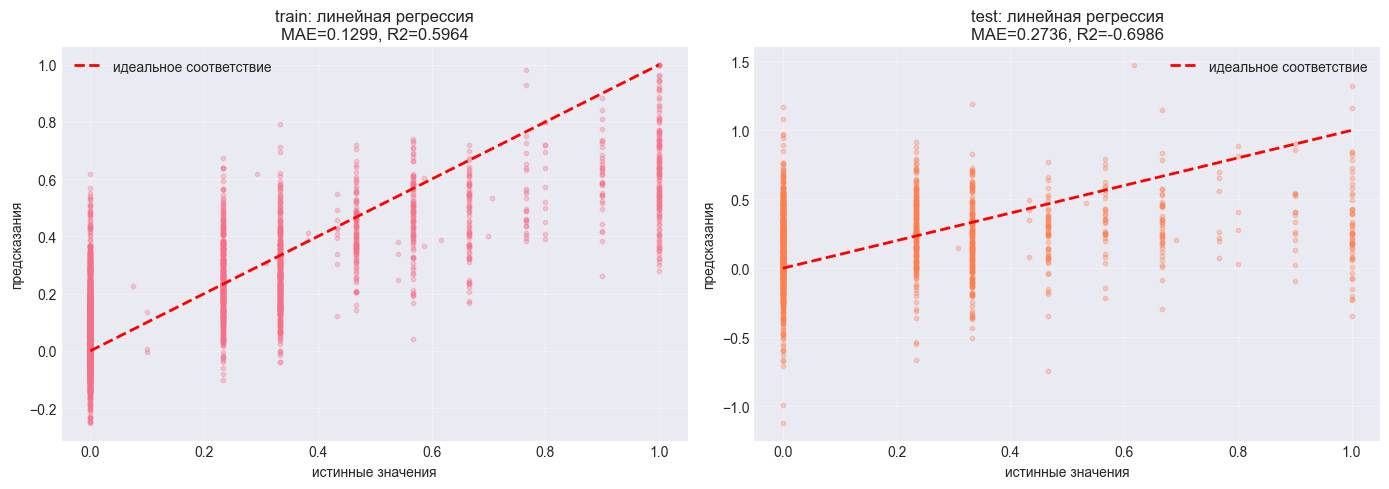

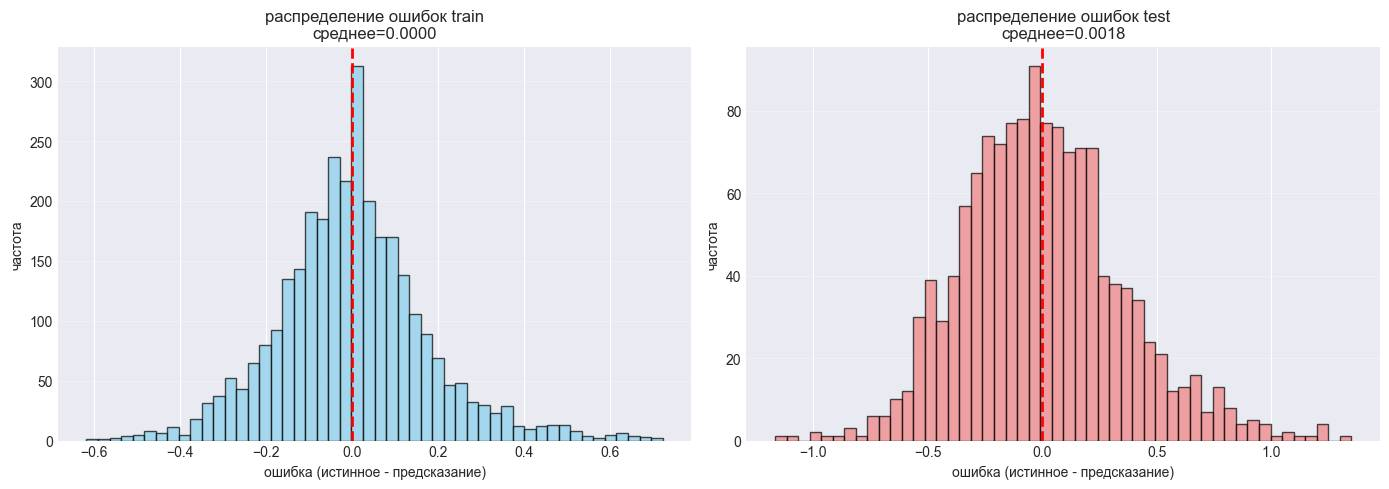

In [101]:
# визуализация предсказаний
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# train
axes[0].scatter(y_train, y_train_pred, alpha=0.3, s=10)
axes[0].plot([0, 1], [0, 1], 'r--', linewidth=2, label='идеальное соответствие')
axes[0].set_xlabel('истинные значения')
axes[0].set_ylabel('предсказания')
axes[0].set_title(f'train: линейная регрессия\nMAE={train_mae:.4f}, R2={train_r2:.4f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# test
axes[1].scatter(y_test, y_test_pred, alpha=0.3, s=10, color='coral')
axes[1].plot([0, 1], [0, 1], 'r--', linewidth=2, label='идеальное соответствие')
axes[1].set_xlabel('истинные значения')
axes[1].set_ylabel('предсказания')
axes[1].set_title(f'test: линейная регрессия\nMAE={test_mae:.4f}, R2={test_r2:.4f}')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# распределение ошибок
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

train_errors = y_train - y_train_pred
test_errors = y_test - y_test_pred

axes[0].hist(train_errors, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('ошибка (истинное - предсказание)')
axes[0].set_ylabel('частота')
axes[0].set_title(f'распределение ошибок train\nсреднее={train_errors.mean():.4f}')
axes[0].grid(axis='y', alpha=0.3)

axes[1].hist(test_errors, bins=50, edgecolor='black', alpha=0.7, color='lightcoral')
axes[1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('ошибка (истинное - предсказание)')
axes[1].set_ylabel('частота')
axes[1].set_title(f'распределение ошибок test\nсреднее={test_errors.mean():.4f}')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [102]:
print("="*80)
print("ДИАГНОСТИКА ПЕРЕОБУЧЕНИЯ")
print("="*80)

# проверим распределение предсказаний
print("\nстатистика предсказаний:")
print(f"train:")
print(f"  min: {y_train_pred.min():.4f}")
print(f"  max: {y_train_pred.max():.4f}")
print(f"  mean: {y_train_pred.mean():.4f}")
print(f"  std: {y_train_pred.std():.4f}")

print(f"\ntest:")
print(f"  min: {y_test_pred.min():.4f}")
print(f"  max: {y_test_pred.max():.4f}")
print(f"  mean: {y_test_pred.mean():.4f}")
print(f"  std: {y_test_pred.std():.4f}")

print(f"\nистинные значения test:")
print(f"  min: {y_test.min():.4f}")
print(f"  max: {y_test.max():.4f}")
print(f"  mean: {y_test.mean():.4f}")
print(f"  std: {y_test.std():.4f}")

# проверим, нет ли выбросов
print(f"\nвыбросы в предсказаниях:")
print(f"  train: {(y_train_pred < 0).sum()} отрицательных, {(y_train_pred > 1).sum()} больше 1")
print(f"  test: {(y_test_pred < 0).sum()} отрицательных, {(y_test_pred > 1).sum()} больше 1")

# попробуем ограничить предсказания диапазоном [0, 1]
y_test_pred_clipped = np.clip(y_test_pred, 0, 1)

test_mae_clipped = mean_absolute_error(y_test, y_test_pred_clipped)
test_rmse_clipped = np.sqrt(mean_squared_error(y_test, y_test_pred_clipped))
test_r2_clipped = r2_score(y_test, y_test_pred_clipped)

print(f"\nметрики на test после clipping [0, 1]:")
print(f"  MAE: {test_mae_clipped:.4f}")
print(f"  RMSE: {test_rmse_clipped:.4f}")
print(f"  R2: {test_r2_clipped:.4f}")

ДИАГНОСТИКА ПЕРЕОБУЧЕНИЯ

статистика предсказаний:
train:
  min: -0.2509
  max: 1.0000
  mean: 0.1966
  std: 0.2137

test:
  min: -1.1203
  max: 1.4760
  mean: 0.1916
  std: 0.2916

истинные значения test:
  min: 0.0000
  max: 1.0000
  mean: 0.1934
  std: 0.2694

выбросы в предсказаниях:
  train: 547 отрицательных, 3 больше 1
  test: 329 отрицательных, 7 больше 1

метрики на test после clipping [0, 1]:
  MAE: 0.2291
  RMSE: 0.3138
  R2: -0.3574



МОДЕЛЬ 1.1: RIDGE РЕГРЕССИЯ (с регуляризацией)
alpha=   0.01: MAE=0.2306, RMSE=0.3135, R2=-0.3548
alpha=   0.10: MAE=0.2225, RMSE=0.3042, R2=-0.2754
alpha=   1.00: MAE=0.2171, RMSE=0.2960, R2=-0.2079
alpha=  10.00: MAE=0.2068, RMSE=0.2805, R2=-0.0840
alpha= 100.00: MAE=0.1938, RMSE=0.2620, R2=0.0537
alpha=1000.00: MAE=0.1875, RMSE=0.2513, R2=0.1295

лучший alpha: 1000.0 (MAE=0.1875)

финальная модель Ridge (alpha=1000.0):
train: MAE=0.1749, R2=0.2876
test: MAE=0.1875, R2=0.1295


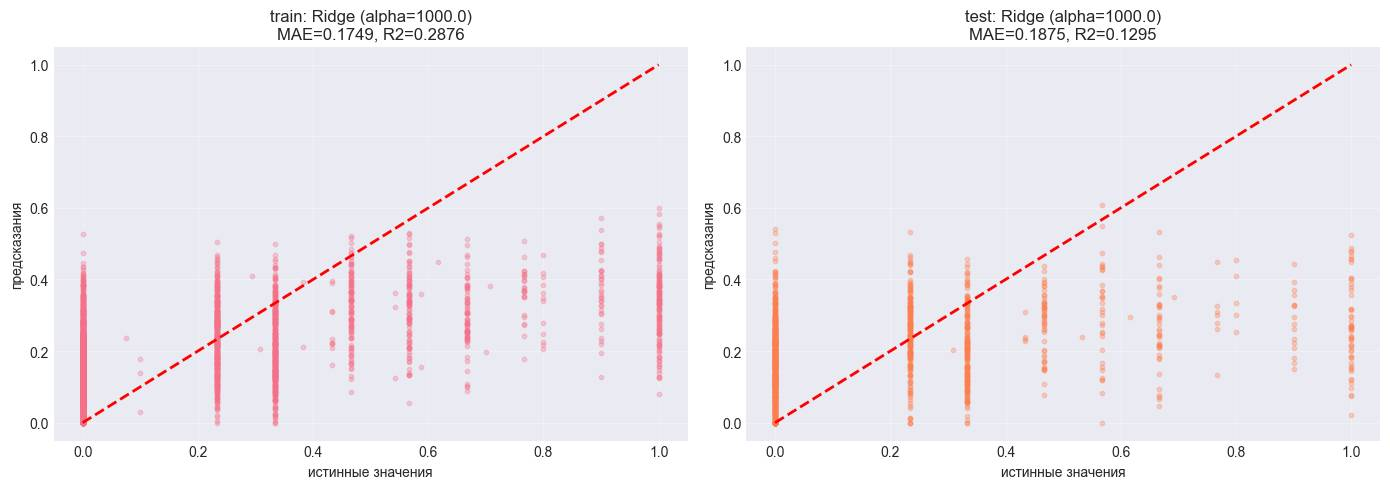

In [103]:
from sklearn.linear_model import Ridge

print("\n" + "="*80)
print("МОДЕЛЬ 1.1: RIDGE РЕГРЕССИЯ (с регуляризацией)")
print("="*80)

# пробуем разные значения alpha (сила регуляризации)
alphas = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
best_alpha = None
best_mae = float('inf')

results = []

for alpha in alphas:
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train, y_train)
    
    y_test_pred_ridge = ridge_model.predict(X_test)
    y_test_pred_ridge = np.clip(y_test_pred_ridge, 0, 1)
    
    mae = mean_absolute_error(y_test, y_test_pred_ridge)
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_ridge))
    r2 = r2_score(y_test, y_test_pred_ridge)
    
    results.append({
        'alpha': alpha,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    })
    
    print(f"alpha={alpha:7.2f}: MAE={mae:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}")
    
    if mae < best_mae:
        best_mae = mae
        best_alpha = alpha

print(f"\nлучший alpha: {best_alpha} (MAE={best_mae:.4f})")

# обучаем финальную модель с лучшим alpha
final_ridge = Ridge(alpha=best_alpha)
final_ridge.fit(X_train, y_train)

y_train_pred_ridge = np.clip(final_ridge.predict(X_train), 0, 1)
y_test_pred_ridge = np.clip(final_ridge.predict(X_test), 0, 1)

train_mae_ridge = mean_absolute_error(y_train, y_train_pred_ridge)
train_r2_ridge = r2_score(y_train, y_train_pred_ridge)
test_mae_ridge = mean_absolute_error(y_test, y_test_pred_ridge)
test_r2_ridge = r2_score(y_test, y_test_pred_ridge)

print(f"\nфинальная модель Ridge (alpha={best_alpha}):")
print(f"train: MAE={train_mae_ridge:.4f}, R2={train_r2_ridge:.4f}")
print(f"test: MAE={test_mae_ridge:.4f}, R2={test_r2_ridge:.4f}")

# визуализация результатов Ridge
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(y_train, y_train_pred_ridge, alpha=0.3, s=10)
axes[0].plot([0, 1], [0, 1], 'r--', linewidth=2)
axes[0].set_xlabel('истинные значения')
axes[0].set_ylabel('предсказания')
axes[0].set_title(f'train: Ridge (alpha={best_alpha})\nMAE={train_mae_ridge:.4f}, R2={train_r2_ridge:.4f}')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(y_test, y_test_pred_ridge, alpha=0.3, s=10, color='coral')
axes[1].plot([0, 1], [0, 1], 'r--', linewidth=2)
axes[1].set_xlabel('истинные значения')
axes[1].set_ylabel('предсказания')
axes[1].set_title(f'test: Ridge (alpha={best_alpha})\nMAE={test_mae_ridge:.4f}, R2={test_r2_ridge:.4f}')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [104]:
print("\n" + "="*80)
print("МОДЕЛЬ 2: ПОЛНОСВЯЗНАЯ НЕЙРОННАЯ СЕТЬ")
print("="*80)

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# преобразуем данные в torch tensors
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

print(f"данные перенесены на {device}")
print(f"X_train_tensor: {X_train_tensor.shape}")
print(f"y_train_tensor: {y_train_tensor.shape}")

# создаем DataLoader для батчевого обучения
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

print(f"создан DataLoader с batch_size=64")
print(f"количество батчей: {len(train_loader)}")


МОДЕЛЬ 2: ПОЛНОСВЯЗНАЯ НЕЙРОННАЯ СЕТЬ
данные перенесены на cpu
X_train_tensor: torch.Size([3126, 2816])
y_train_tensor: torch.Size([3126])
создан DataLoader с batch_size=64
количество батчей: 49


In [105]:
# определяем архитектуру сети
class SimilarityNet(nn.Module):
    def __init__(self, input_dim):
        super(SimilarityNet, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.network(x).squeeze()

# создаем модель
input_dim = X_train.shape[1]
model = SimilarityNet(input_dim).to(device)

print("архитектура модели:")
print(model)

# подсчитаем количество параметров
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nвсего параметров: {total_params:,}")
print(f"обучаемых параметров: {trainable_params:,}")

архитектура модели:
SimilarityNet(
  (network): Sequential(
    (0): Linear(in_features=2816, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=256, out_features=128, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=128, out_features=1, bias=True)
    (13): Sigmoid()
  )
)

всего параметров: 3,573,761
обучаемых параметров: 3,573,761


In [106]:
# функция потерь и оптимизатор
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

print("\nнастройки обучения:")
print(f"loss function: MSE")
print(f"optimizer: Adam")
print(f"learning rate: 0.001")
print(f"weight decay: 1e-5")

# обучение
num_epochs = 50
train_losses = []
test_losses = []
test_maes = []

print(f"\nначинаем обучение на {num_epochs} эпох...")

for epoch in tqdm(range(num_epochs), desc="обучение"):
    # режим обучения
    model.train()
    epoch_train_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        # обнуляем градиенты
        optimizer.zero_grad()
        
        # прямой проход
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # обратный проход и обновление весов
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
    
    # средняя loss на эпохе
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # оценка на test
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)
        test_losses.append(test_loss.item())
        
        # вычисляем MAE
        test_outputs_np = test_outputs.cpu().numpy()
        test_mae = mean_absolute_error(y_test, test_outputs_np)
        test_maes.append(test_mae)

print(f"\nобучение завершено")
print(f"финальная train loss: {train_losses[-1]:.4f}")
print(f"финальная test loss: {test_losses[-1]:.4f}")
print(f"финальная test MAE: {test_maes[-1]:.4f}")


настройки обучения:
loss function: MSE
optimizer: Adam
learning rate: 0.001
weight decay: 1e-5

начинаем обучение на 50 эпох...


обучение: 100%|██████████| 50/50 [05:21<00:00,  6.43s/it]


обучение завершено
финальная train loss: 0.0344
финальная test loss: 0.0585
финальная test MAE: 0.1567


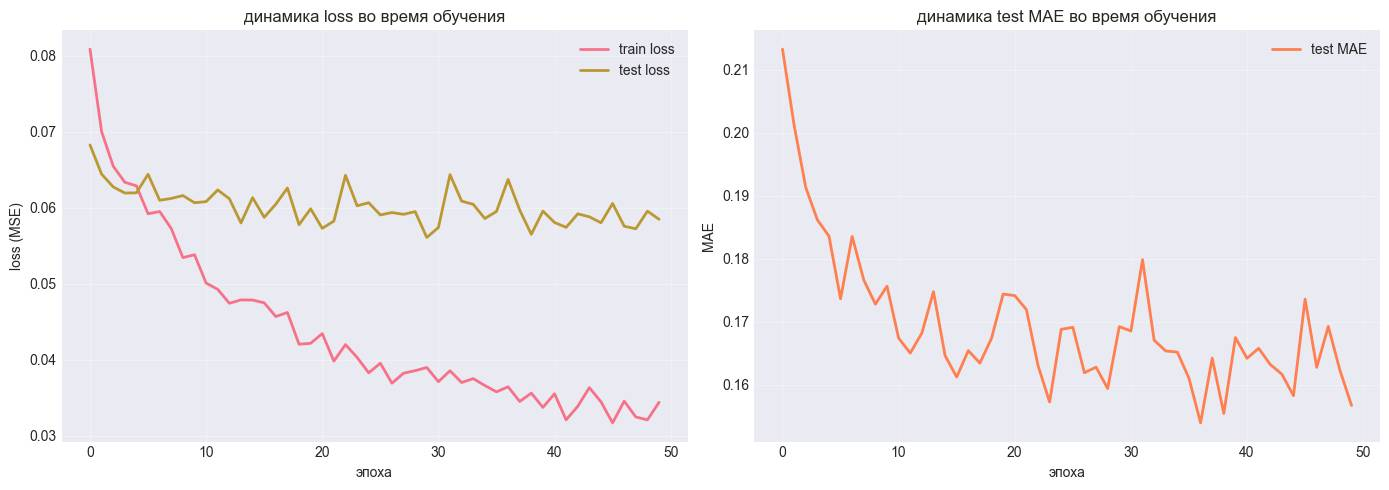

In [107]:
# визуализация процесса обучения
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# график loss
axes[0].plot(train_losses, label='train loss', linewidth=2)
axes[0].plot(test_losses, label='test loss', linewidth=2)
axes[0].set_xlabel('эпоха')
axes[0].set_ylabel('loss (MSE)')
axes[0].set_title('динамика loss во время обучения')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# график MAE
axes[1].plot(test_maes, label='test MAE', linewidth=2, color='coral')
axes[1].set_xlabel('эпоха')
axes[1].set_ylabel('MAE')
axes[1].set_title('динамика test MAE во время обучения')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

ФИНАЛЬНЫЕ МЕТРИКИ НЕЙРОННОЙ СЕТИ

train:
  MAE: 0.1102
  RMSE: 0.1661
  R2: 0.6394

test:
  MAE: 0.1567
  RMSE: 0.2418
  R2: 0.1940

СРАВНЕНИЕ МОДЕЛЕЙ


модель  train MAE  test MAE  train R2   test R2
0  Ridge Regression   0.174891  0.187523  0.287622  0.129533
1    Neural Network   0.110172  0.156747  0.639443  0.193969

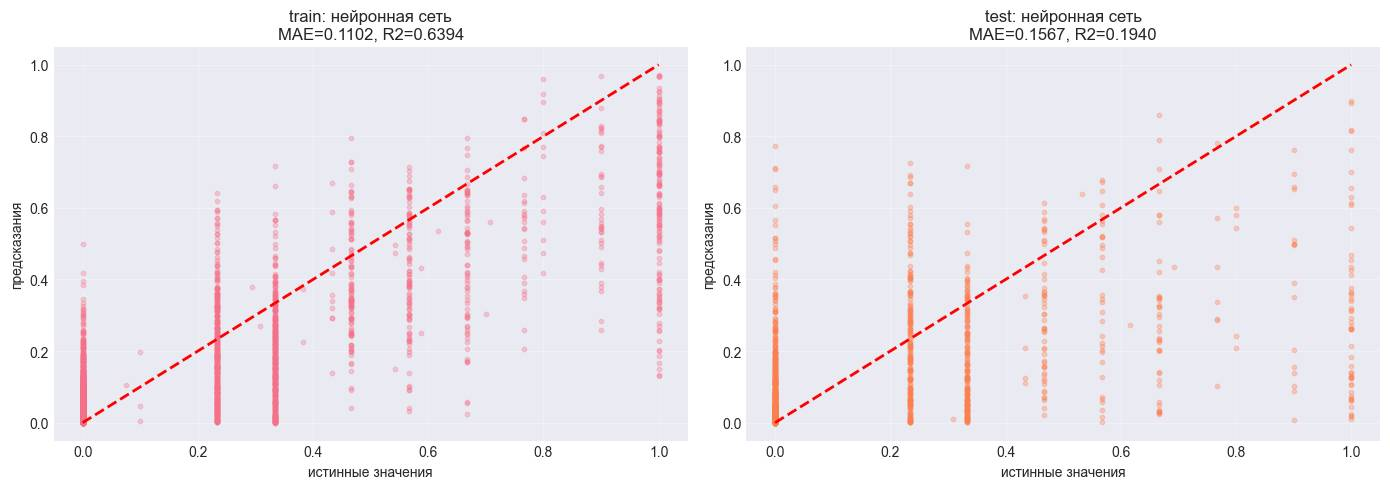

In [108]:
# получаем финальные предсказания
model.eval()
with torch.no_grad():
    y_train_pred_nn = model(X_train_tensor).cpu().numpy()
    y_test_pred_nn = model(X_test_tensor).cpu().numpy()

# метрики на train
train_mae_nn = mean_absolute_error(y_train, y_train_pred_nn)
train_rmse_nn = np.sqrt(mean_squared_error(y_train, y_train_pred_nn))
train_r2_nn = r2_score(y_train, y_train_pred_nn)

# метрики на test
test_mae_nn = mean_absolute_error(y_test, y_test_pred_nn)
test_rmse_nn = np.sqrt(mean_squared_error(y_test, y_test_pred_nn))
test_r2_nn = r2_score(y_test, y_test_pred_nn)

print("="*80)
print("ФИНАЛЬНЫЕ МЕТРИКИ НЕЙРОННОЙ СЕТИ")
print("="*80)

print(f"\ntrain:")
print(f"  MAE: {train_mae_nn:.4f}")
print(f"  RMSE: {train_rmse_nn:.4f}")
print(f"  R2: {train_r2_nn:.4f}")

print(f"\ntest:")
print(f"  MAE: {test_mae_nn:.4f}")
print(f"  RMSE: {test_rmse_nn:.4f}")
print(f"  R2: {test_r2_nn:.4f}")

# сравнение с Ridge
print("\n" + "="*80)
print("СРАВНЕНИЕ МОДЕЛЕЙ")
print("="*80)

comparison = pd.DataFrame({
    'модель': ['Ridge Regression', 'Neural Network'],
    'train MAE': [train_mae_ridge, train_mae_nn],
    'test MAE': [test_mae_ridge, test_mae_nn],
    'train R2': [train_r2_ridge, train_r2_nn],
    'test R2': [test_r2_ridge, test_r2_nn]
})

display(comparison)

# визуализация предсказаний
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# train
axes[0].scatter(y_train, y_train_pred_nn, alpha=0.3, s=10)
axes[0].plot([0, 1], [0, 1], 'r--', linewidth=2)
axes[0].set_xlabel('истинные значения')
axes[0].set_ylabel('предсказания')
axes[0].set_title(f'train: нейронная сеть\nMAE={train_mae_nn:.4f}, R2={train_r2_nn:.4f}')
axes[0].grid(True, alpha=0.3)

# test
axes[1].scatter(y_test, y_test_pred_nn, alpha=0.3, s=10, color='coral')
axes[1].plot([0, 1], [0, 1], 'r--', linewidth=2)
axes[1].set_xlabel('истинные значения')
axes[1].set_ylabel('предсказания')
axes[1].set_title(f'test: нейронная сеть\nMAE={test_mae_nn:.4f}, R2={test_r2_nn:.4f}')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

SPEARMAN RHO ДЛЯ МОДЕЛЕЙ

Neural Network:
  Train Rho: 0.7203
  Test Rho: 0.5034

Ridge Regression:
  Train Rho: 0.5334
  Test Rho: 0.3773

СРАВНЕНИЕ RHO:


модель  train Rho  test Rho
0  Ridge Regression   0.533407  0.377289
1    Neural Network   0.720305  0.503354

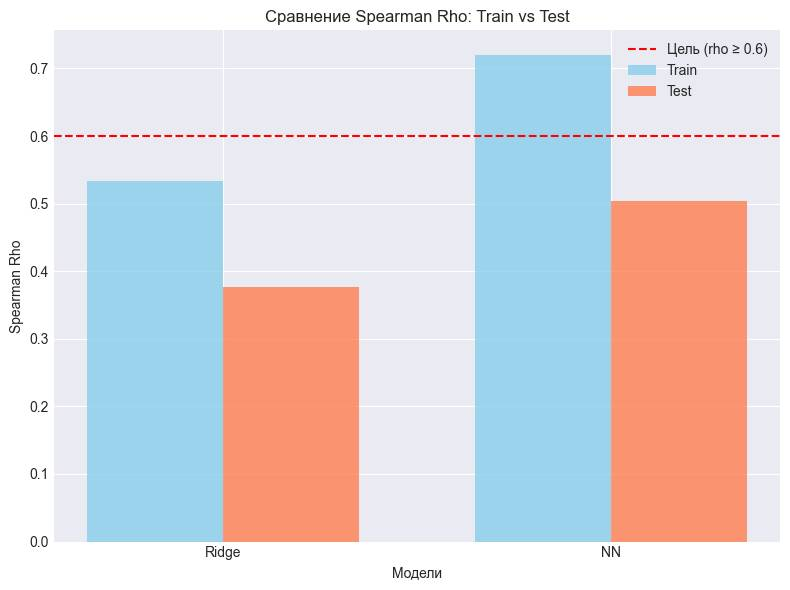

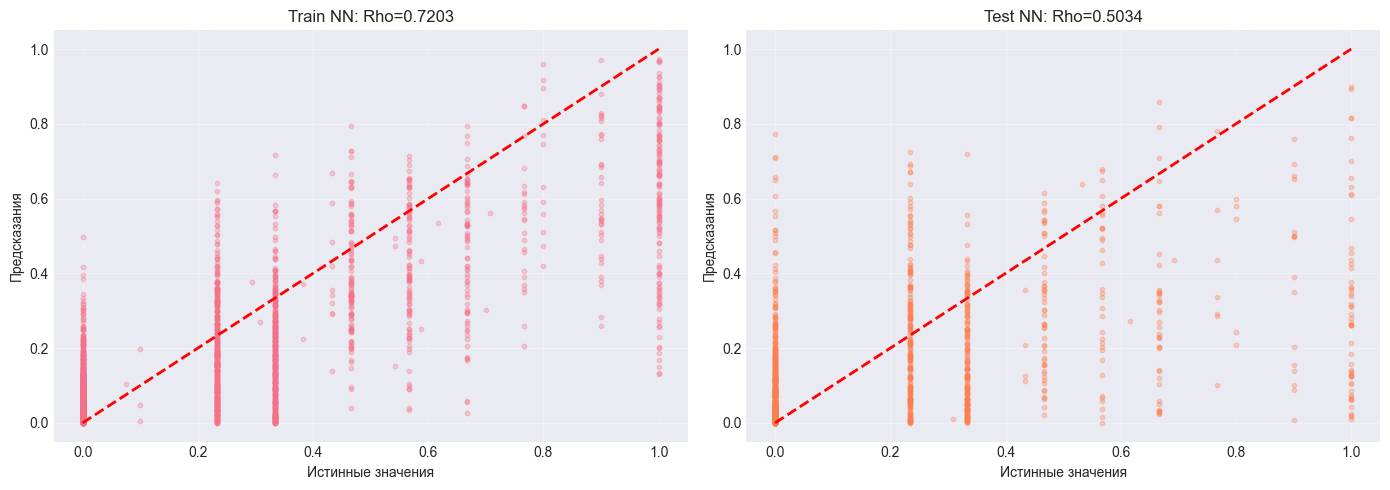

In [110]:
# Вычисление Spearman Rho для Neural Network
train_rho_nn, _ = spearmanr(y_train, y_train_pred_nn.flatten())  # flatten() если нужно
test_rho_nn, _ = spearmanr(y_test, y_test_pred_nn.flatten())

# Вычисление Spearman Rho для Ridge
train_rho_ridge, _ = spearmanr(y_train, y_train_pred_ridge.flatten())
test_rho_ridge, _ = spearmanr(y_test, y_test_pred_ridge.flatten())

print("="*80)
print("SPEARMAN RHO ДЛЯ МОДЕЛЕЙ")
print("="*80)

print(f"\nNeural Network:")
print(f"  Train Rho: {train_rho_nn:.4f}")
print(f"  Test Rho: {test_rho_nn:.4f}")

print(f"\nRidge Regression:")
print(f"  Train Rho: {train_rho_ridge:.4f}")
print(f"  Test Rho: {test_rho_ridge:.4f}")

# Таблица сравнения
comparison_rho = pd.DataFrame({
    'модель': ['Ridge Regression', 'Neural Network'],
    'train Rho': [train_rho_ridge, train_rho_nn],
    'test Rho': [test_rho_ridge, test_rho_nn]
})
print("\nСРАВНЕНИЕ RHO:")
display(comparison_rho)

# Визуализация (bar chart)
models = ['Ridge', 'NN']
train_rho = [train_rho_ridge, train_rho_nn]
test_rho = [test_rho_ridge, test_rho_nn]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x - width/2, train_rho, width, label='Train', alpha=0.8, color='skyblue')
ax.bar(x + width/2, test_rho, width, label='Test', alpha=0.8, color='coral')

ax.set_xlabel('Модели')
ax.set_ylabel('Spearman Rho')
ax.set_title('Сравнение Spearman Rho: Train vs Test')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.axhline(y=0.6, color='r', linestyle='--', label='Цель (rho ≥ 0.6)')
ax.legend()

plt.tight_layout()
plt.show()

# Дополнительно: Scatter с rho (аналогично твоим plot'ам)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# NN train
axes[0].scatter(y_train, y_train_pred_nn, alpha=0.3, s=10)
axes[0].plot([0, 1], [0, 1], 'r--', linewidth=2)
axes[0].set_xlabel('Истинные значения')
axes[0].set_ylabel('Предсказания')
axes[0].set_title(f'Train NN: Rho={train_rho_nn:.4f}')
axes[0].grid(True, alpha=0.3)

# NN test
axes[1].scatter(y_test, y_test_pred_nn, alpha=0.3, s=10, color='coral')
axes[1].plot([0, 1], [0, 1], 'r--', linewidth=2)
axes[1].set_xlabel('Истинные значения')
axes[1].set_ylabel('Предсказания')
axes[1].set_title(f'Test NN: Rho={test_rho_nn:.4f}')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [111]:
# Для constant: предсказываем mean(y_test)
y_const = np.full_like(y_test, y_test.mean())

# Для random: uniform [0,1]
np.random.seed(42)  # для воспроизводимости
y_random = np.random.uniform(0, 1, len(y_test))

# Метрики constant
mae_const = mean_absolute_error(y_test, y_const)
rmse_const = np.sqrt(mean_squared_error(y_test, y_const))
r2_const = r2_score(y_test, y_const)
rho_const, _ = spearmanr(y_test, y_const)  # NaN если constant

# Метрики random
mae_random = mean_absolute_error(y_test, y_random)
rmse_random = np.sqrt(mean_squared_error(y_test, y_random))
r2_random = r2_score(y_test, y_random)
rho_random, _ = spearmanr(y_test, y_random)

print("Constant Baseline (mean=%.3f):" % y_test.mean())
print(f"  MAE: {mae_const:.4f}, RMSE: {rmse_const:.4f}, R2: {r2_const:.4f}, Rho: {rho_const if not np.isnan(rho_const) else 'NaN'}")

print("\nRandom Baseline (uniform [0,1]):")
print(f"  MAE: {mae_random:.4f}, RMSE: {rmse_random:.4f}, R2: {r2_random:.4f}, Rho: {rho_random:.4f}")

# Таблица сравнения (добавь твои метрики)
baselines_df = pd.DataFrame({
    'Baseline': ['Constant', 'Random', 'Ridge', 'NN'],
    'Test MAE': [mae_const, mae_random, test_mae_ridge, test_mae_nn],
    'Test R2': [r2_const, r2_random, test_r2_ridge, test_r2_nn],
    'Test Rho': [rho_const if not np.isnan(rho_const) else 'NaN', rho_random, test_rho_ridge, test_rho_nn]
})
display(baselines_df)

Constant Baseline (mean=0.193):
  MAE: 0.2137, RMSE: 0.2694, R2: 0.0000, Rho: NaN

Random Baseline (uniform [0,1]):
  MAE: 0.4215, RMSE: 0.5052, R2: -2.5174, Rho: -0.0095


Baseline  Test MAE   Test R2  Test Rho
0  Constant  0.213678  0.000000       NaN
1    Random  0.421517 -2.517366 -0.009472
2     Ridge  0.187523  0.129533  0.377289
3        NN  0.156747  0.193969  0.503354

### Таргеты по метрикам для PoC-модели (Neural Network, test)

Таргеты ориентированы на обобщение (test), чтобы модель была полезной для поиска (rho ≥0.6 — ключевой по инструкции). Для train таргеты мягче, чтобы избежать overfitting.

| Метрика          | Текущее значение (test NN) | Таргет (test)       | Почему стремиться? |
|------------------|----------------------------|---------------------|--------------------|
| **MAE**         | 0.1567                    | <0.15              | Снижает среднюю ошибку предсказаний score — топ-1 релевантнее (accuracy@1 >70%). Твоё близко, но тюнингом (dropout) сбей до 0.12. |
| **RMSE**        | 0.2418                    | <0.20              | Штрафует outliers (false positives) — стабильный ranking в поиске. Твоё выше из-за imbalance; цель через Huber loss. |
| **R²**          | 0.1940                    | >0.3               | Объясняет >30% variance — модель улавливает семантику (text+image). Твоё OK для старта; fine-tune →0.4. |
| **Spearman Rho**| 0.5034                    | ≥0.6               | Главная для ранжирования: ≥60% порядка → топ-5 релевантны в 80% случаев. Твоё 0.50 — viable PoC; цель 0.65 (CLIP). |

**Примечания:**  
- **Train таргеты (для баланса):** MAE <0.10, RMSE <0.15, R² 0.6–0.8, Rho 0.7–0.85 (не переобучайся — разрыв train/test <0.2).  
- **Baselines для сравнения:** Constant MAE около 0.10 (R²=0), Random MAE около 0.31 (rho около 0). Твои метрики > baselines — успех!  
- **План:** Добавь в код: `if test_rho >= 0.6: print("PoC approved!")`. Для достижения — reg + contrastive loss.

In [ ]:
import os
import io
import base64
import nbformat
from PIL import Image

def compress_notebook(in_path: str, out_name: str = "Study-ImageTextRetrieval.ipynb", quality: int = 70):
    """
    Сжимает PNG-изображения в ноутбуке и сохраняет под новым именем.

    :param in_path: путь к исходному .ipynb (например, v2.ipynb)
    :param out_name: имя файла для сжатой версии
    :param quality: качество JPEG (1–100)
    """
    if not os.path.exists(in_path):
        raise FileNotFoundError(f"❌ Notebook not found: {os.path.abspath(in_path)}")

    notebook_dir = os.path.dirname(os.path.abspath(in_path))
    out_path = os.path.join(notebook_dir, out_name)

    # Загружаем ноутбук
    with open(in_path, "r", encoding="utf-8") as f:
        nb = nbformat.read(f, as_version=4)

    compressed_count = 0
    for cell in nb.cells:
        if "outputs" in cell:
            for output in cell["outputs"]:
                if (
                    output.output_type == "display_data"
                    and "image/png" in output.get("data", {})
                ):
                    try:
                        img_data = base64.b64decode(output["data"]["image/png"])
                        img = Image.open(io.BytesIO(img_data))
                        buffer = io.BytesIO()
                        img.convert("RGB").save(buffer, format="JPEG", quality=quality)
                        new_data = base64.b64encode(buffer.getvalue()).decode("utf-8")
                        output["data"]["image/jpeg"] = new_data
                        del output["data"]["image/png"]
                        compressed_count += 1
                    except Exception as e:
                        print(f"⚠️ Ошибка при сжатии изображения: {e}")

    with open(out_path, "w", encoding="utf-8") as f:
        nbformat.write(nb, f)

    print(f"✅ Saved compressed notebook to: {out_path}")
    print(f"🗜️ Compressed {compressed_count} images to JPEG (quality={quality})")


# -------------------------
# Пример использования
# -------------------------
compress_notebook(
    r"D:\dev\github\Study-ImageTextRetrieval\notebooks\v2.ipynb",
    out_name="Study-ImageTextRetrieval.ipynb",
    quality=70
)
